In [160]:
import pandas as pd
import numpy as np
#visuals
import matplotlib.pyplot as plt
import seaborn as sns
#db
import psycopg2 as psy
#for decoding the IP's location
import geoip2.database
from geopy.geocoders import Nominatim


In [161]:
Feb5 = pd.read_csv('/Users/sa12/Documents/Repositories/The-CyberChase/CybercrimeData/2023-02-05.csv')
Feb6 = pd.read_csv('/Users/sa12/Documents/Repositories/The-CyberChase/CybercrimeData/2023-02-06.csv')

In [162]:
Feb5.describe()

Src Port      Dst Port     Protocol  Flow Duration  \
count   1950.000000   1950.000000  1950.000000   1.950000e+03   
mean   33772.874872    982.644103    14.929744   5.095167e+06   
std    18880.070091   5660.826587     4.300738   1.120996e+07   
min       22.000000     22.000000     6.000000   0.000000e+00   
25%    17480.000000    123.000000    17.000000   4.070000e+02   
50%    35824.000000    123.000000    17.000000   5.290000e+02   
75%    49768.750000    123.000000    17.000000   8.991500e+04   
max    65529.000000  60996.000000    17.000000   4.587067e+07   

       Total Fwd Packet  Total Bwd packets  Total Length of Fwd Packet  \
count       1950.000000        1950.000000                 1950.000000   
mean         222.395385          25.586154                 1909.062564   
std          674.538735        1044.031339                 5358.096049   
min            1.000000           0.000000                    0.000000   
25%            1.000000           1.000000                   48.000000   
50%            1.000000           1.000000                   48.000000   
75%            3.000000           1.000000                   48.000000   
max         3178.000000       46105.000000                25424.000000   

       Total Length of Bwd Packet  Fwd Packet Length Max  \
count                1.950000e+03            1950.000000   
mean                 3.428343e+04             105.253333   
std                  1.488086e+06             271.245718   
min                  0.000000e+00               0.000000   
25%                  4.800000e+01              31.000000   
50%                  4.800000e+01              48.000000   
75%                  4.800000e+01              48.000000   
max                  6.571264e+07            1440.000000   

       Fwd Packet Length Min  ...  Fwd Act Data Pkts  Fwd Seg Size Min  \
count            1950.000000  ...        1950.000000       1950.000000   
mean               32.734359  ...         219.676410         11.325128   
std                28.307521  ...         672.400046          7.376132   
min                 0.000000  ...           0.000000          8.000000   
25%                 8.000000  ...           0.000000          8.000000   
50%                48.000000  ...           0.000000          8.000000   
75%                48.000000  ...           1.000000          8.000000   
max               856.000000  ...        3177.000000         32.000000   

        Active Mean  Active Std    Active Max    Active Min     Idle Mean  \
count  1.950000e+03      1950.0  1.950000e+03  1.950000e+03  1.950000e+03   
mean   6.695856e+02         0.0  6.695856e+02  6.695856e+02  1.673921e+15   
std    2.391388e+04         0.0  2.391388e+04  2.391388e+04  3.791653e+13   
min    0.000000e+00         0.0  0.000000e+00  0.000000e+00  8.378195e+14   
25%    0.000000e+00         0.0  0.000000e+00  0.000000e+00  1.675639e+15   
50%    0.000000e+00         0.0  0.000000e+00  0.000000e+00  1.675639e+15   
75%    0.000000e+00         0.0  0.000000e+00  0.000000e+00  1.675639e+15   
max    1.024901e+06         0.0  1.024901e+06  1.024901e+06  1.675642e+15   

           Idle Std      Idle Max      Idle Min  
count  1.950000e+03  1.950000e+03  1.950000e+03  
mean   2.430475e+12  1.675639e+15  1.672202e+15  
std    5.362211e+13  6.244567e+08  7.583309e+13  
min    0.000000e+00  1.675638e+15  6.007164e+06  
25%    0.000000e+00  1.675639e+15  1.675639e+15  
50%    0.000000e+00  1.675639e+15  1.675639e+15  
75%    0.000000e+00  1.675639e+15  1.675639e+15  
max    1.184857e+15  1.675642e+15  1.675642e+15  

[8 rows x 79 columns]

<Axes: xlabel='Value', ylabel='Feature'>

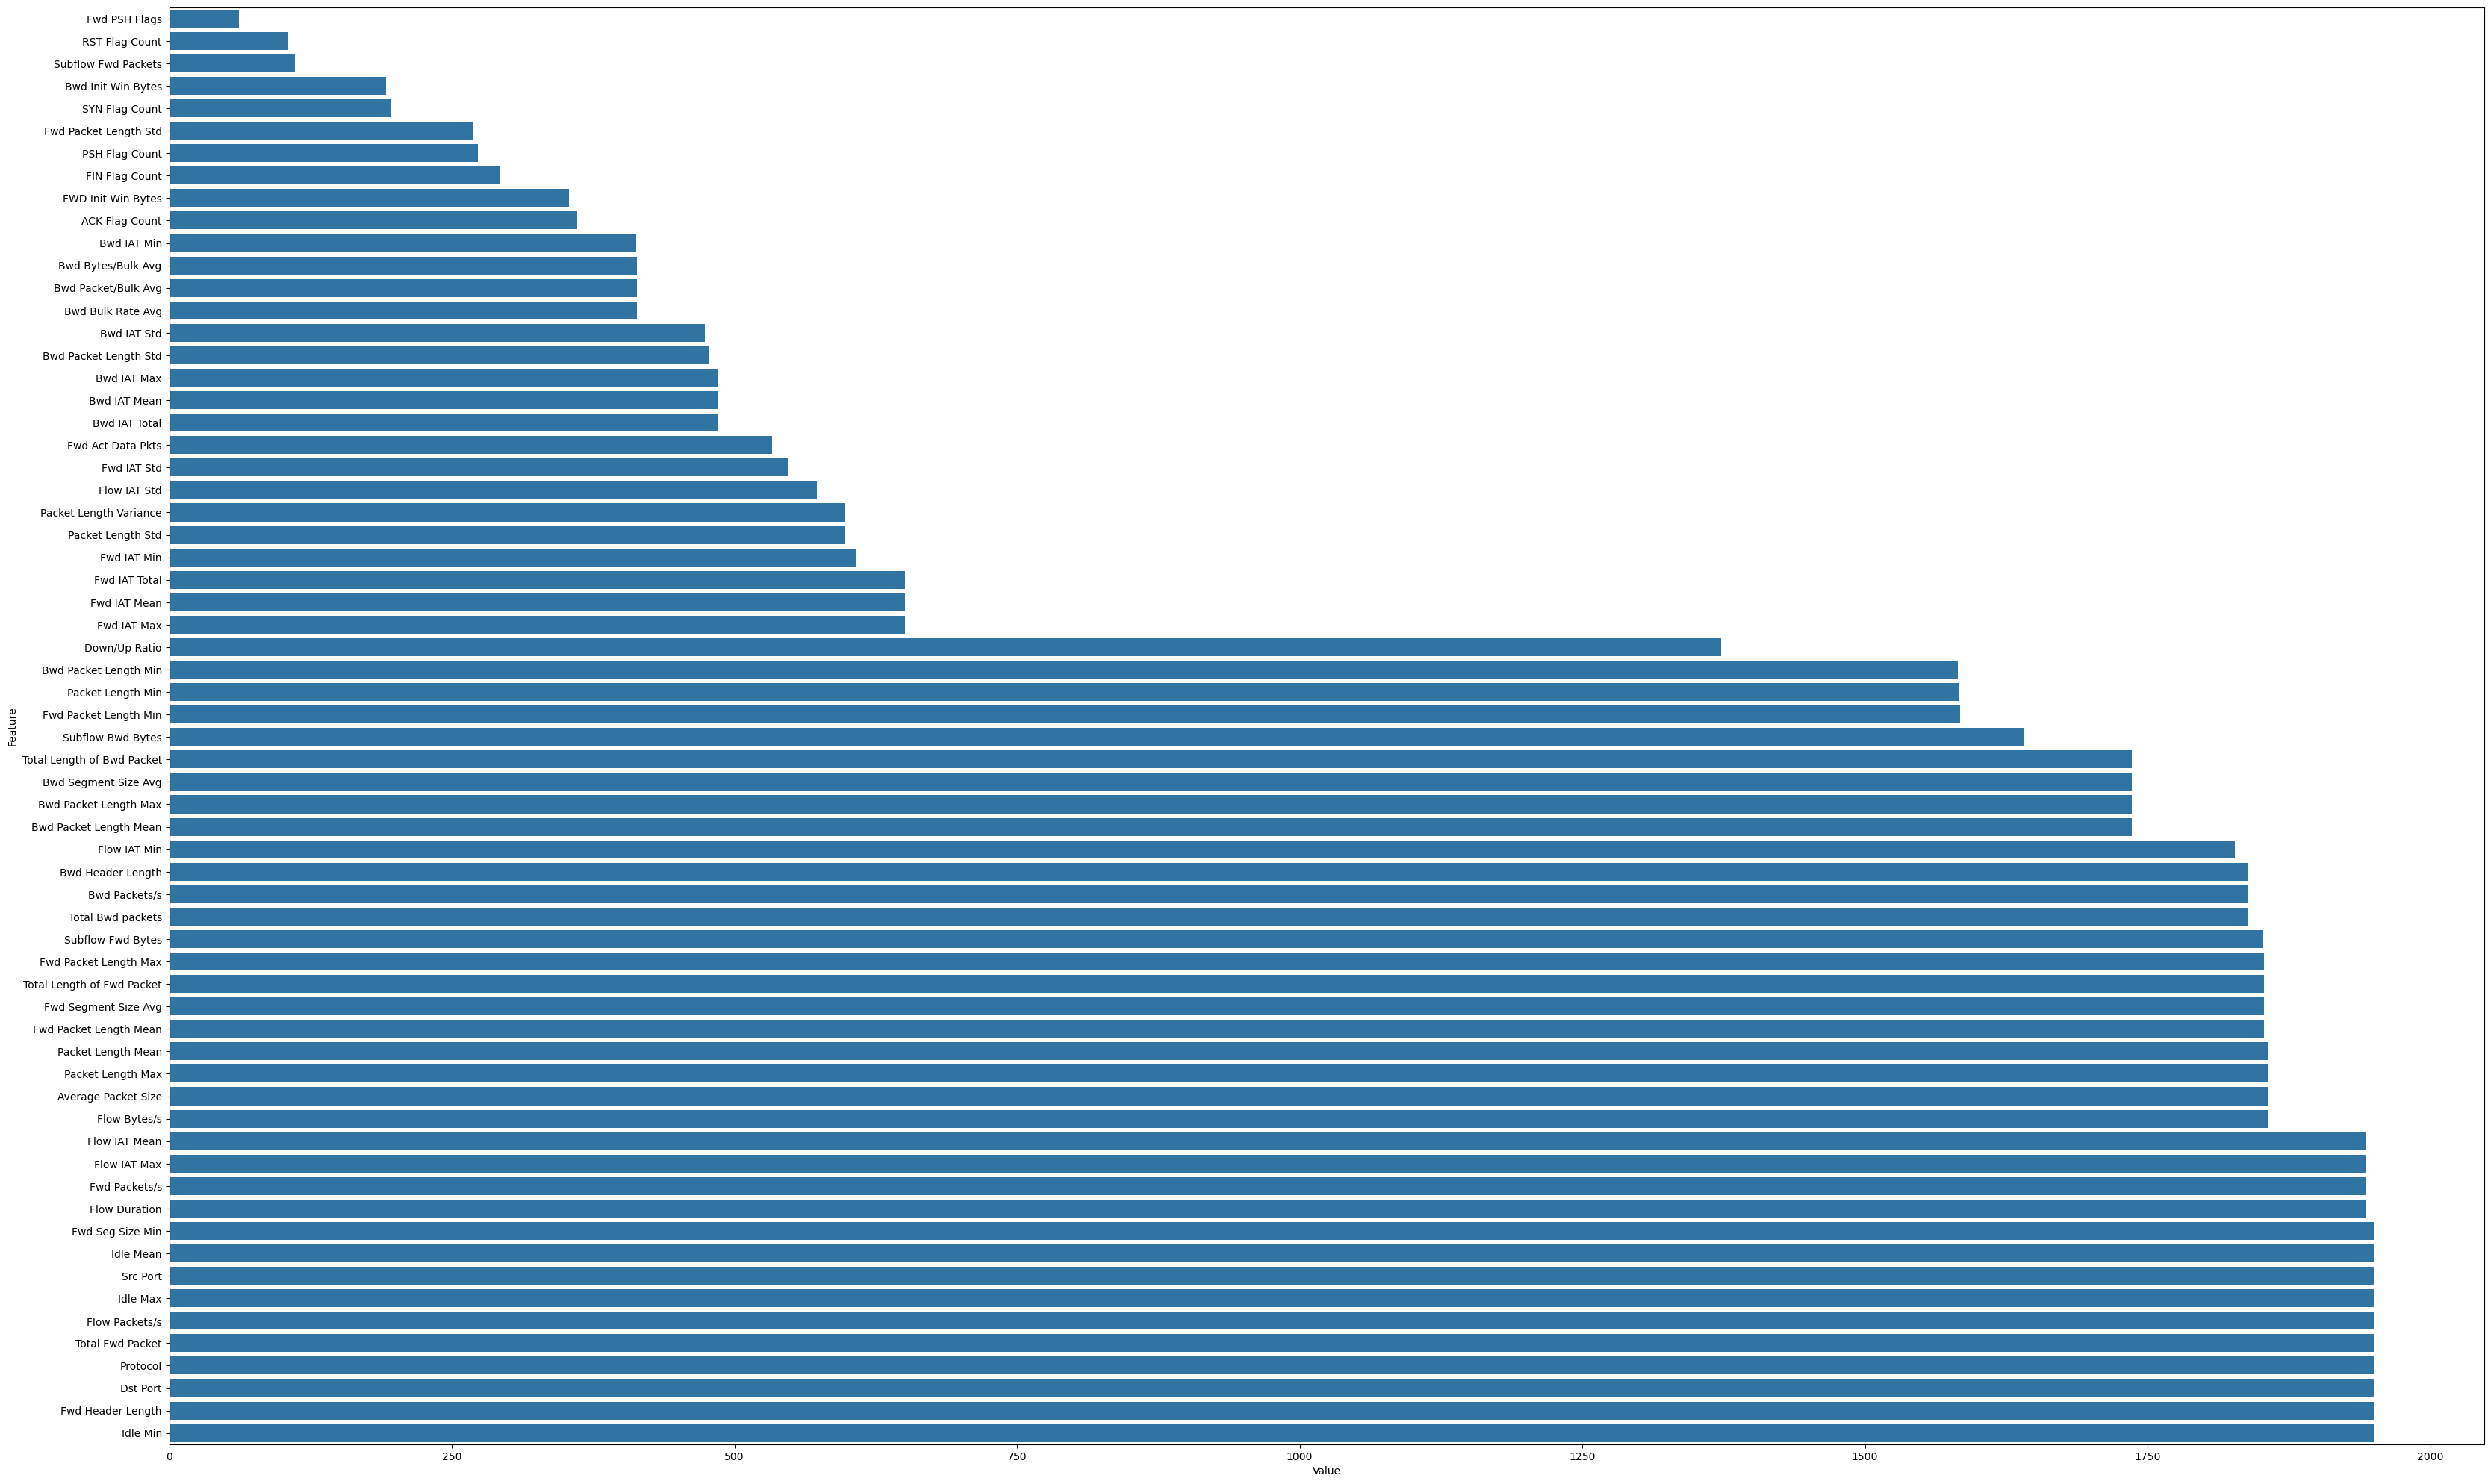

In [163]:
greater_than_zero_counts = {}
total_rows = len(Feb5)
for column in Feb5.columns:
    # Check if the column is numeric to avoid errors
    if pd.api.types.is_numeric_dtype(Feb5[column]):
        count = (Feb5[column] > 0).sum()
        greater_than_zero_counts[column] = count
greater_than_zero_counts = pd.DataFrame(greater_than_zero_counts.items(), columns=['Feature', 'Value'])
zero_counts = greater_than_zero_counts[greater_than_zero_counts['Value'] < total_rows*.01]
greater_than_zero_counts = greater_than_zero_counts[greater_than_zero_counts['Value'] > total_rows*.01].sort_values(by='Value')
plt.figure(figsize=(40,25))
sns.barplot(greater_than_zero_counts, y='Feature', x='Value')

In [164]:
zero_cols = zero_counts['Feature'].to_list()
Feb5 = Feb5.drop(columns=zero_cols)
zero_cols

['Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'URG Flag Count',
 'CWR Flag Count',
 'ECE Flag Count',
 'Fwd Bytes/Bulk Avg',
 'Fwd Packet/Bulk Avg',
 'Fwd Bulk Rate Avg',
 'Subflow Bwd Packets',
 'Active Mean',
 'Active Std',
 'Active Max',
 'Active Min',
 'Idle Std']

The above code removes columns that were 99%+ 0's from the dataframe. They will provide us no analytical value.

# Methodology for cutting columns
### Create groupings of columns that contain data deriving from the same information:

Group 1 - flags - All columns pretaining to flags

Group 2 - Fwd - Columns pertaining to the forward flow of information. 

Group 3 - Bwd - Columns pertaining to the backward flow of information. 

Group 4 - IAT - Column pertaining to the inter-arrival time (IAT). 

Group 5 - Idle/Active - Column pertaining to active vs idle time.

Group 6 - Flow - non-directional packet and flow data.

Group 7 - Misc - Catagorical data pertaining to IPs and 

### Create correlation heatmaps and identify most representitive columns:
Find columns that have around 90%+ correlation with other columns in the DF and choose to keep a single one that is MOST REPRESENTITIVE. This could mean that the column name is easiest to convoy, that one column is more robust than the other or that the column has the best average correlation across highly correlated columns.

### Drop the represented columns, create a new heatmap, & repeat
We remove the columns that we have identifyed as being represented. This let's us remove noise and rerun our correlation matrix. If there is still columns with around 90% correlation, repeat the process of identifying representitive columns and removing noise until there is no more high representation in the group. 

### Create list of all remaining columns.

<Axes: >

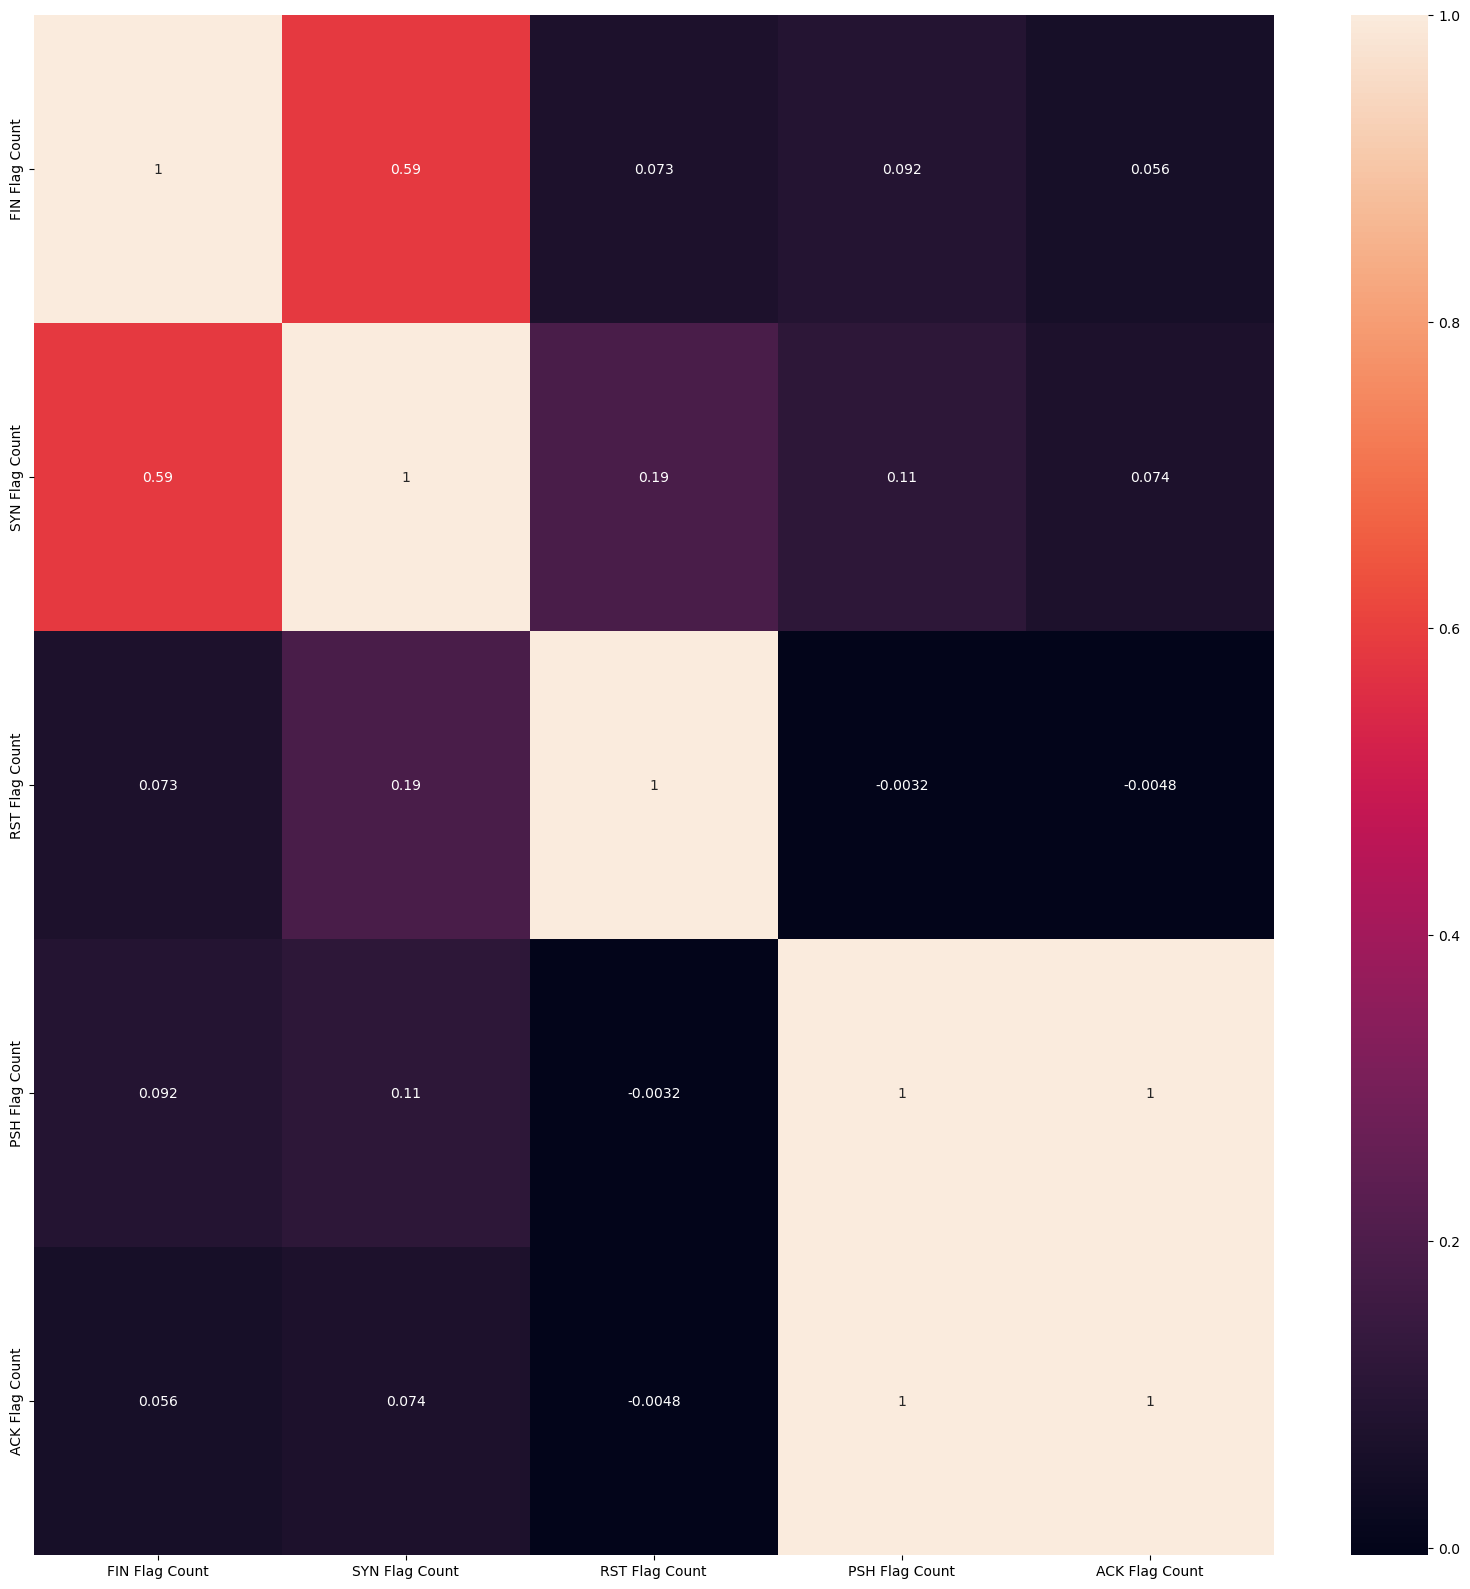

In [165]:
flags = Feb5[['Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'URG Flag Count',
 'CWR Flag Count',
 'ECE Flag Count'
              'FIN Flag Count', 
              'SYN Flag Count', 
              'RST Flag Count', 
              'PSH Flag Count', 
              'ACK Flag Count']]
plt.figure(figsize=(20,20))
sns.heatmap(flags.corr(), annot=True)

There is perfect correlation across PSH Flag count and ACK Flag Count. PSH is the easier column to understand, so that is the one kept.

In [166]:
flags = flags.drop(columns=('ACK Flag Count'))
flag_cols = flags.columns
flag_cols = flag_cols.to_list()
flag_cols

['FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count']

## Data Flowing Forwards

<Axes: >

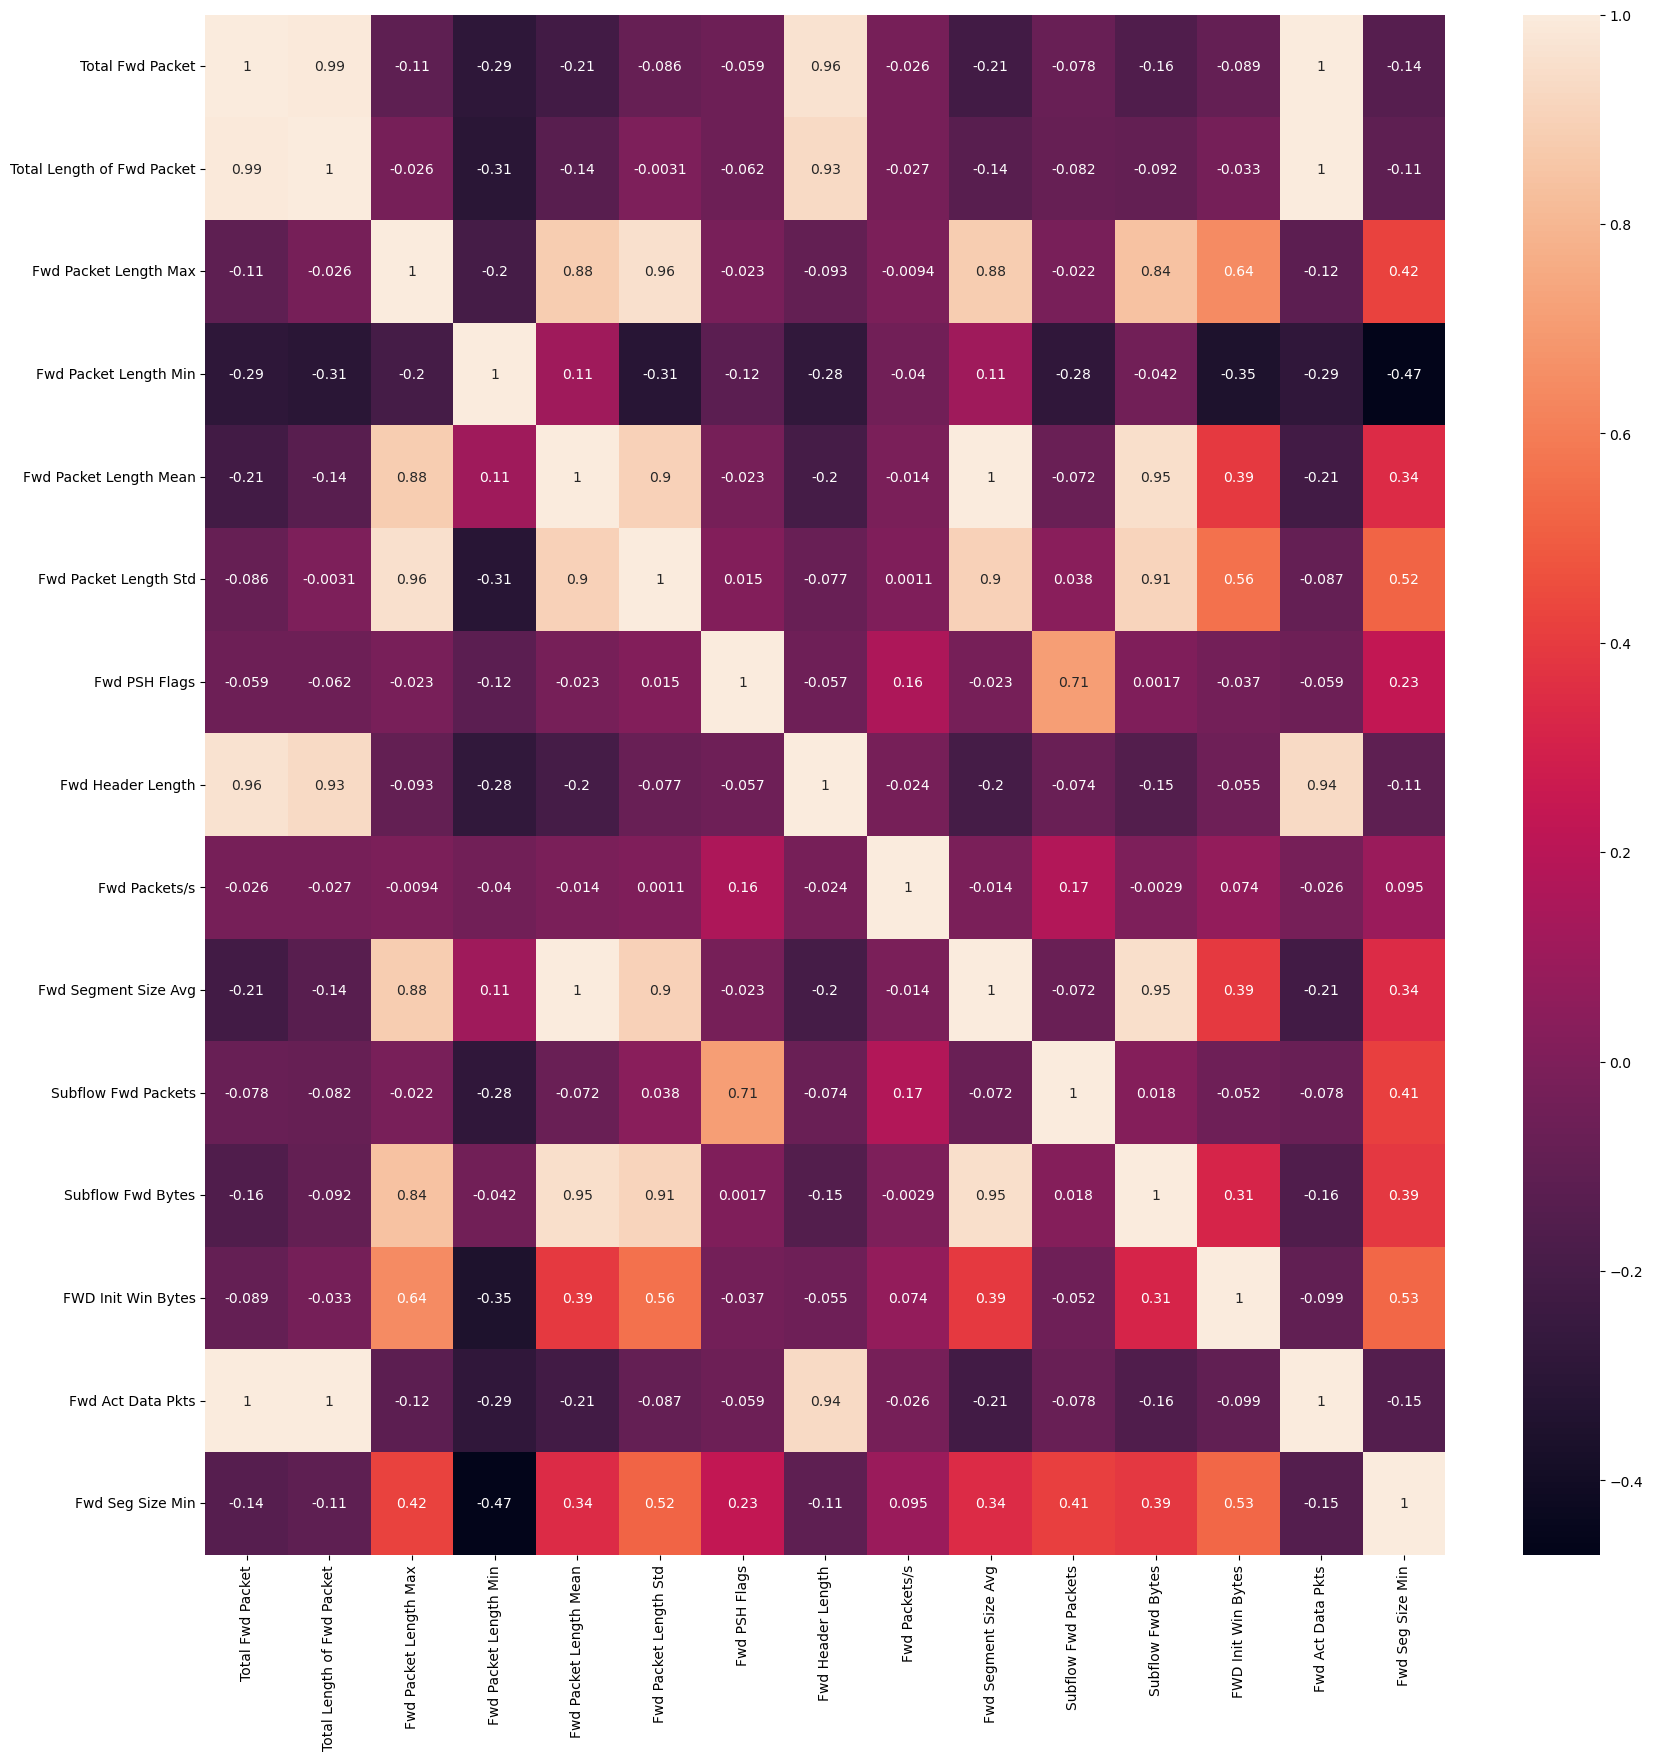

In [167]:
Feb5_Fwd = Feb5[['Total Fwd Packet',
                'Total Length of Fwd Packet',
                'Fwd Packet Length Max', 
                'Fwd Packet Length Min', 
                'Fwd Packet Length Mean', 
                'Fwd Packet Length Std', 
                'Fwd PSH Flags',  
                'Fwd Header Length', 
                'Fwd Packets/s', 
                'Fwd Segment Size Avg', 
                'Subflow Fwd Packets', 
                'Subflow Fwd Bytes', 
                'FWD Init Win Bytes', 
                'Fwd Act Data Pkts', 
                'Fwd Seg Size Min']]
plt.figure(figsize=(20,20))
sns.heatmap(Feb5_Fwd.corr(), annot=True)

Column to keep: 'Total Fwd Packet' - Reason: Easy Column to identify and hast almost perfect representation of 3 columns.

Resulting dropped columns: 'Total Length of Fwd Packet', 'Fwd Header Length', 'Fwd Act Data Pkts'

<Axes: >

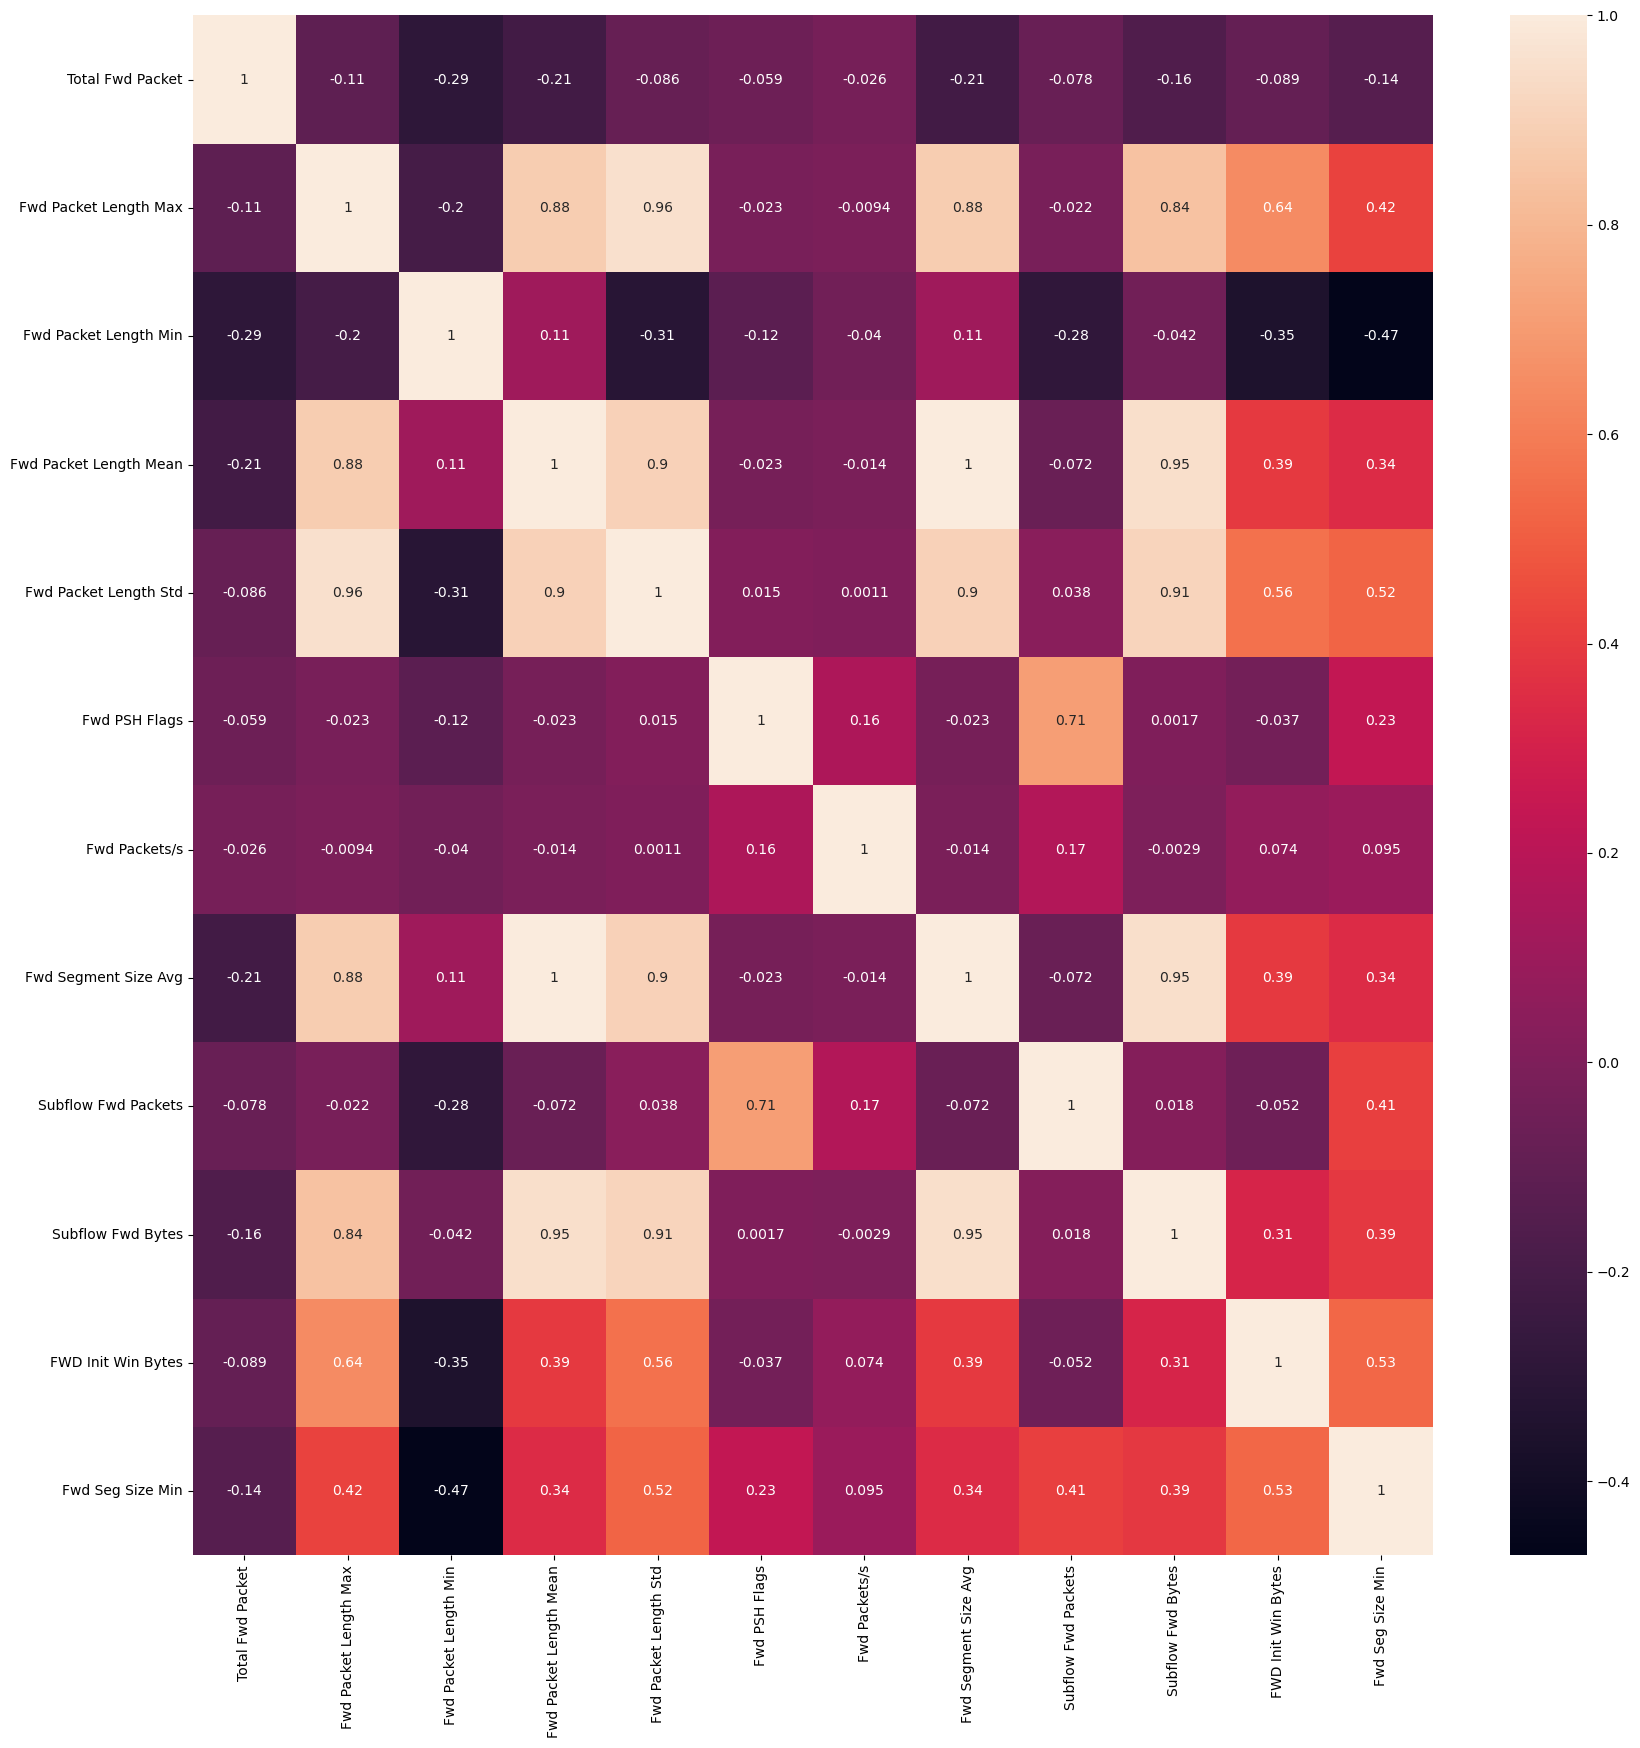

In [168]:
Feb5_Fwd = Feb5_Fwd.drop(columns=['Total Length of Fwd Packet', 'Fwd Header Length', 'Fwd Act Data Pkts'])
plt.figure(figsize=(20,20))
sns.heatmap(Feb5_Fwd.corr(), annot=True)

Column to keep: Fwd Packet Length Std - Reason: Captures 4 Columns over 90%

Resulting dropped columns: 'Fwd Packet Length Max', 'Fwd Packet Length Mean', 'Fwd Segment Size Avg', 'Subflow Fwd Bytes'

<Axes: >

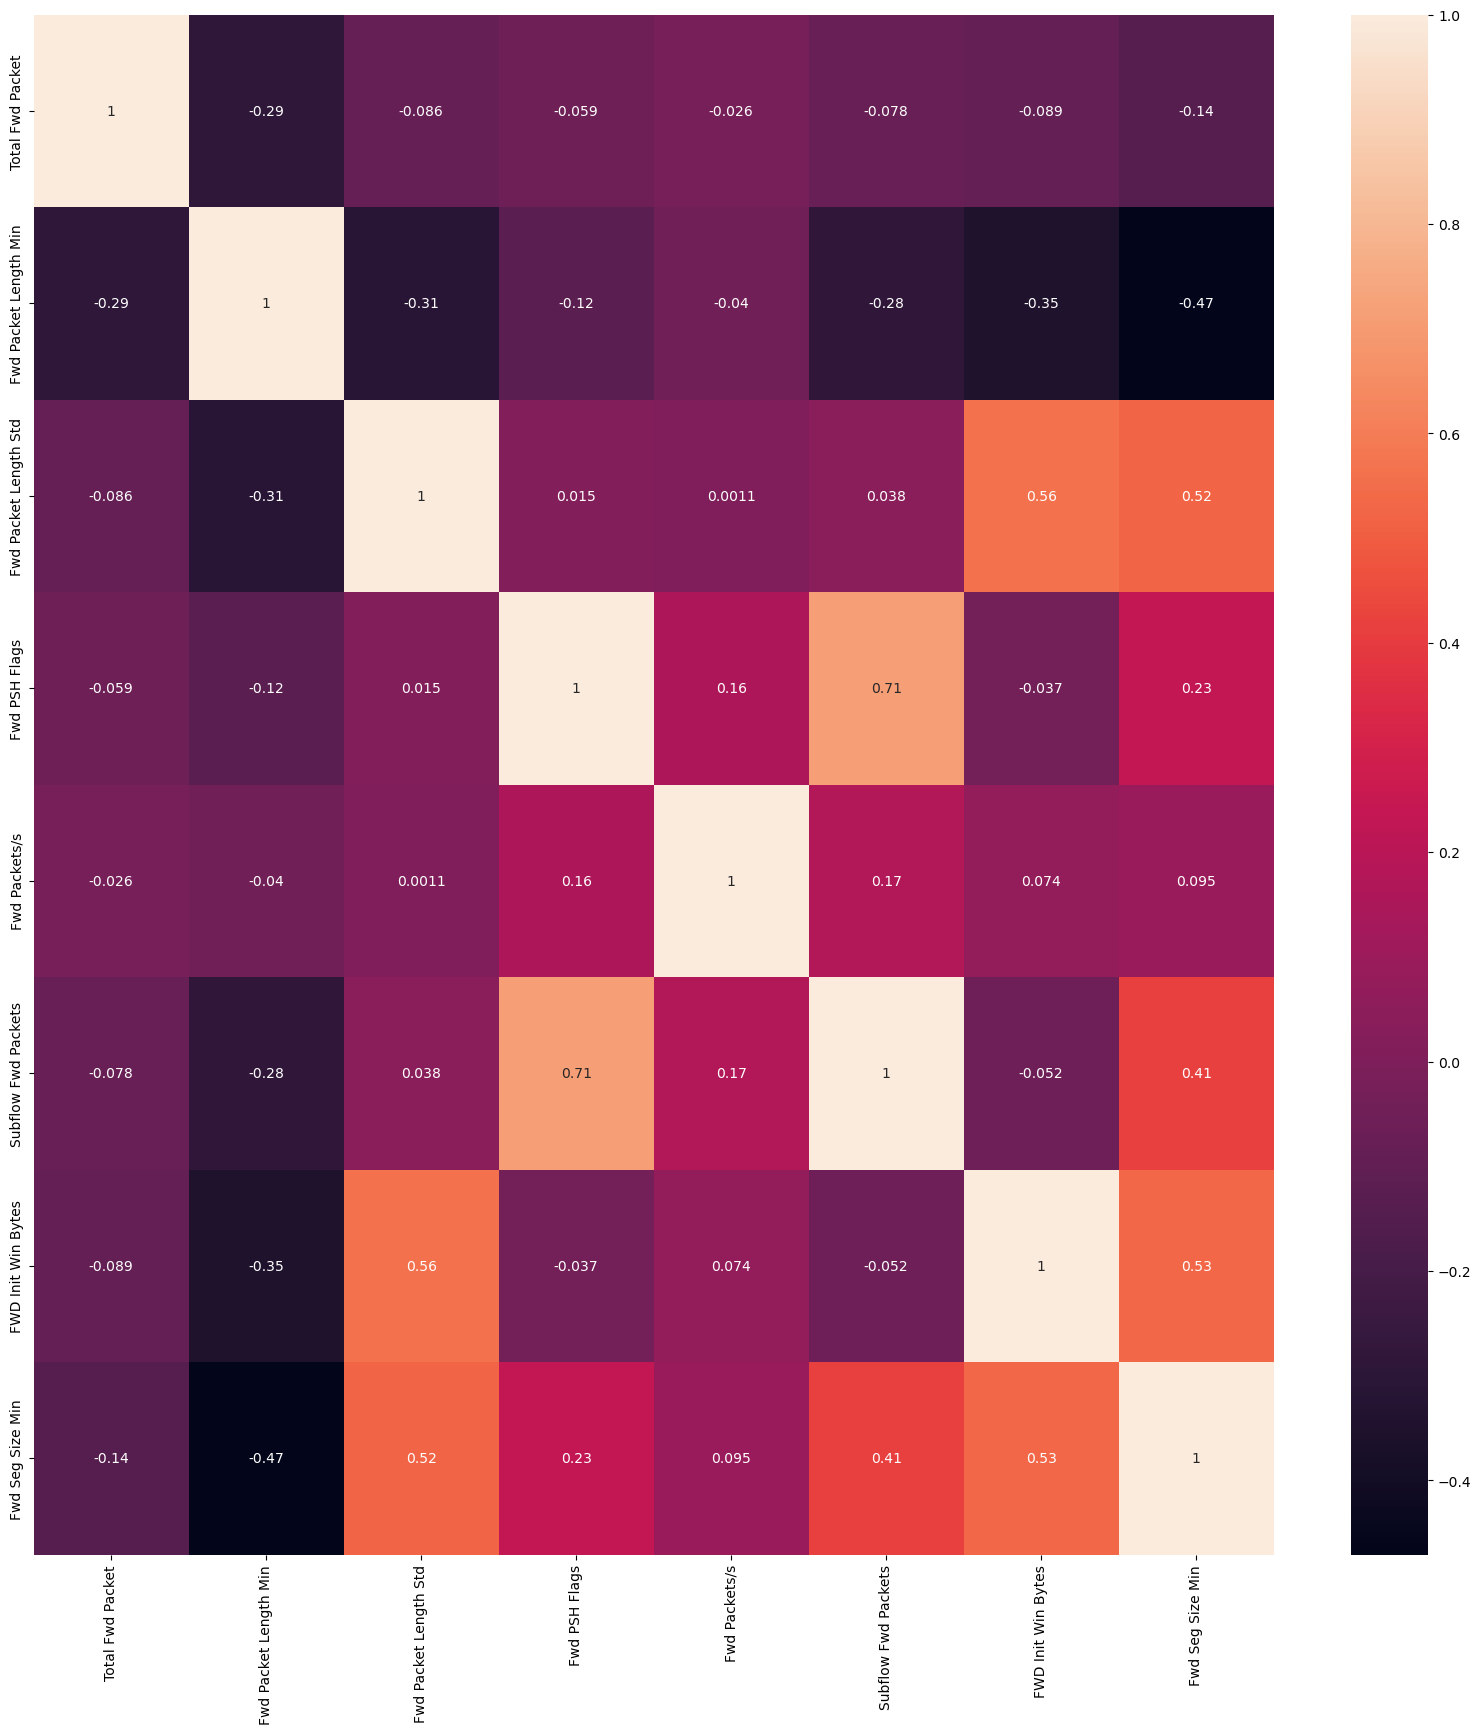

In [169]:
Feb5_Fwd = Feb5_Fwd.drop(columns=['Fwd Packet Length Max', 'Fwd Packet Length Mean', 'Fwd Segment Size Avg', 'Subflow Fwd Bytes'])
plt.figure(figsize=(20,20))
sns.heatmap(Feb5_Fwd.corr(), annot=True)

Nothing over 85% means we can save a list of these columns to create our representitive database and compare correlation between groups.

In [170]:
Fwd_Cols = Feb5_Fwd.columns
Fwd_Cols = Fwd_Cols.to_list()
Fwd_Cols

['Total Fwd Packet',
 'Fwd Packet Length Min',
 'Fwd Packet Length Std',
 'Fwd PSH Flags',
 'Fwd Packets/s',
 'Subflow Fwd Packets',
 'FWD Init Win Bytes',
 'Fwd Seg Size Min']

## Data Flowing Backwards

<Axes: >

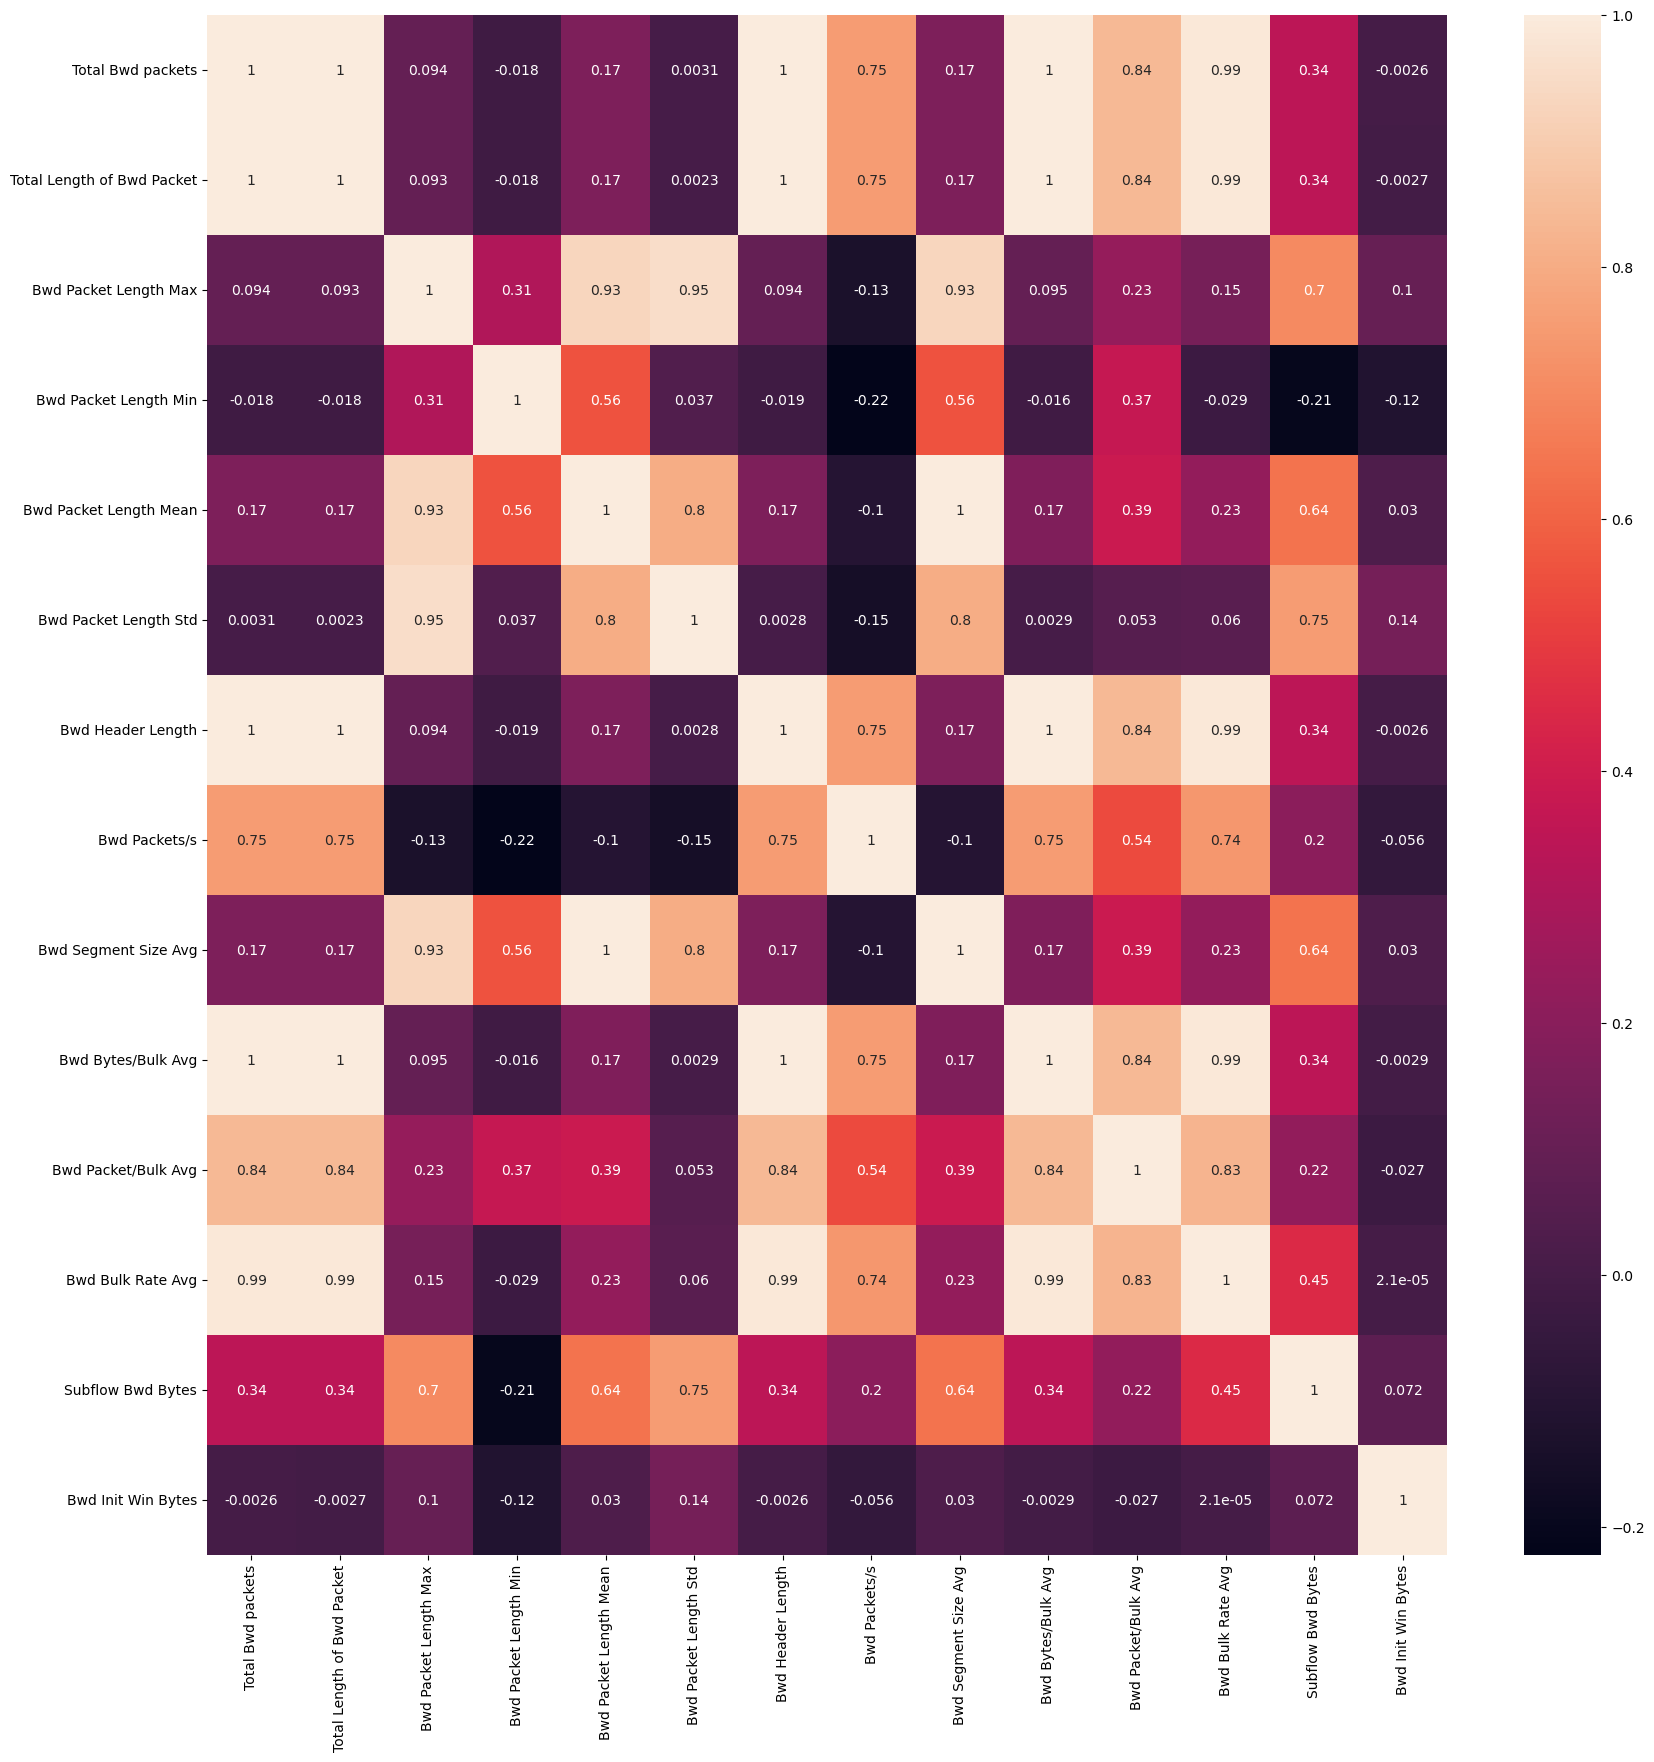

In [171]:
Feb5_Bwd = Feb5[['Total Bwd packets', 
      'Total Length of Bwd Packet', 
      'Bwd Packet Length Max', 
      'Bwd Packet Length Min', 
      'Bwd Packet Length Mean', 
      'Bwd Packet Length Std',   
      'Bwd Header Length',
      'Bwd Packets/s', 
      'Bwd Segment Size Avg', 
      'Bwd Bytes/Bulk Avg', 
      'Bwd Packet/Bulk Avg', 
      'Bwd Bulk Rate Avg', 
      'Subflow Bwd Bytes', 
      'Bwd Init Win Bytes']]
plt.figure(figsize=(20,20))
sns.heatmap(Feb5_Bwd.corr(), annot=True)

Column to Keep: 'Total Bwd packets'

Resulting Columns dropped: 'Total Length of Bwd Packet', 'Bwd Header Length', 'Bwd Bytes/Bulk Avg', 'Bwd Bulk Rate Avg'

<Axes: >

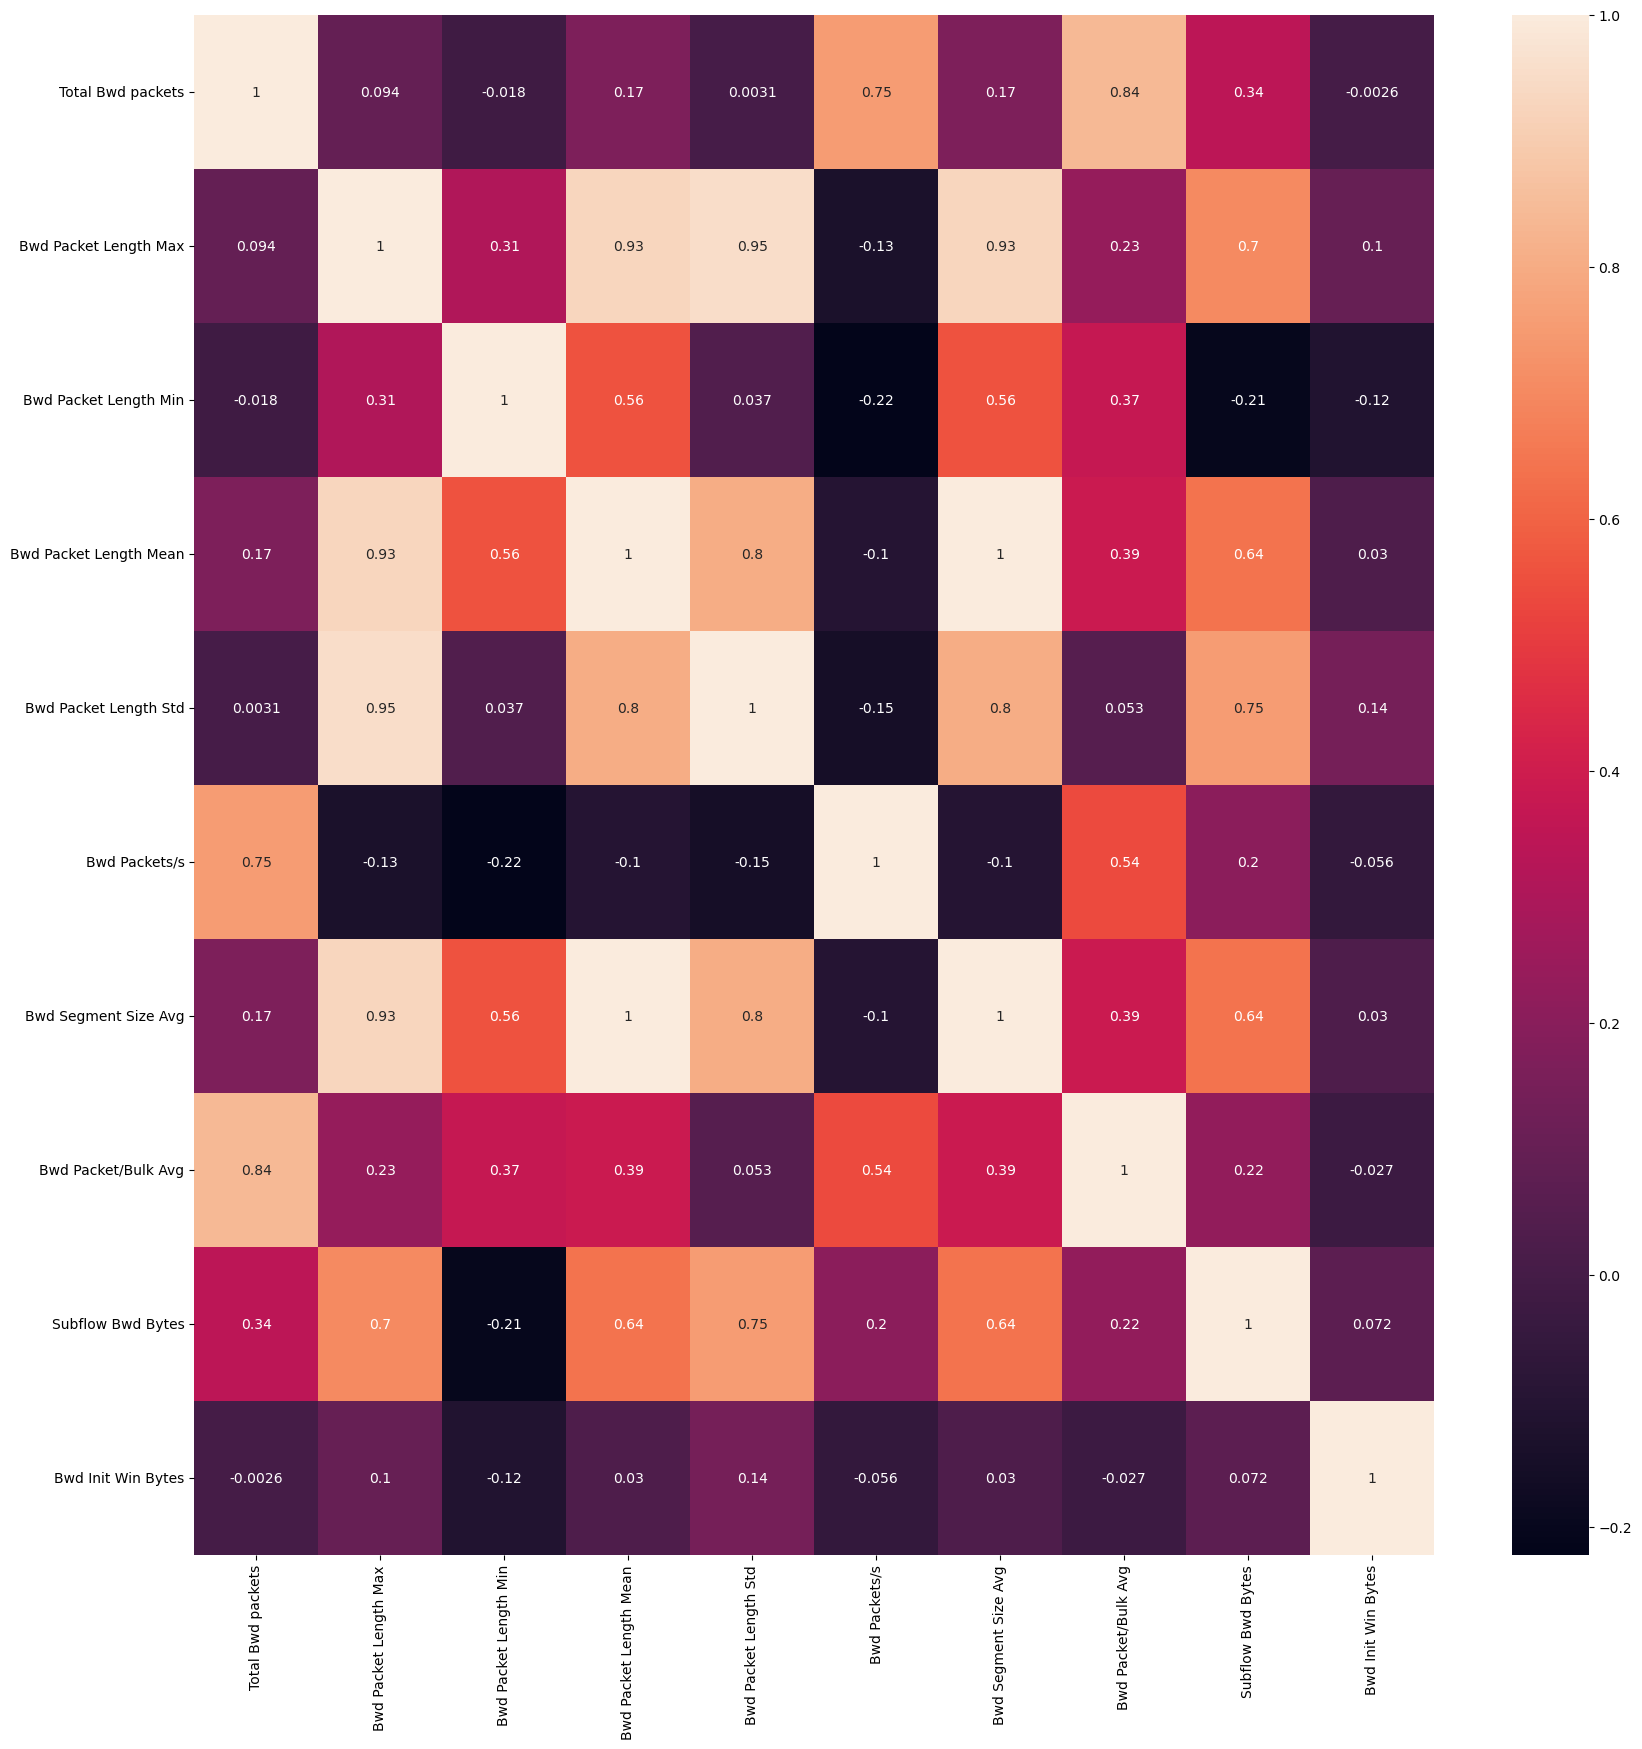

In [172]:
Feb5_Bwd = Feb5_Bwd.drop(columns=['Total Length of Bwd Packet', 'Bwd Header Length', 'Bwd Bytes/Bulk Avg', 'Bwd Bulk Rate Avg'])
plt.figure(figsize=(20,20))
sns.heatmap(Feb5_Bwd.corr(), annot=True)

Column to keep: 'Bwd Packet Length Max' - Reason: captures 3 columes at over 93%

Resulting Columns dropped: 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Bwd Segment Size Avg'

<Axes: >

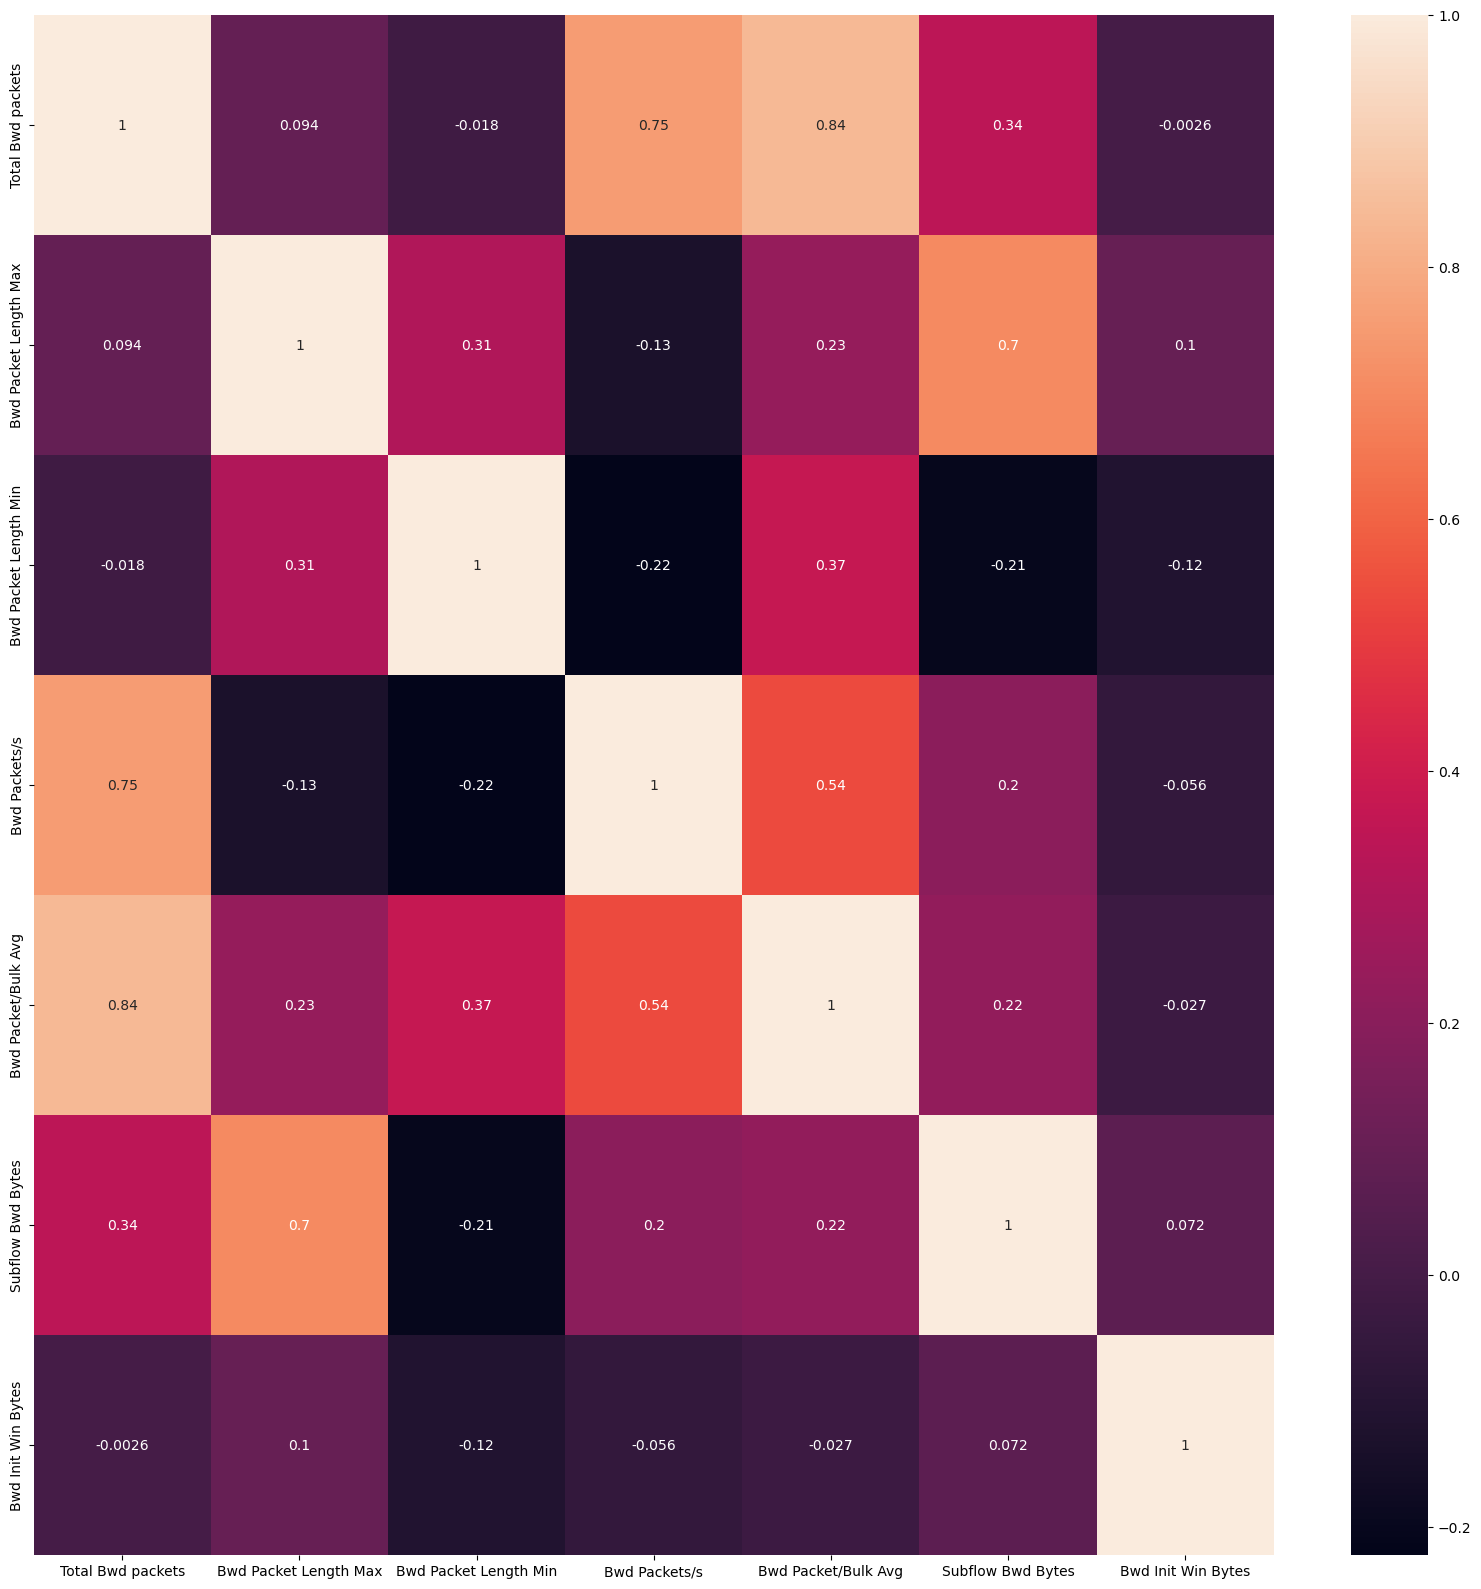

In [173]:
Feb5_Bwd = Feb5_Bwd.drop(columns=['Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Bwd Segment Size Avg'])
plt.figure(figsize=(20,20))
sns.heatmap(Feb5_Bwd.corr(), annot=True)

Column to drop: 'Bwd Packet/Bulk Avg' - Reason: While only 84% correlated this column has mostly 0 values.

In [174]:
#while technically below the 85% thershold, I still think it is safe to drop 'Bwd Packet/Bulk Avg'
Feb5_Bwd = Feb5_Bwd.drop(columns='Bwd Packet/Bulk Avg')

In [175]:
Bwd_cols = Feb5_Bwd.columns.to_list()

## Inter-Arrival Time (IAT)

<Axes: >

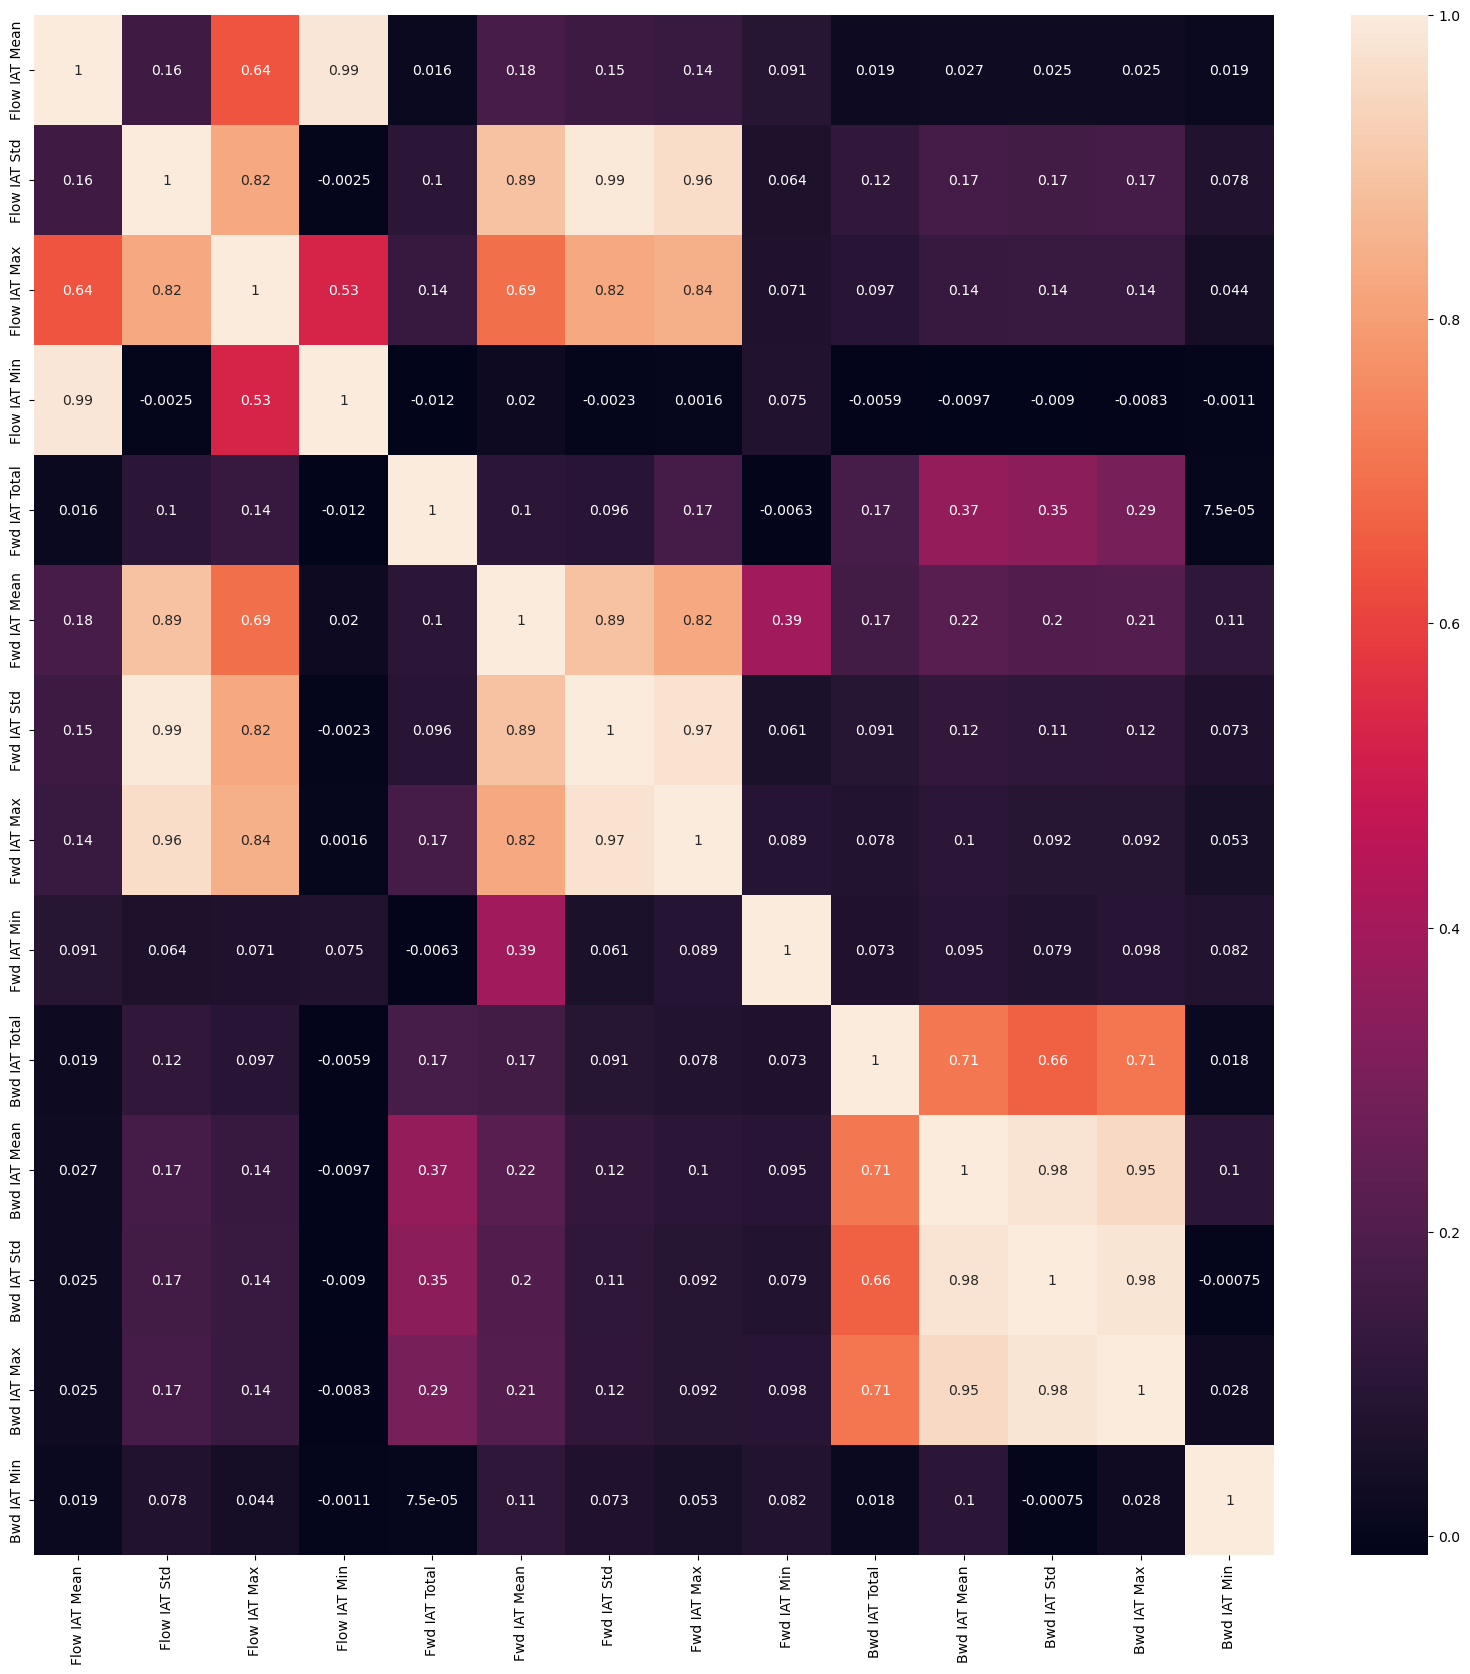

In [176]:
Feb5_IAT = Feb5[['Flow IAT Mean', 
                 'Flow IAT Std', 
                 'Flow IAT Max', 
                 'Flow IAT Min', 
                 'Fwd IAT Total', 
                 'Fwd IAT Mean', 
                 'Fwd IAT Std', 
                 'Fwd IAT Max', 
                 'Fwd IAT Min', 
                 'Bwd IAT Total', 
                 'Bwd IAT Mean', 
                 'Bwd IAT Std',
                 'Bwd IAT Max', 
                 'Bwd IAT Min']]
plt.figure(figsize=(20,20))
sns.heatmap(Feb5_IAT.corr(),annot=True)

Column to keep: 'Bwd IAT Std' - Reason: captures 2 columns at 98%+
Reulsting dropped columns: 'Bwd IAT Mean', 'Bwd IAT Max'

<Axes: >

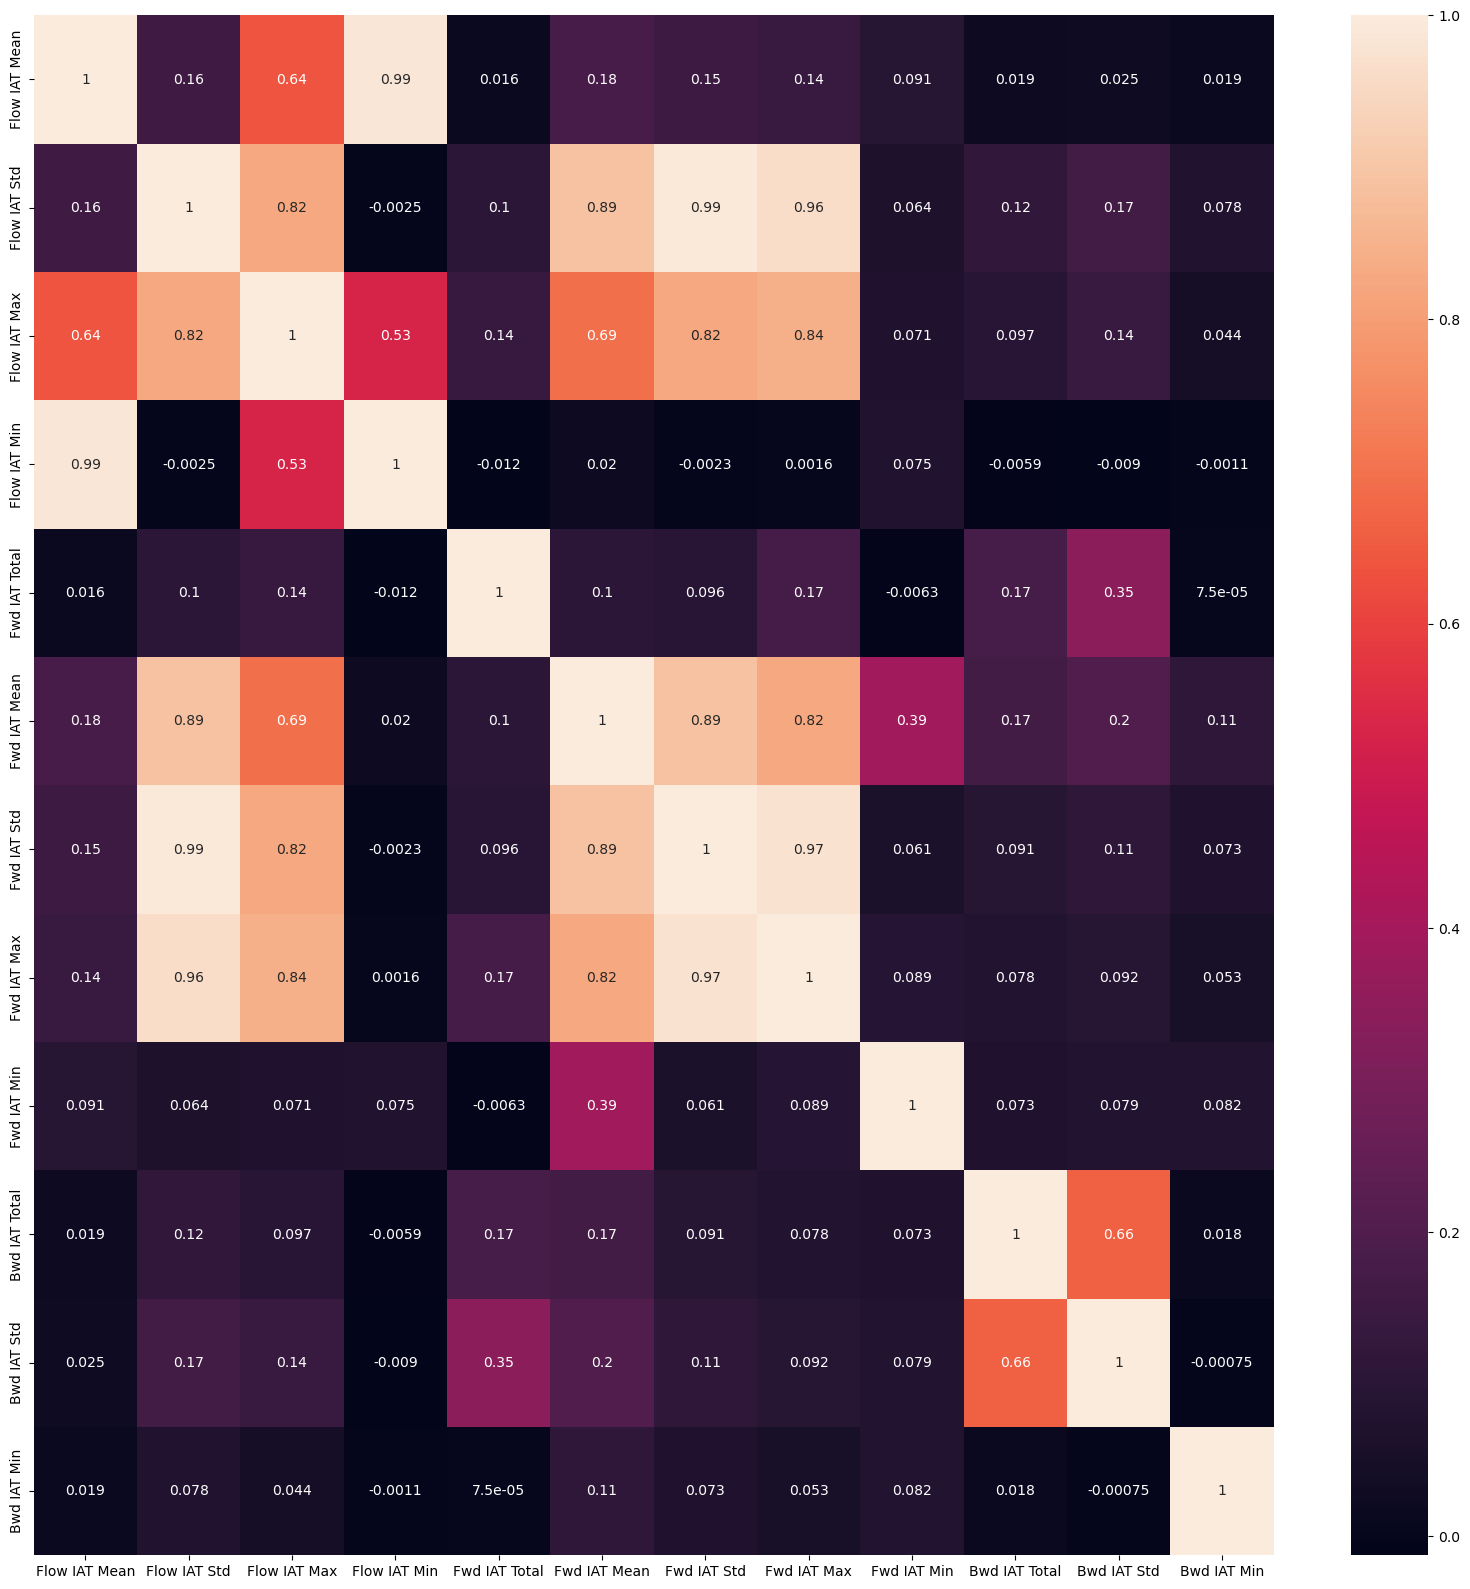

In [177]:
Feb5_IAT = Feb5_IAT.drop(columns=['Bwd IAT Mean', 'Bwd IAT Max'])
plt.figure(figsize=(20,20))
sns.heatmap(Feb5_IAT.corr(), annot=True)

Column to keep: 'Flow IAT Std' - Reason: captures 3 columns at 89%+
Resulting dropped columns: 'Fwd IAT Mean', 'Fwd IAT Std', 'Forward IAT Max'

<Axes: >

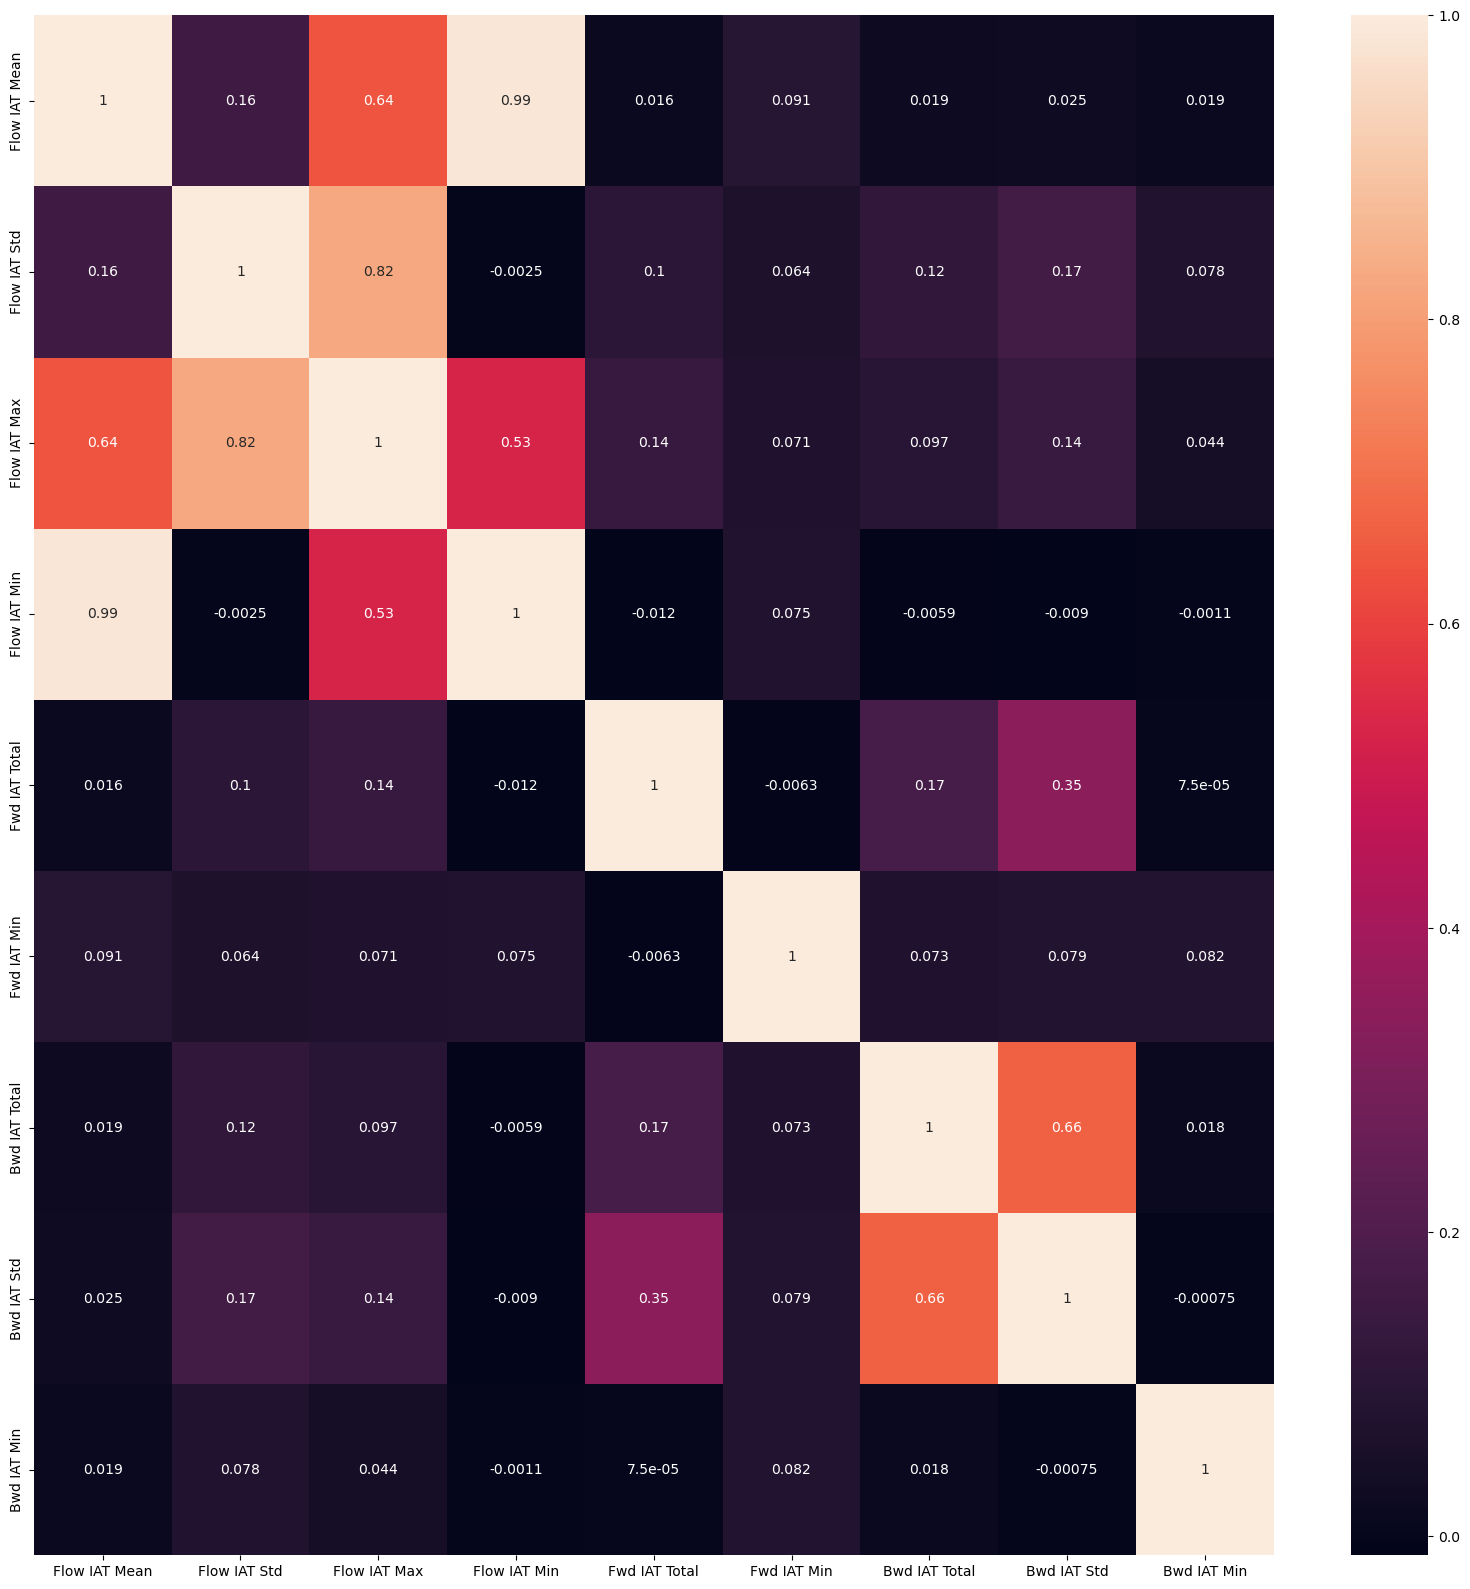

In [178]:
Feb5_IAT = Feb5_IAT.drop(columns=['Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max'])
plt.figure(figsize=(20,20))
sns.heatmap(Feb5_IAT.corr(), annot=True)

Columns to drop: 

'Flow IAT Mean' - Reason 99% represented by 'Flow IAT Min' with more correlation to other columns.
 'Flow IAT Max' - Reason: 82% represented in one column and over 50% in 2 others. I believe the other 2 columns would push representation over 90%

<Axes: >

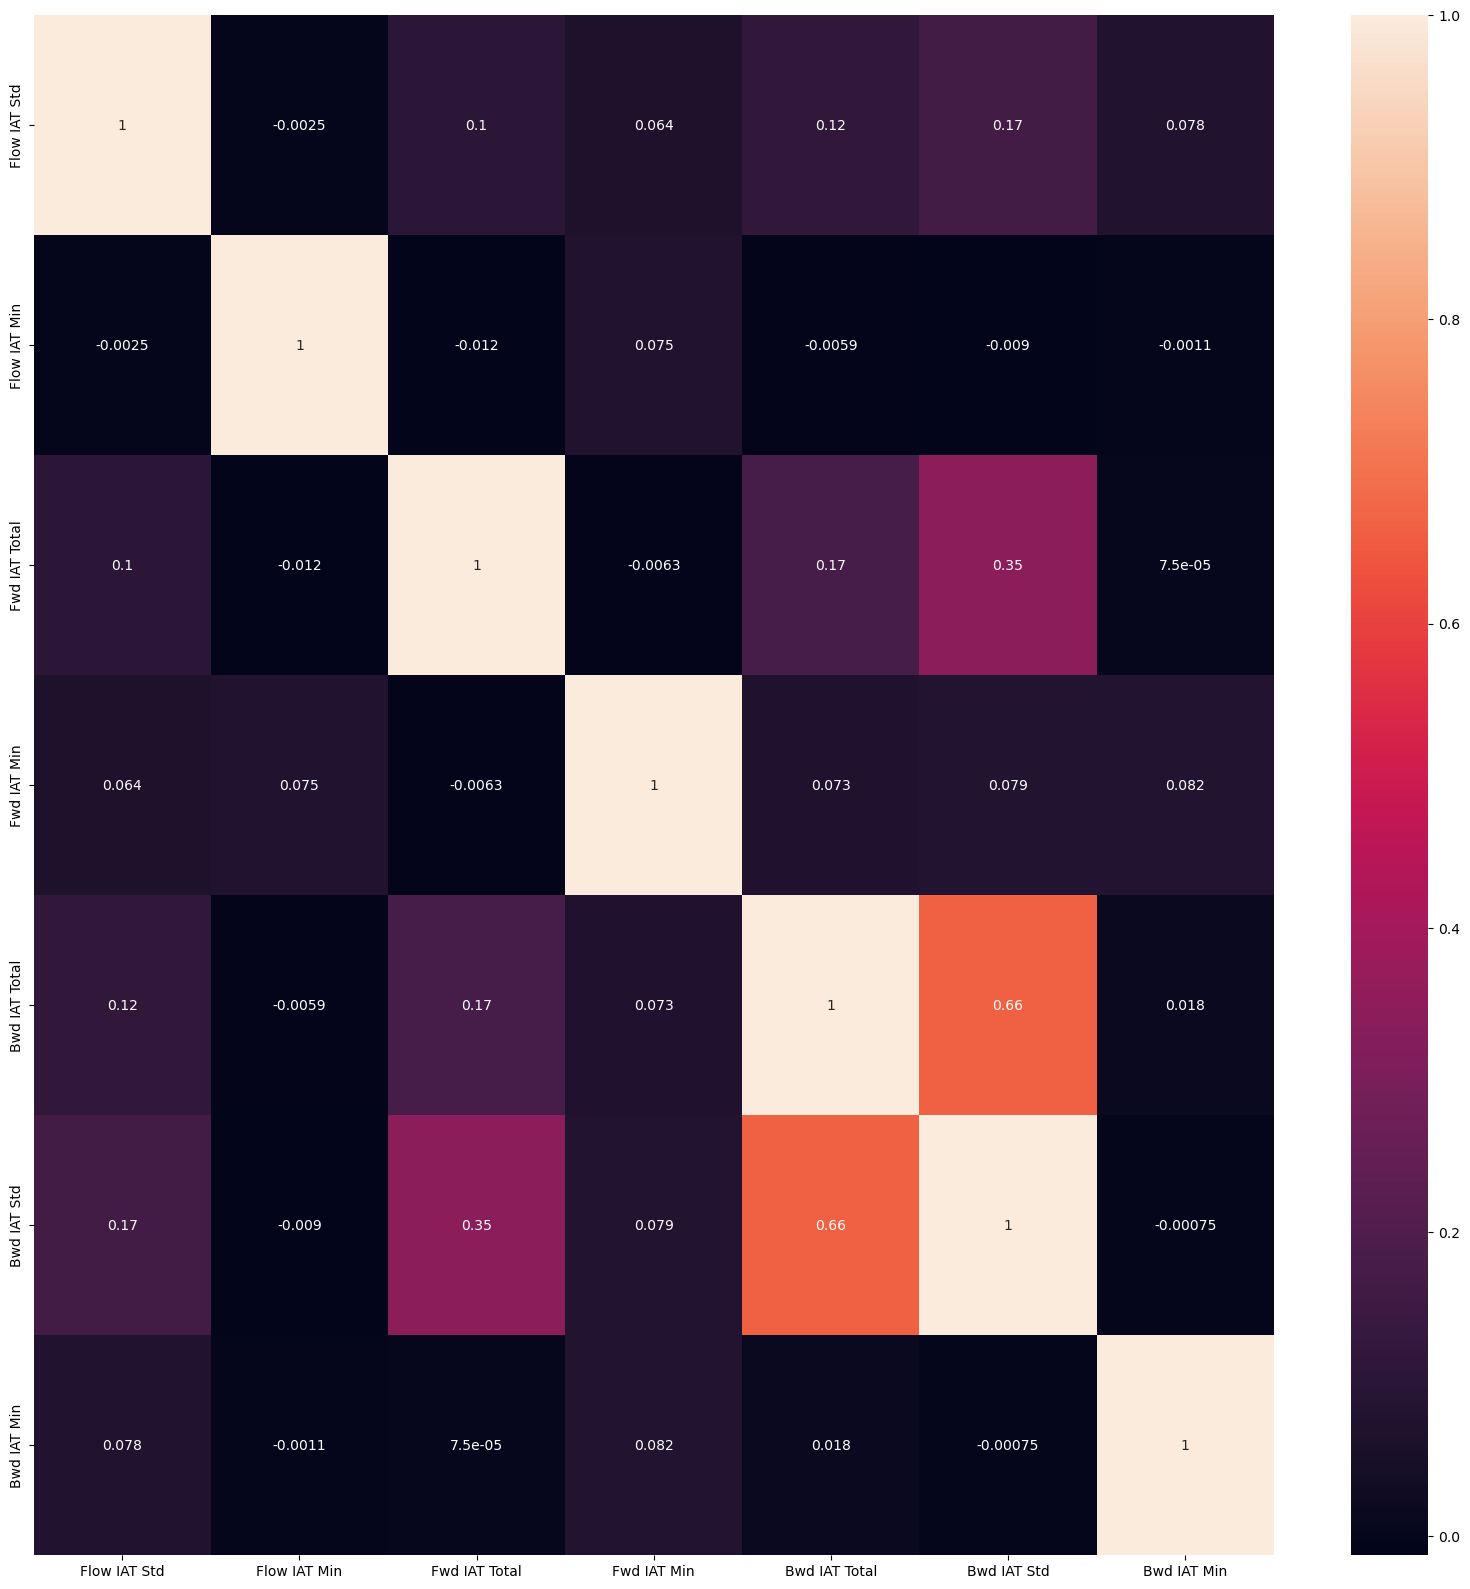

In [179]:
Feb5_IAT = Feb5_IAT.drop(columns=['Flow IAT Mean', 'Flow IAT Max'])
plt.figure(figsize=(20,20))
sns.heatmap(Feb5_IAT.corr(), annot=True)

In [180]:
IAT_cols = Feb5_IAT.columns.to_list()
IAT_cols

['Flow IAT Std',
 'Flow IAT Min',
 'Fwd IAT Total',
 'Fwd IAT Min',
 'Bwd IAT Total',
 'Bwd IAT Std',
 'Bwd IAT Min']

## Active/Idle 

Note: Active times were 99% 0's and removed from the data earlier

<Axes: >

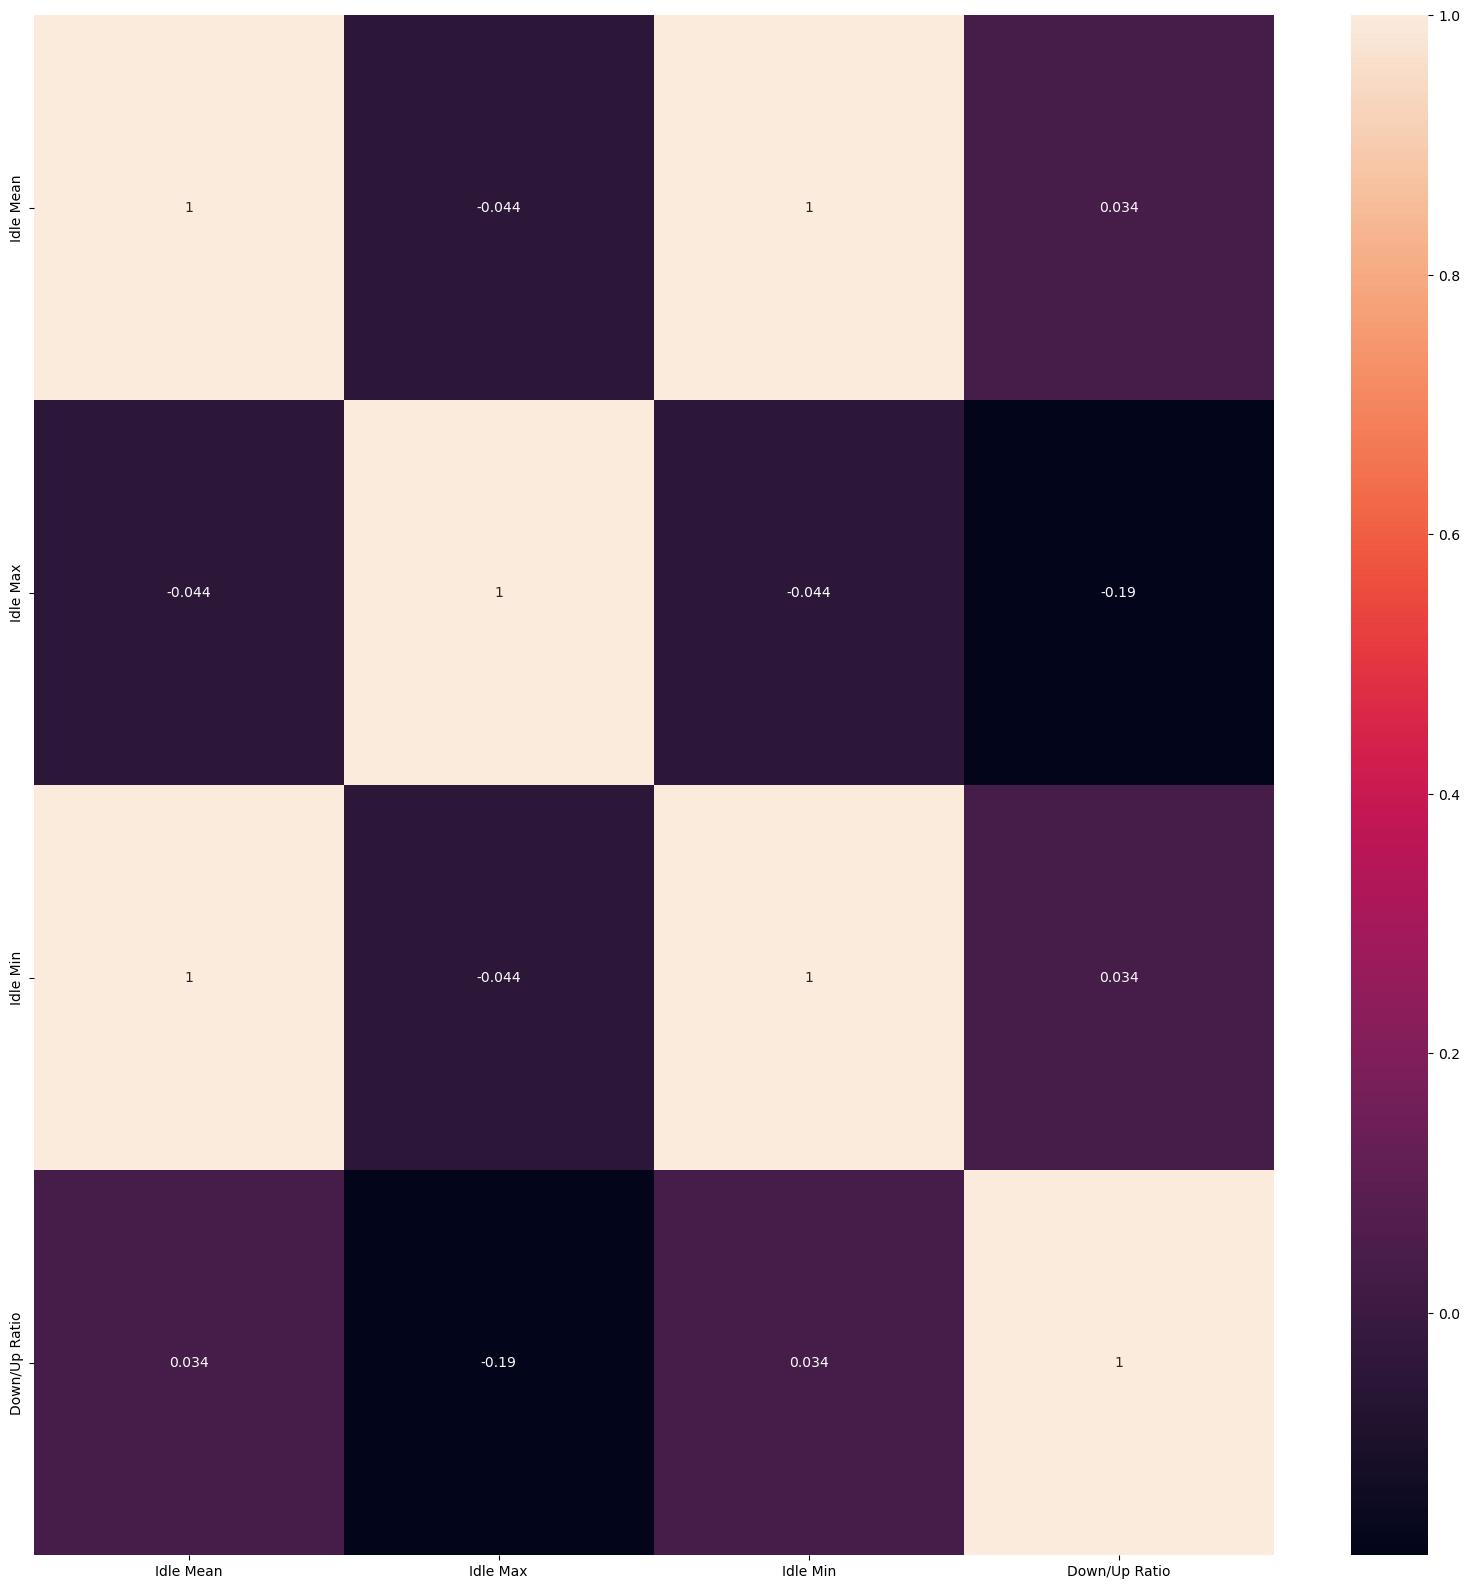

In [181]:
Feb5_activity = Feb5[['Idle Mean',
                    'Idle Max',
                    'Idle Min',
                    'Down/Up Ratio']]
plt.figure(figsize=(20,20))
sns.heatmap(Feb5_activity.corr(),annot=True)

Column to drop: 'Idle Mean' - Reason: 'Idle Min' and 'Idle Mean' are perfectly correlated. Mean is a better understood descriptive stat, so it stays.

In [182]:
Feb5_activity = Feb5_activity.drop(columns=['Idle Min'])
activity_cols = Feb5_activity.columns.to_list()
activity_cols

['Idle Mean', 'Idle Max', 'Down/Up Ratio']

## Flow & Non-Directional Packets

<Axes: >

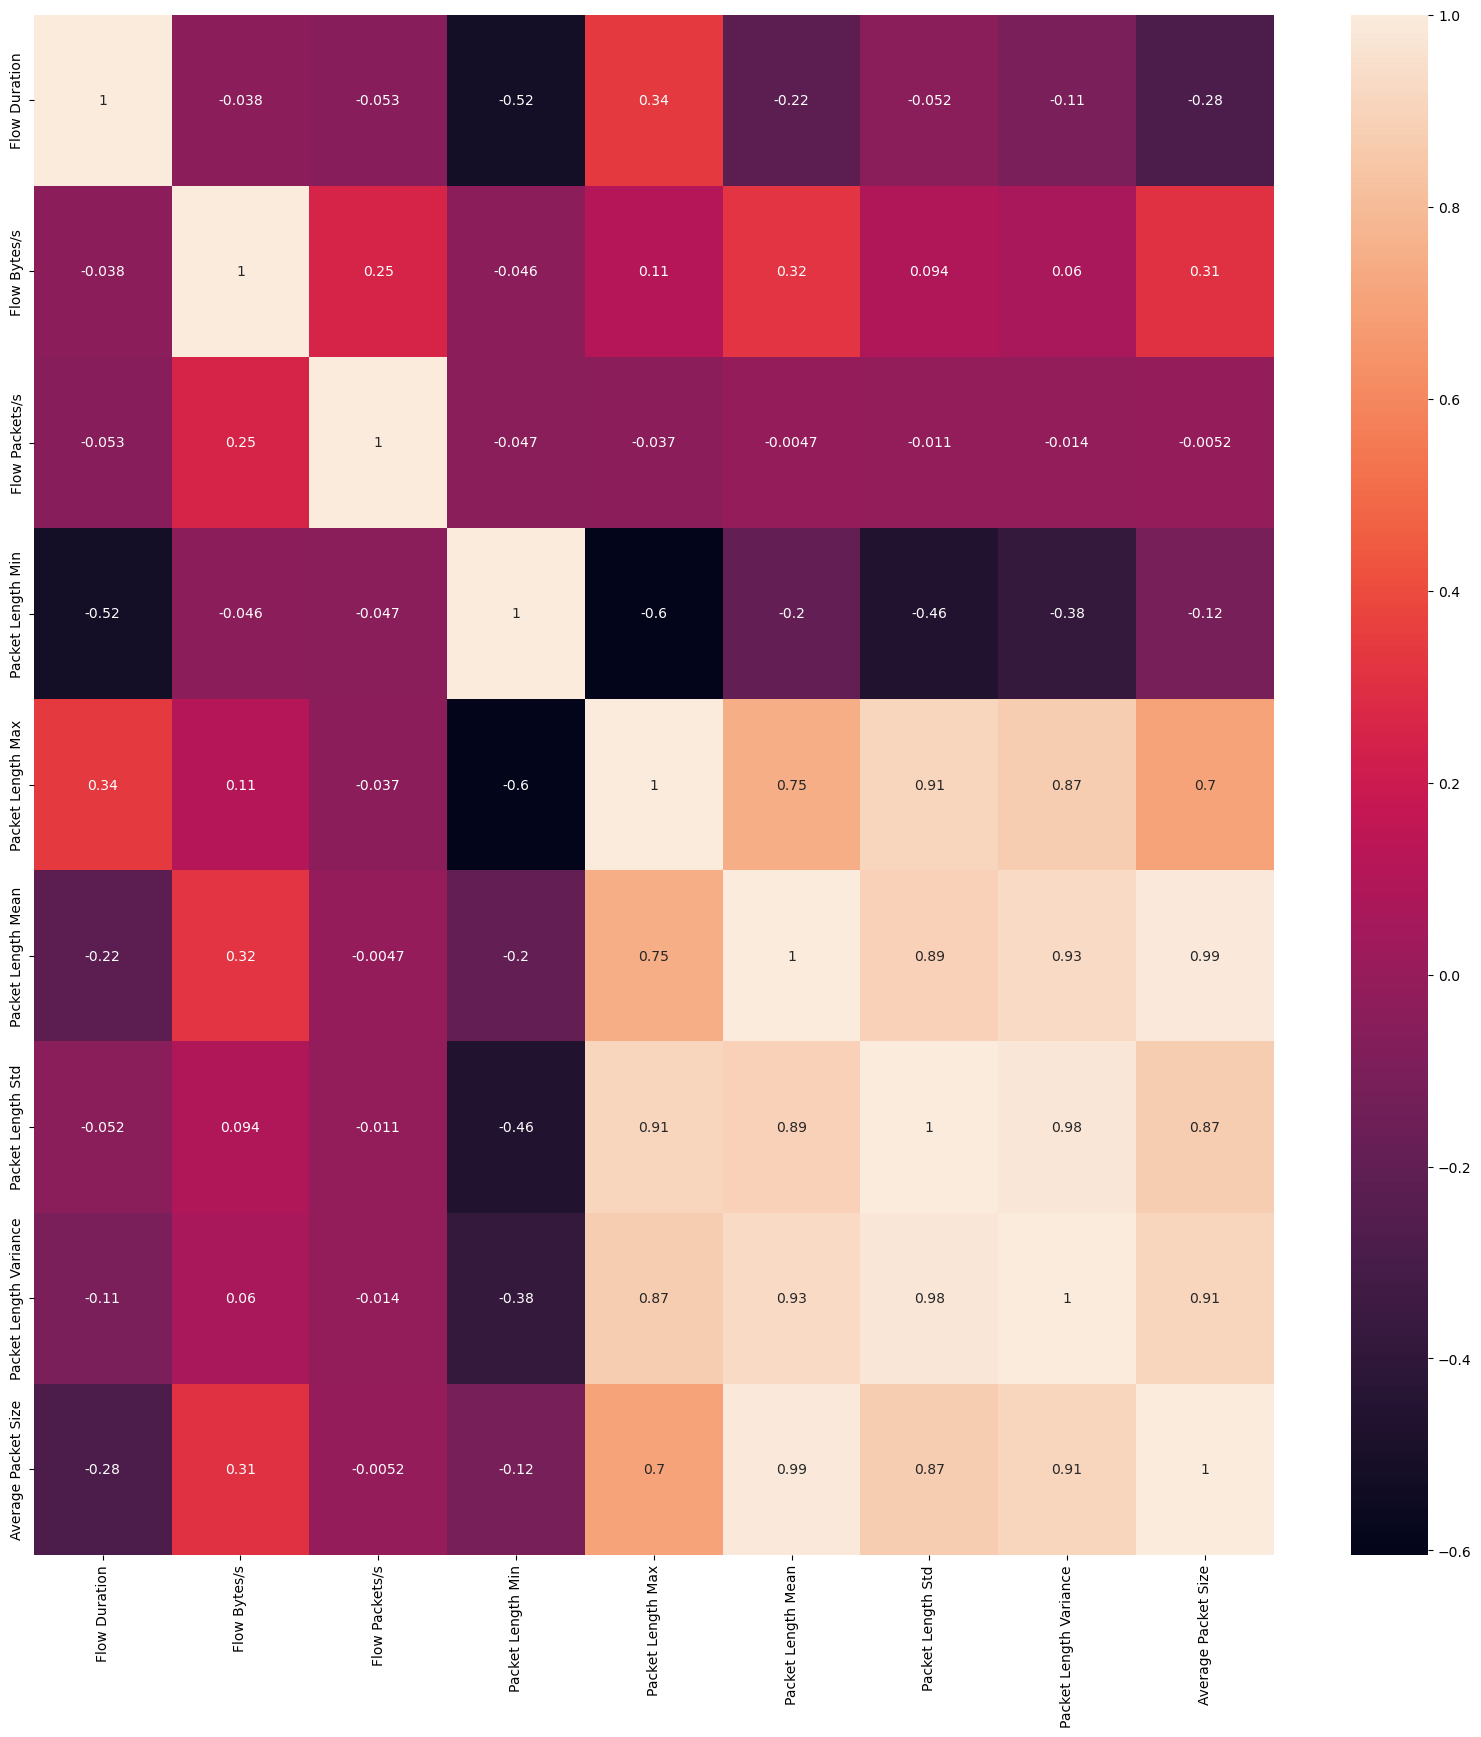

In [183]:
Feb5_flow = Feb5[['Flow Duration', 
                  'Flow Bytes/s', 
                  'Flow Packets/s', 
                  'Packet Length Min', 
                  'Packet Length Max', 
                  'Packet Length Mean', 
                  'Packet Length Std', 
                  'Packet Length Variance', 
                  'Average Packet Size',
                  'Active Mean',
                  'Active Std',
                  'Active Max',
                  'Active Min',
                  'Idle Std',
                  'Idle Mean',
                  'Idle Max',
                  'Idle Min',
                  'Down/Up Ratio']]
plt.figure(figsize=(20,20))
sns.heatmap(Feb5_flow.corr(),annot=True)

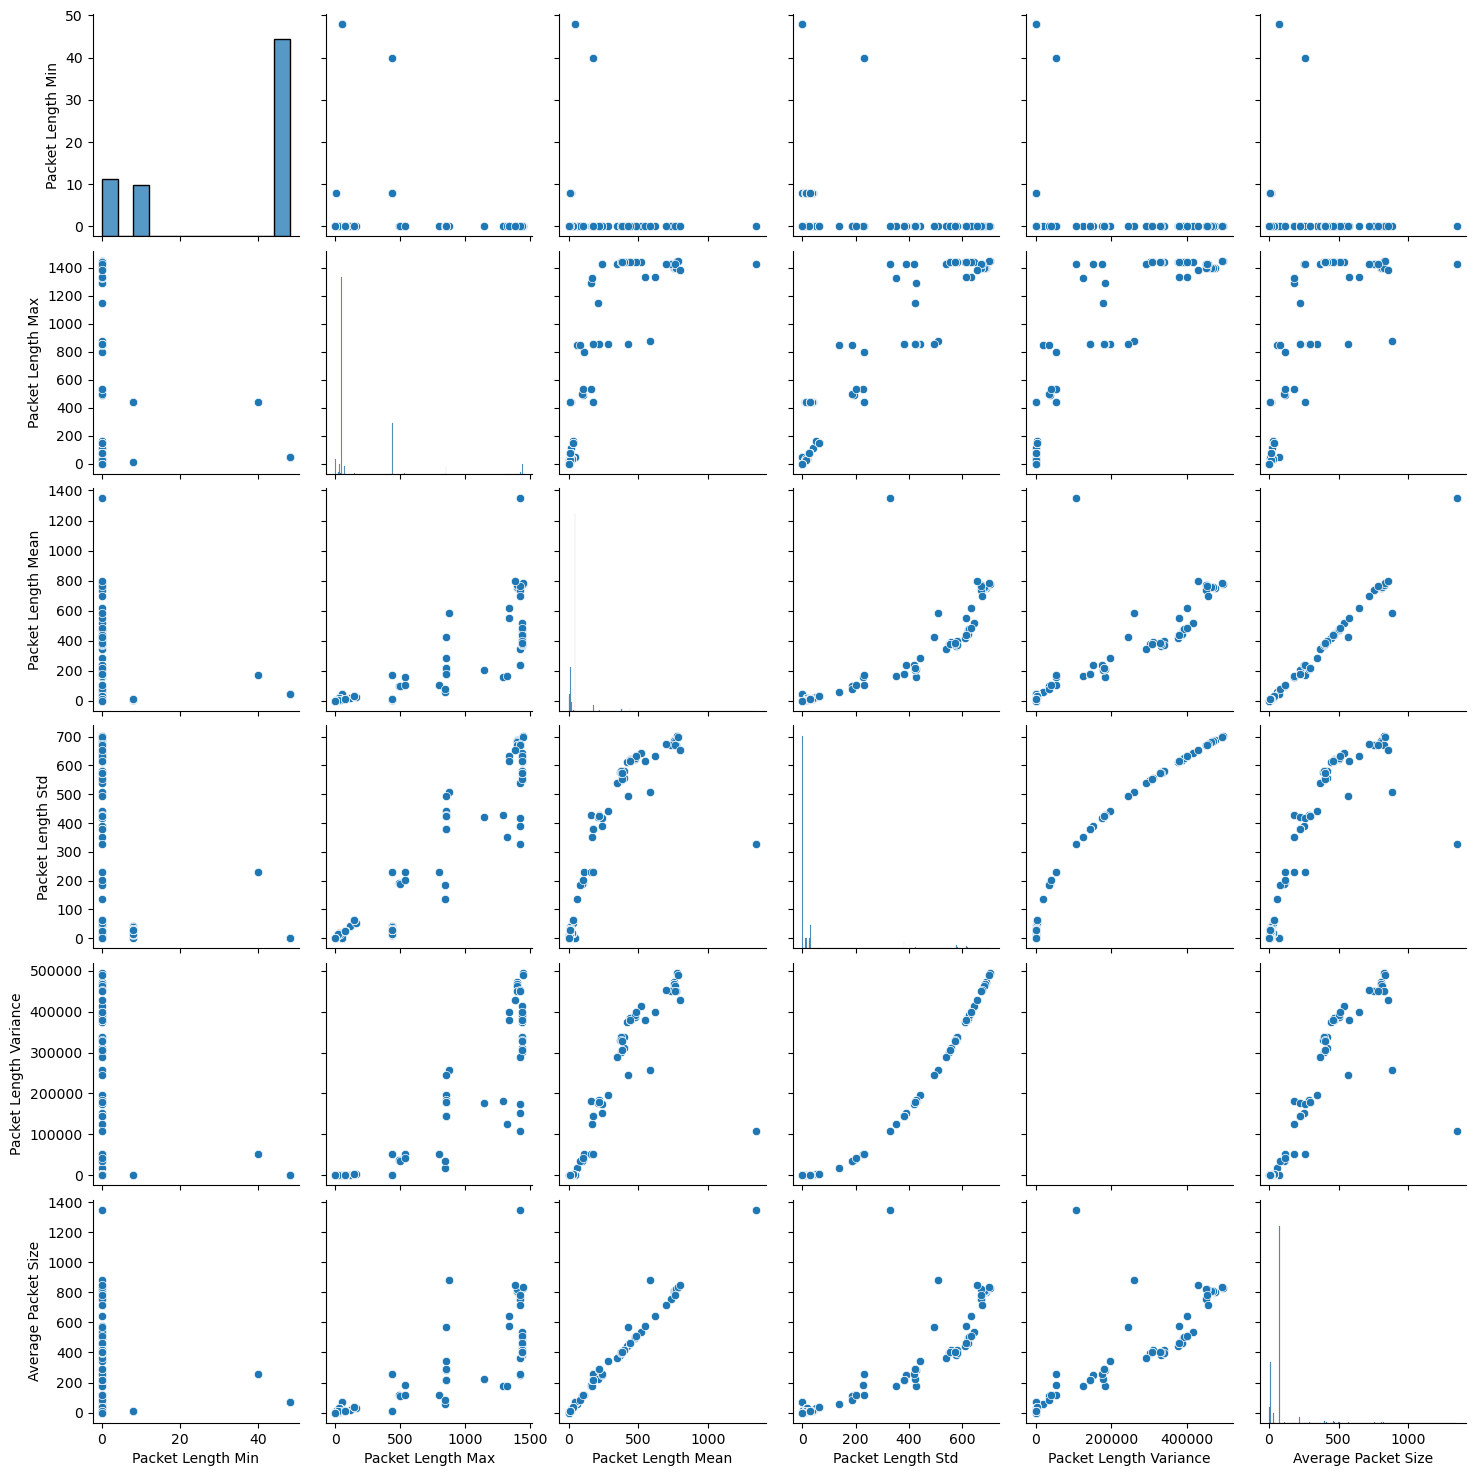

In [184]:
packets = Feb5[['Packet Length Min', 
                  'Packet Length Max', 
                  'Packet Length Mean', 
                  'Packet Length Std', 
                  'Packet Length Variance', 
                  'Average Packet Size']]
sns.pairplot(packets)

Column to keep: 'Packet Length Variance' - Reason: Most columns over 90% represented and another at 87%
Resulting columns dropped: 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Average Packet Size'

<Axes: >

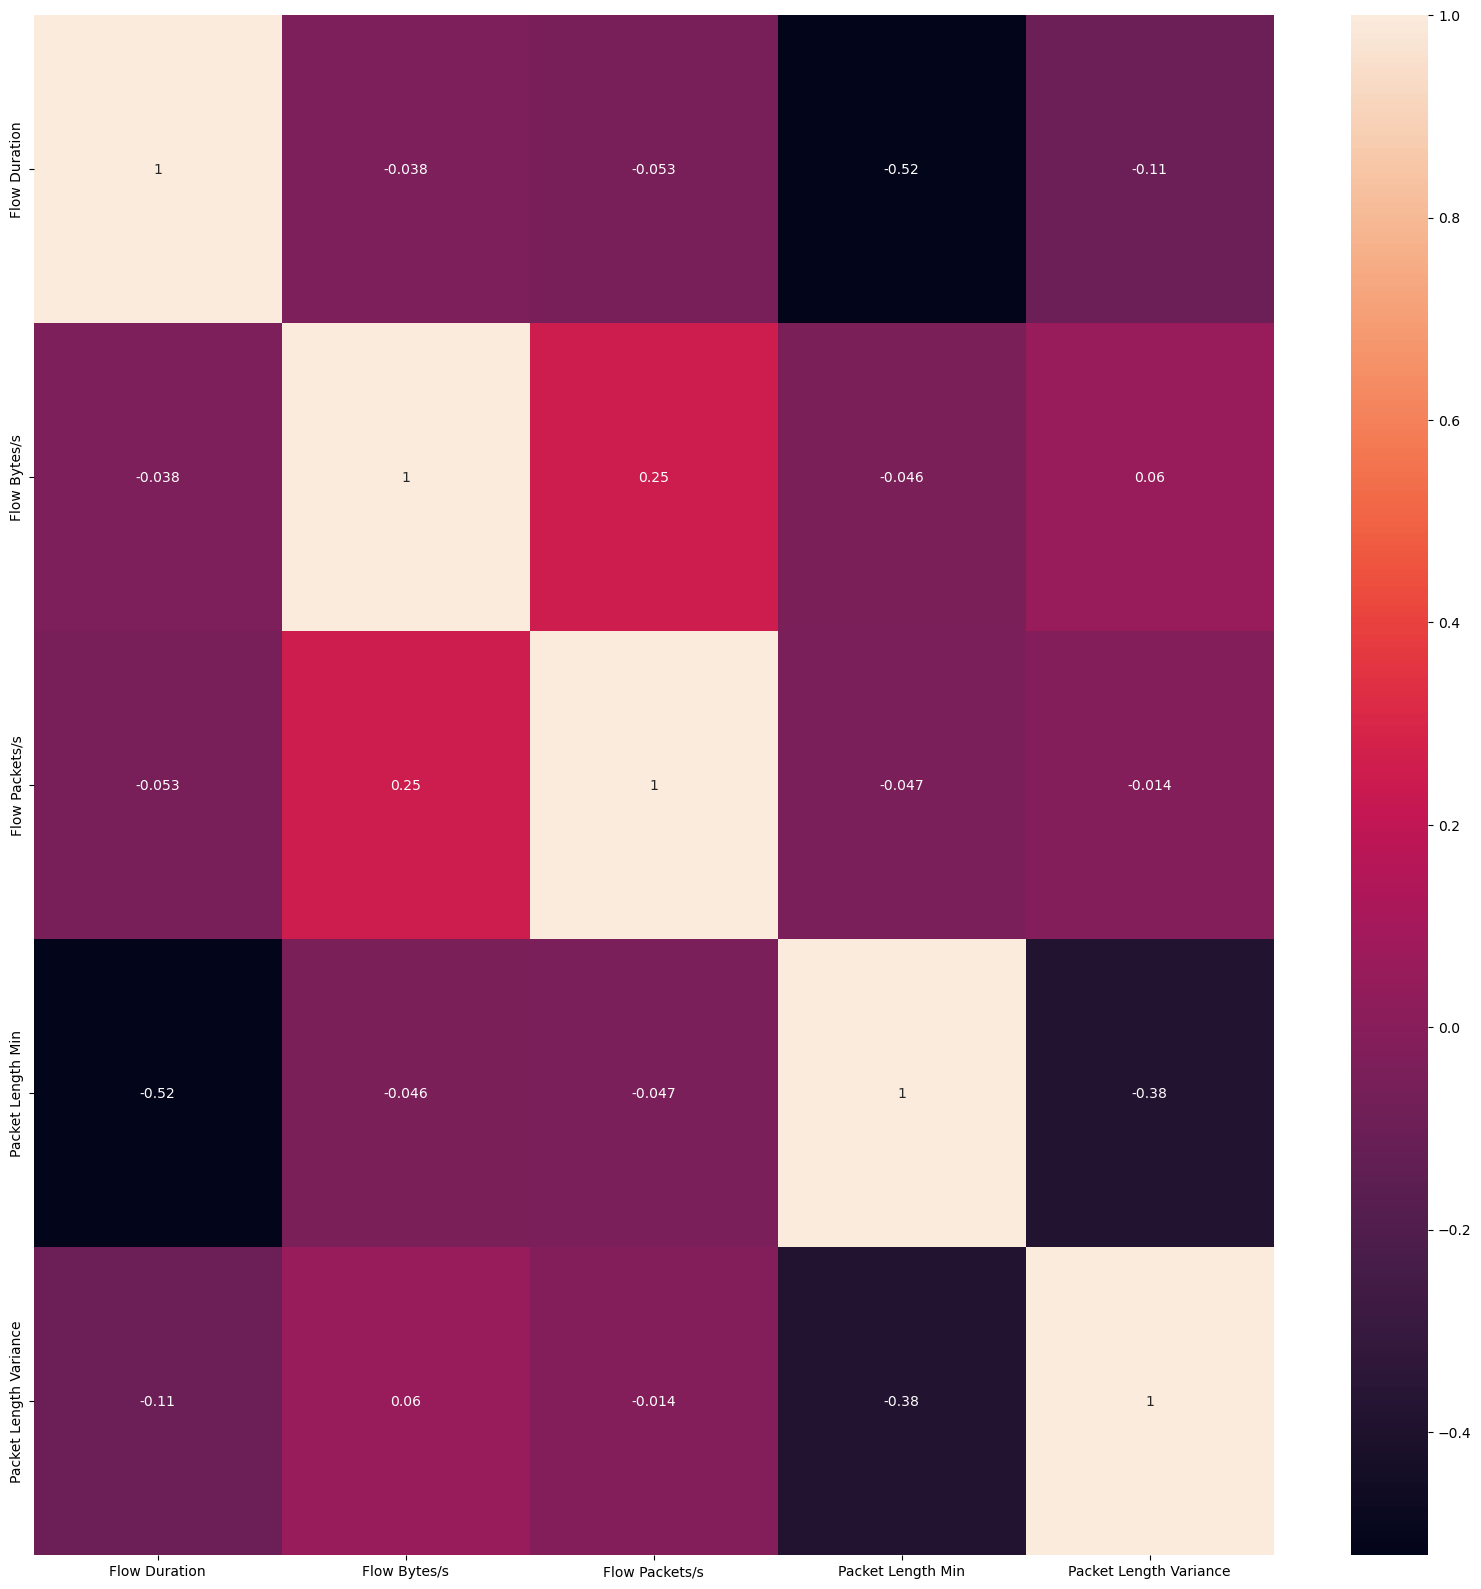

In [185]:
Feb5_flow = Feb5_flow.drop(columns=['Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Average Packet Size'])
plt.figure(figsize=(20,20))
sns.heatmap(Feb5_flow.corr(), annot=True)

In [186]:
flow_cols = Feb5_flow.columns.to_list()
flow_cols

['Flow Duration',
 'Flow Bytes/s',
 'Flow Packets/s',
 'Packet Length Min',
 'Packet Length Variance']

## Miscellanious

These columns represent object data that is non-numerical. A lot of transformations must be made to process and analyze. Label column must be encoded. Timestamps converted to float, and IPs turned into ints.

<Axes: >

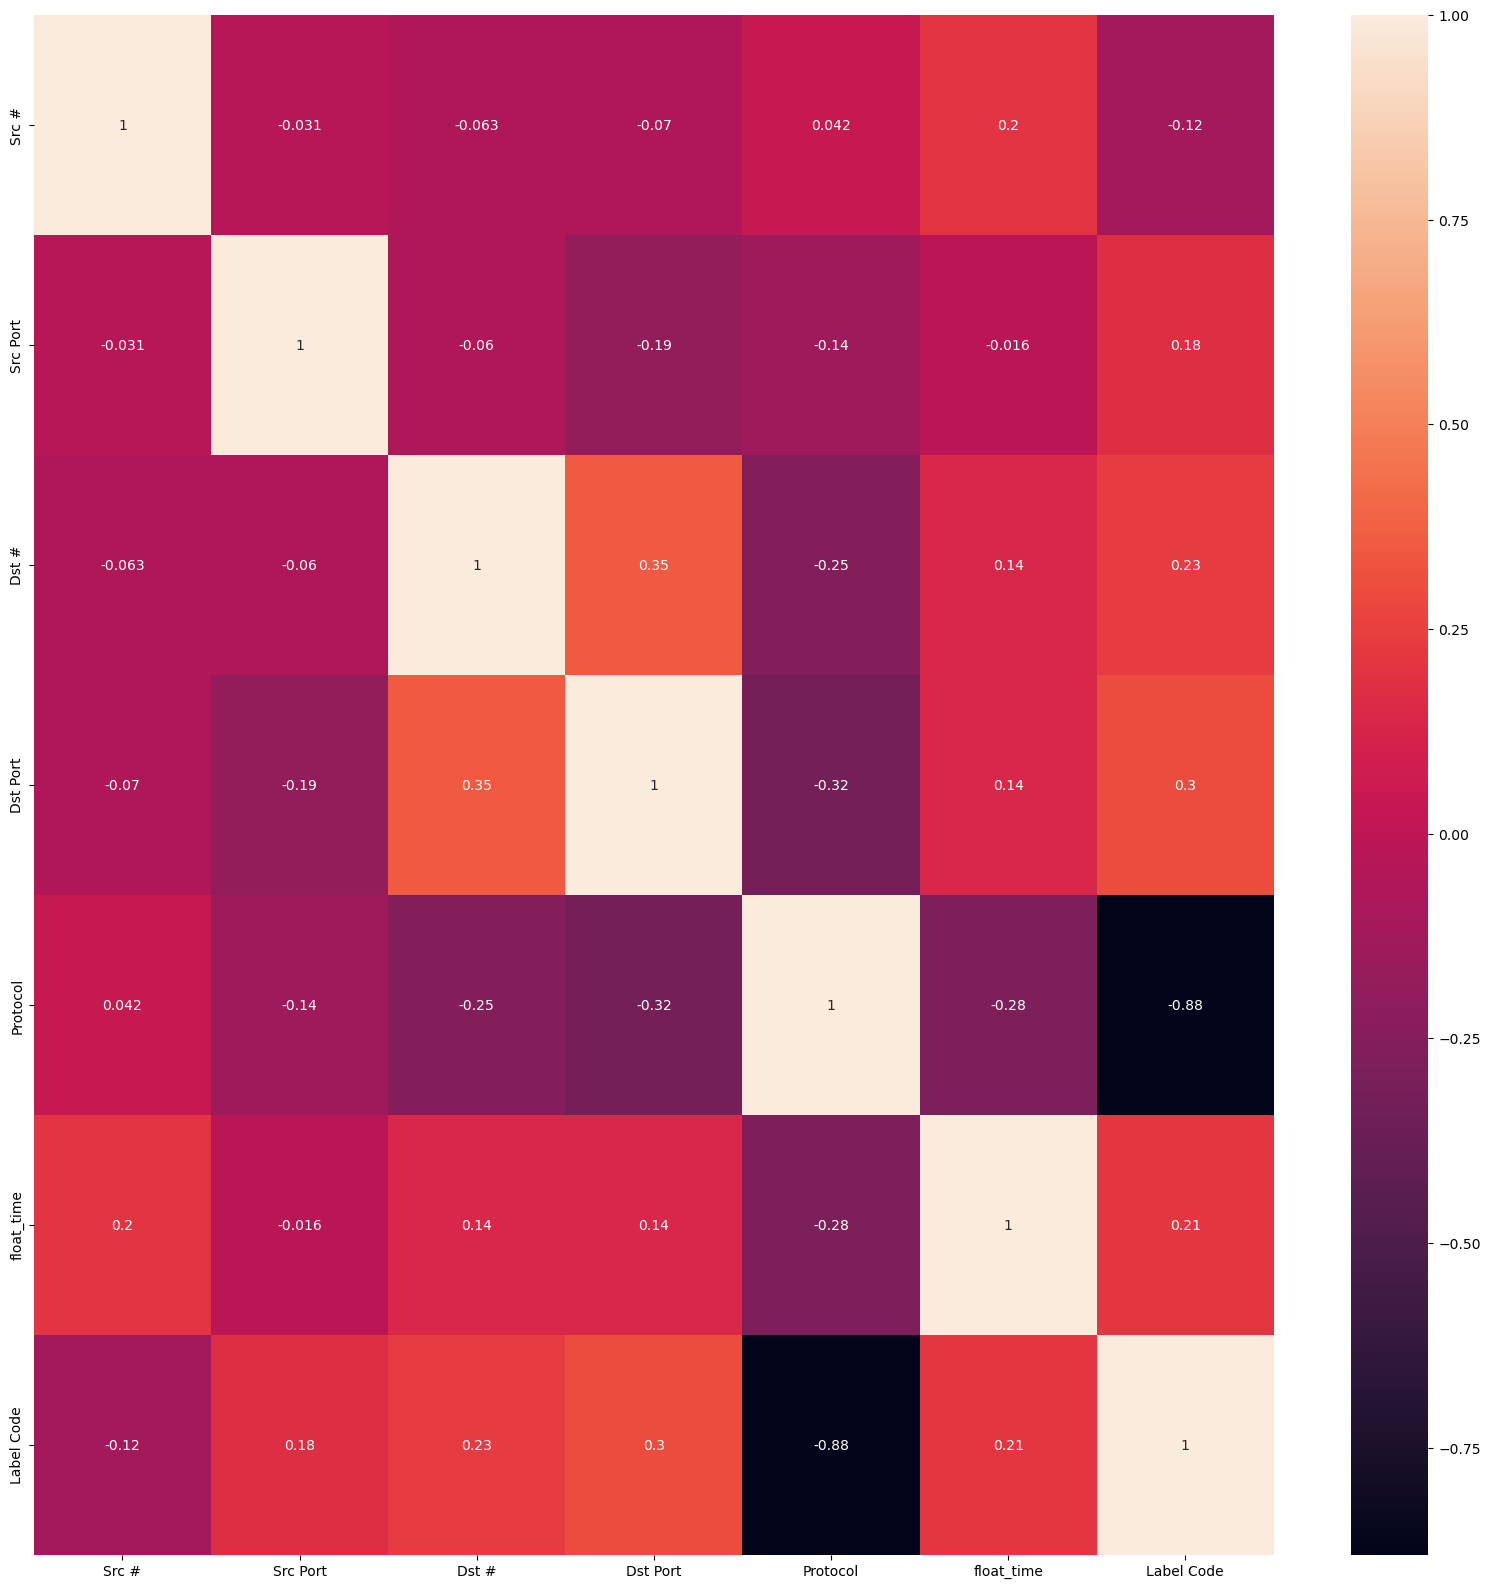

In [187]:
Feb5['Label Code'] = Feb5['Label'].map({'ddospot':1,'cowrie':2,'adbhoney':3,'log4pot':4,'ciscoasa':5,'elasticpot':6,'mailoney':7})
# Convert to datetime
times = pd.to_datetime(Feb5['Timestamp'])
# Extract time and convert to float (hours)
Feb5['float_time'] = times.dt.hour + times.dt.minute / 60 + times.dt.second / 3600
#convert IPs into ints
Feb5['Src #'] = Feb5['Src IP'].str.replace('.', '', regex=False).astype(int)
Feb5['Dst #'] = Feb5['Dst IP'].str.replace('.', '', regex=False).astype(int)
#create frame
Feb5_misc = Feb5[['Src #',
'Src Port',
'Dst #',
'Dst Port',
'Protocol',
'float_time',
'Label Code']]
plt.figure(figsize=(20,20))
sns.heatmap(Feb5_misc.corr(), annot=True)

In [188]:
misc_cols = Feb5_misc.columns.to_list()
misc_cols

['Src #',
 'Src Port',
 'Dst #',
 'Dst Port',
 'Protocol',
 'float_time',
 'Label Code']

## Forward + Backward + Flow

All three of these groups have to do with timing of packets. Now that we've reduced features, we can see if there is any 90%+ correlation here. Because this data is related, we can still assume it's safe to drop high correlation.

<Axes: >

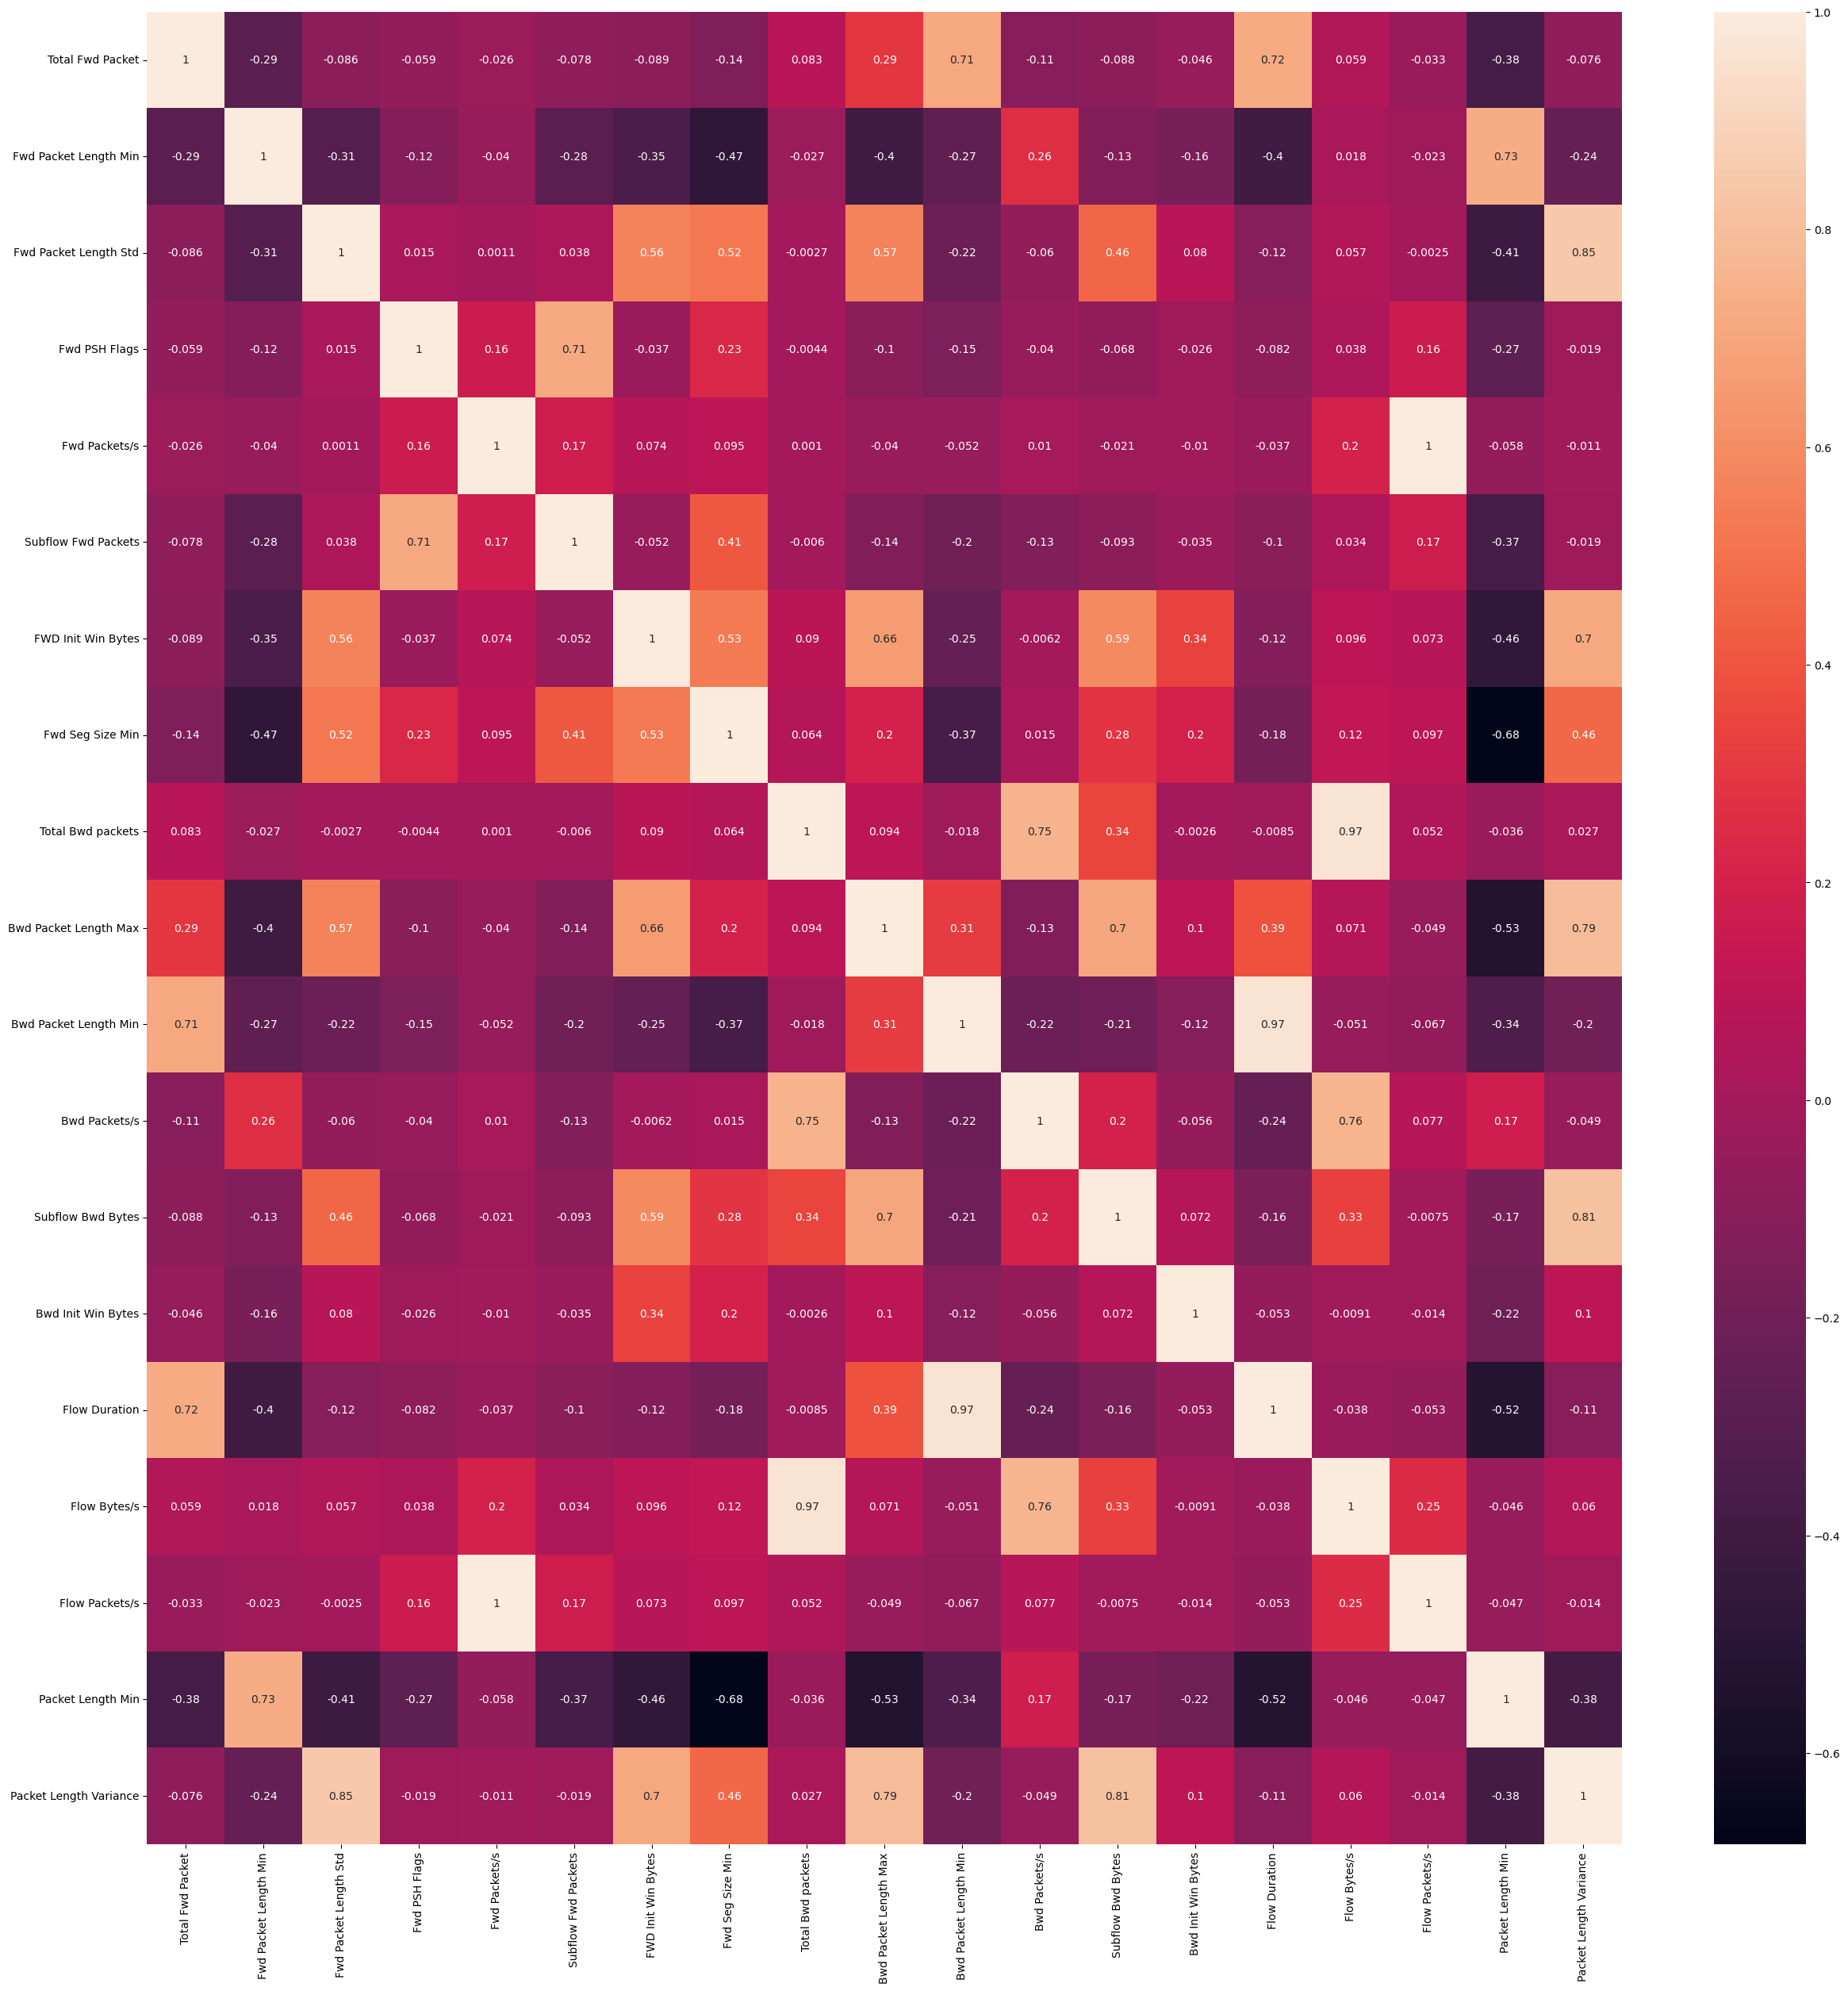

In [191]:
Fwd_Bwd =  Fwd_Cols + Bwd_cols + flow_cols
Feb5_Fwd_Bwd = Feb5[Fwd_Bwd]
plt.figure(figsize=(30,30))
sns.heatmap(Feb5_Fwd_Bwd.corr(), annot=True)

<Axes: xlabel='Fwd Packets/s', ylabel='Bwd Packets/s'>

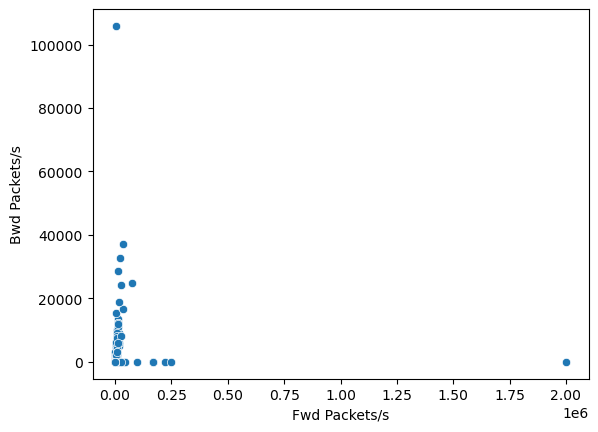

In [193]:
sns.scatterplot(Feb5_Fwd_Bwd, x='Fwd Packets/s', y='Bwd Packets/s')

Column to drop: 'Fwd Packets/s' - Reason: 'Flow Packets/s' has a bit more non-zero representaion and captures all of 'Fwd Packets/s'

<Axes: >

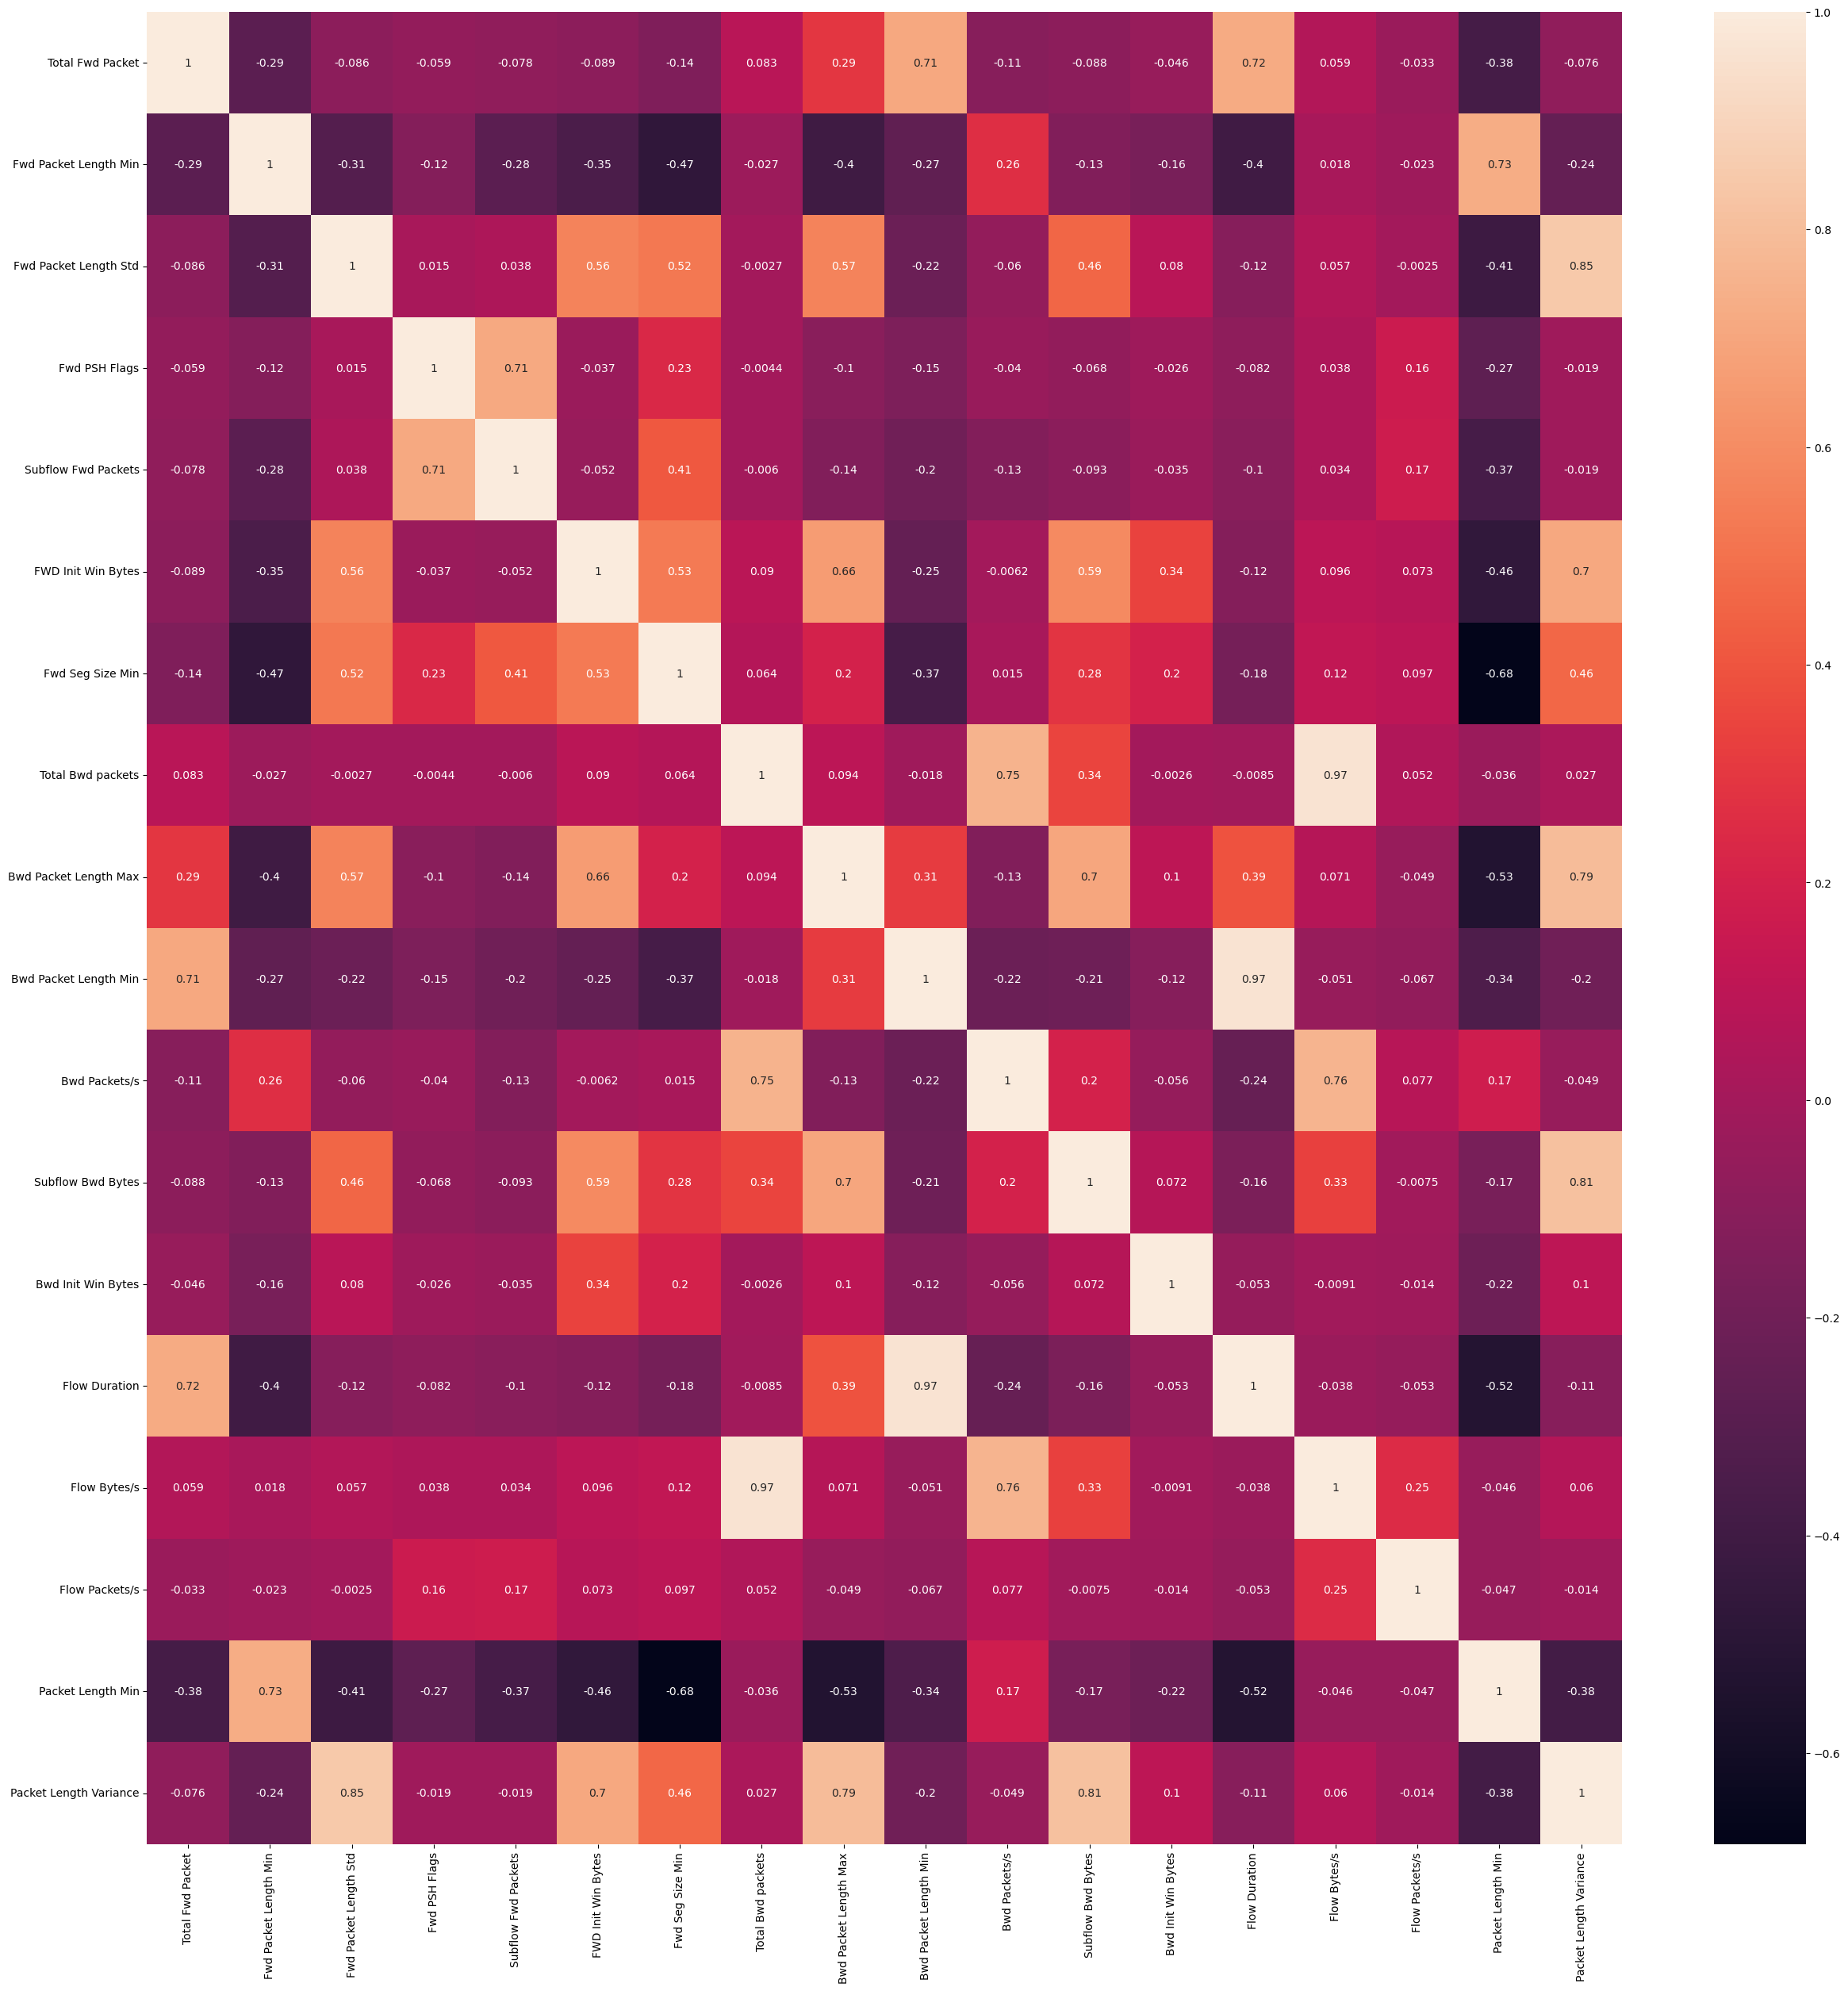

In [ ]:
Feb5_Fwd_Bwd = Feb5_Fwd_Bwd.drop(columns=['Fwd Packets/s'])
plt.figure(figsize=(30,30))
sns.heatmap(Feb5_Fwd_Bwd.corr(), annot=True)

Column to drop: 'Flow Bytes/s' - Reason: Further analysis shows outside correlation in the 'Total Bwd packets/s' column so it is kept and represents 97% of Flow Bytes/s

<Axes: >

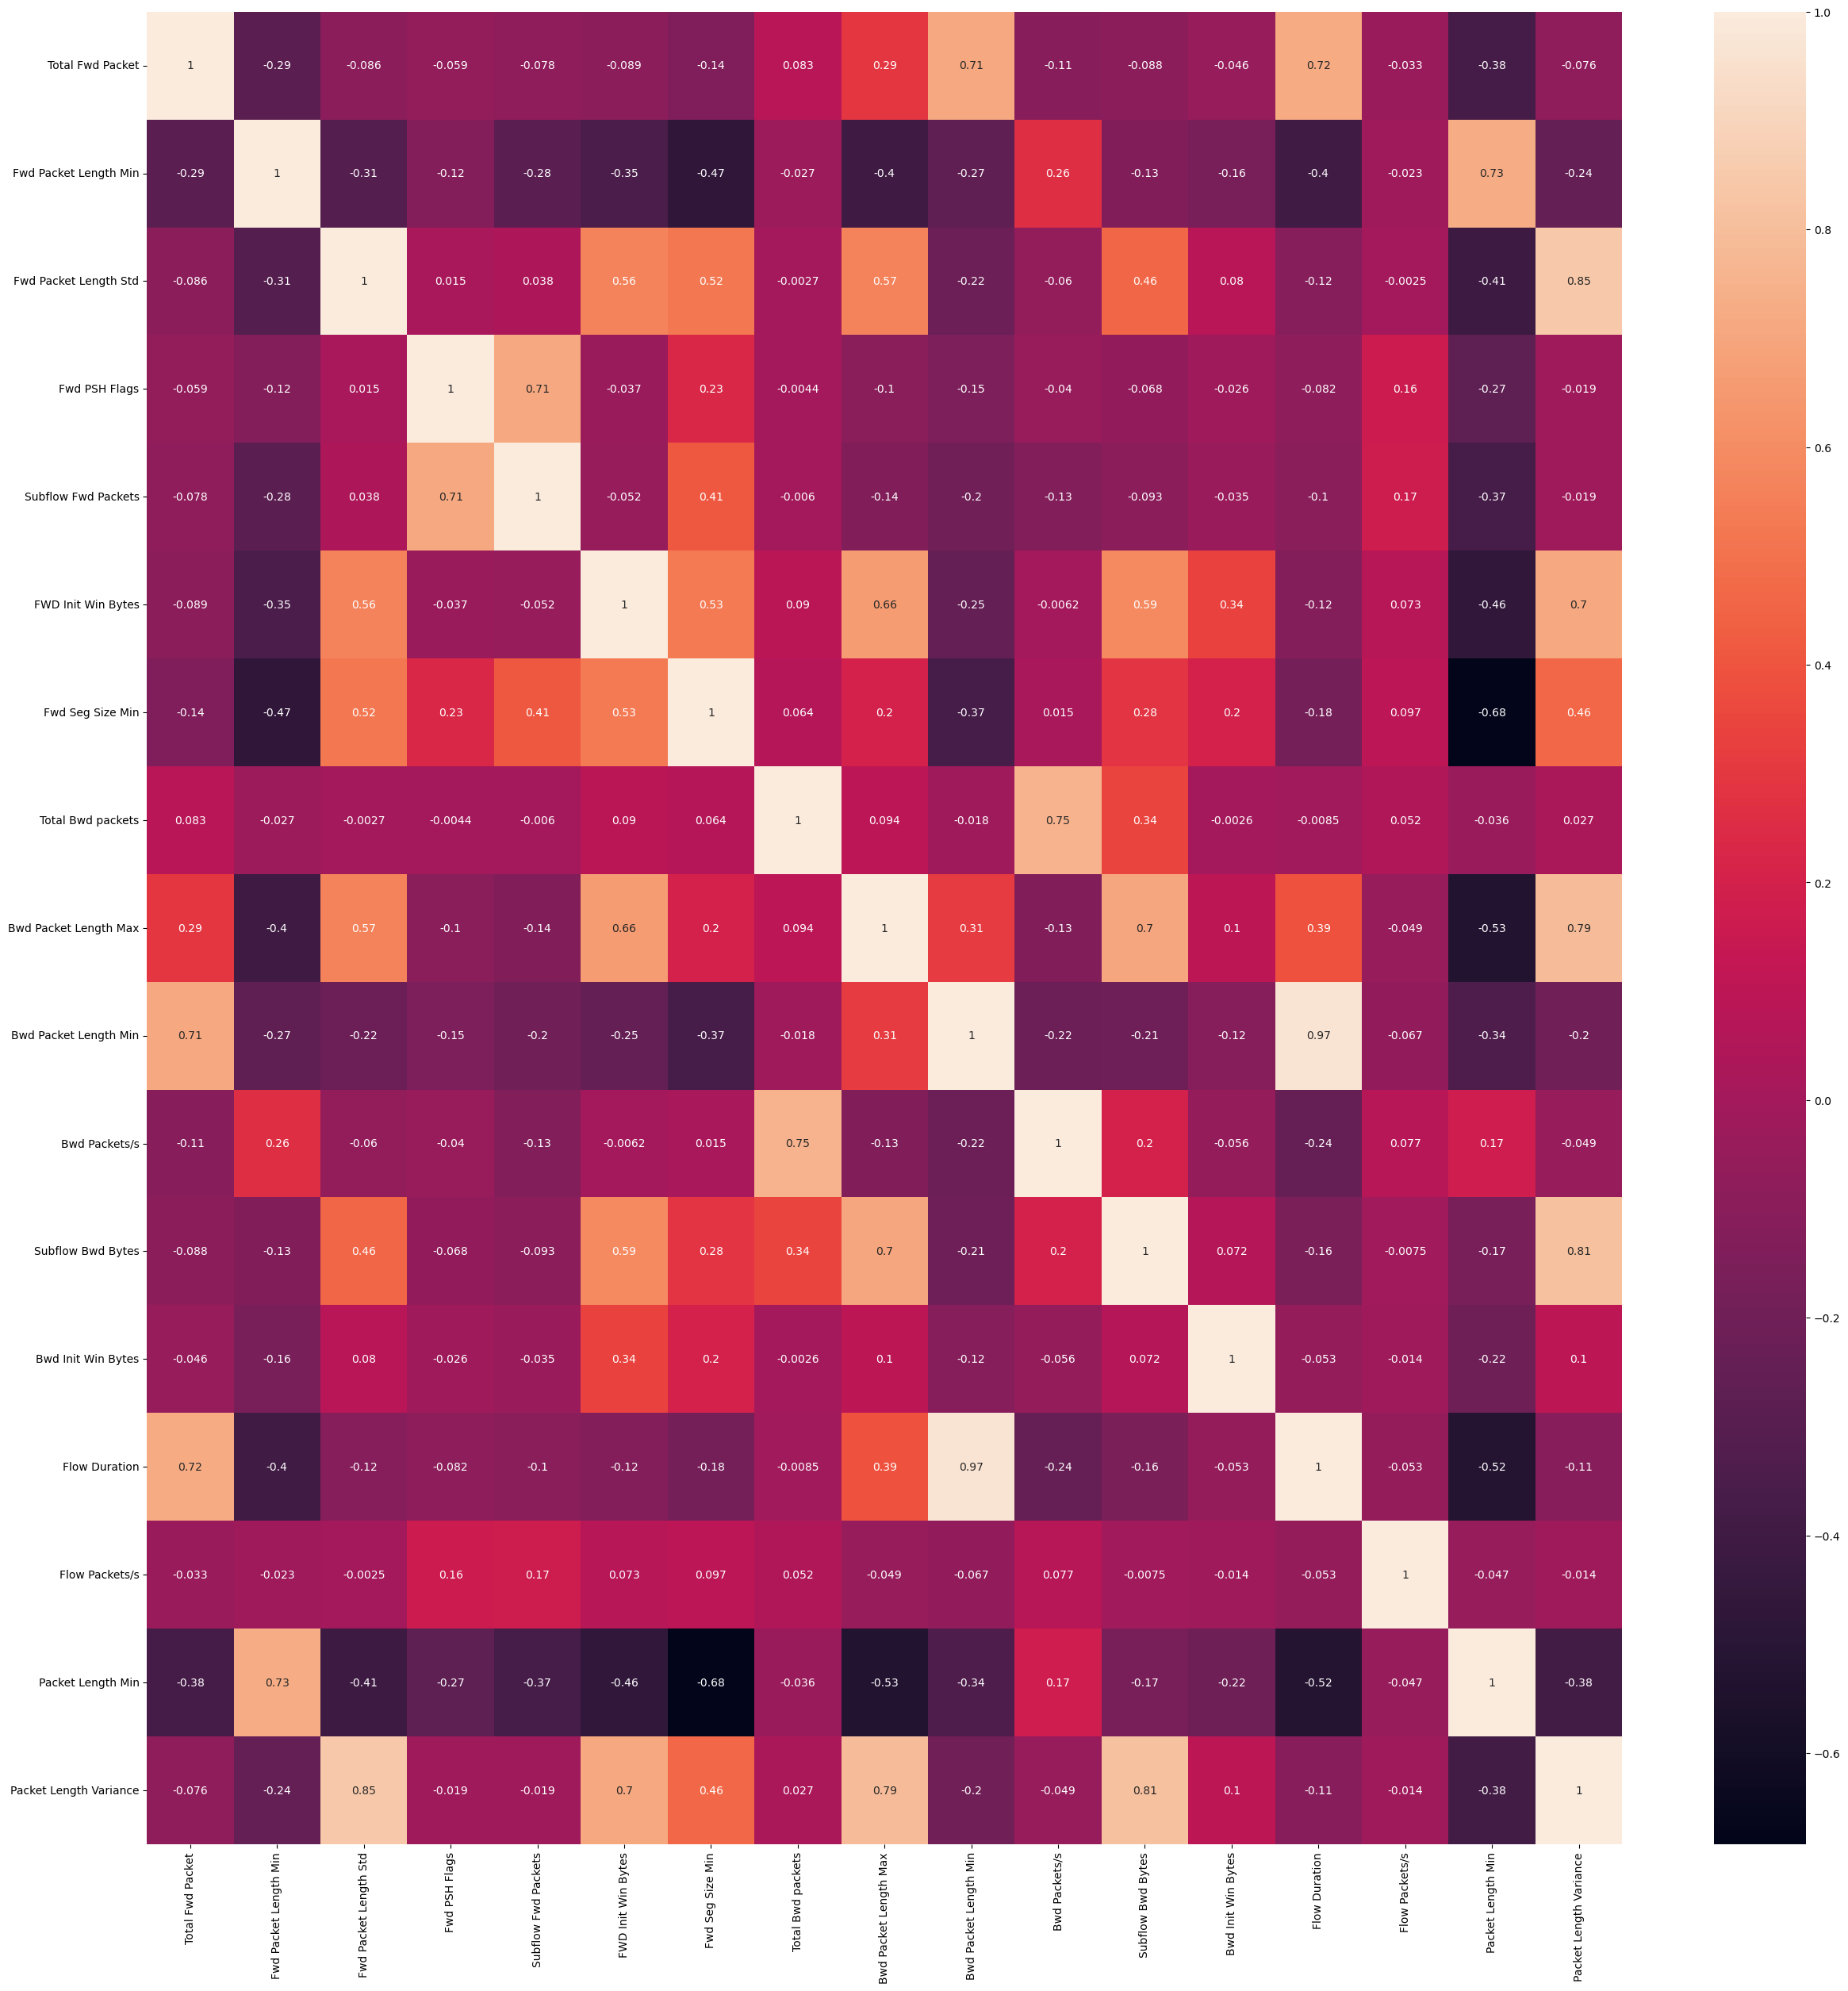

In [ ]:
Feb5_Fwd_Bwd = Feb5_Fwd_Bwd.drop(columns=['Flow Bytes/s'])
plt.figure(figsize=(30,30))
sns.heatmap(Feb5_Fwd_Bwd.corr(), annot=True)

Column to drop: 'Bwd Packet Length Min' - Reason: 'Flow Duration' is easy to understand and captures 97%

That will be all of the columns cut from this mega grouping.

In [ ]:
Feb5_Fwd_Bwd = Feb5_Fwd_Bwd.drop(columns=['Bwd Packet Length Min'])
Fwd_Bwd_Flow_cols = Feb5_Fwd_Bwd.columns.to_list()

<Axes: >

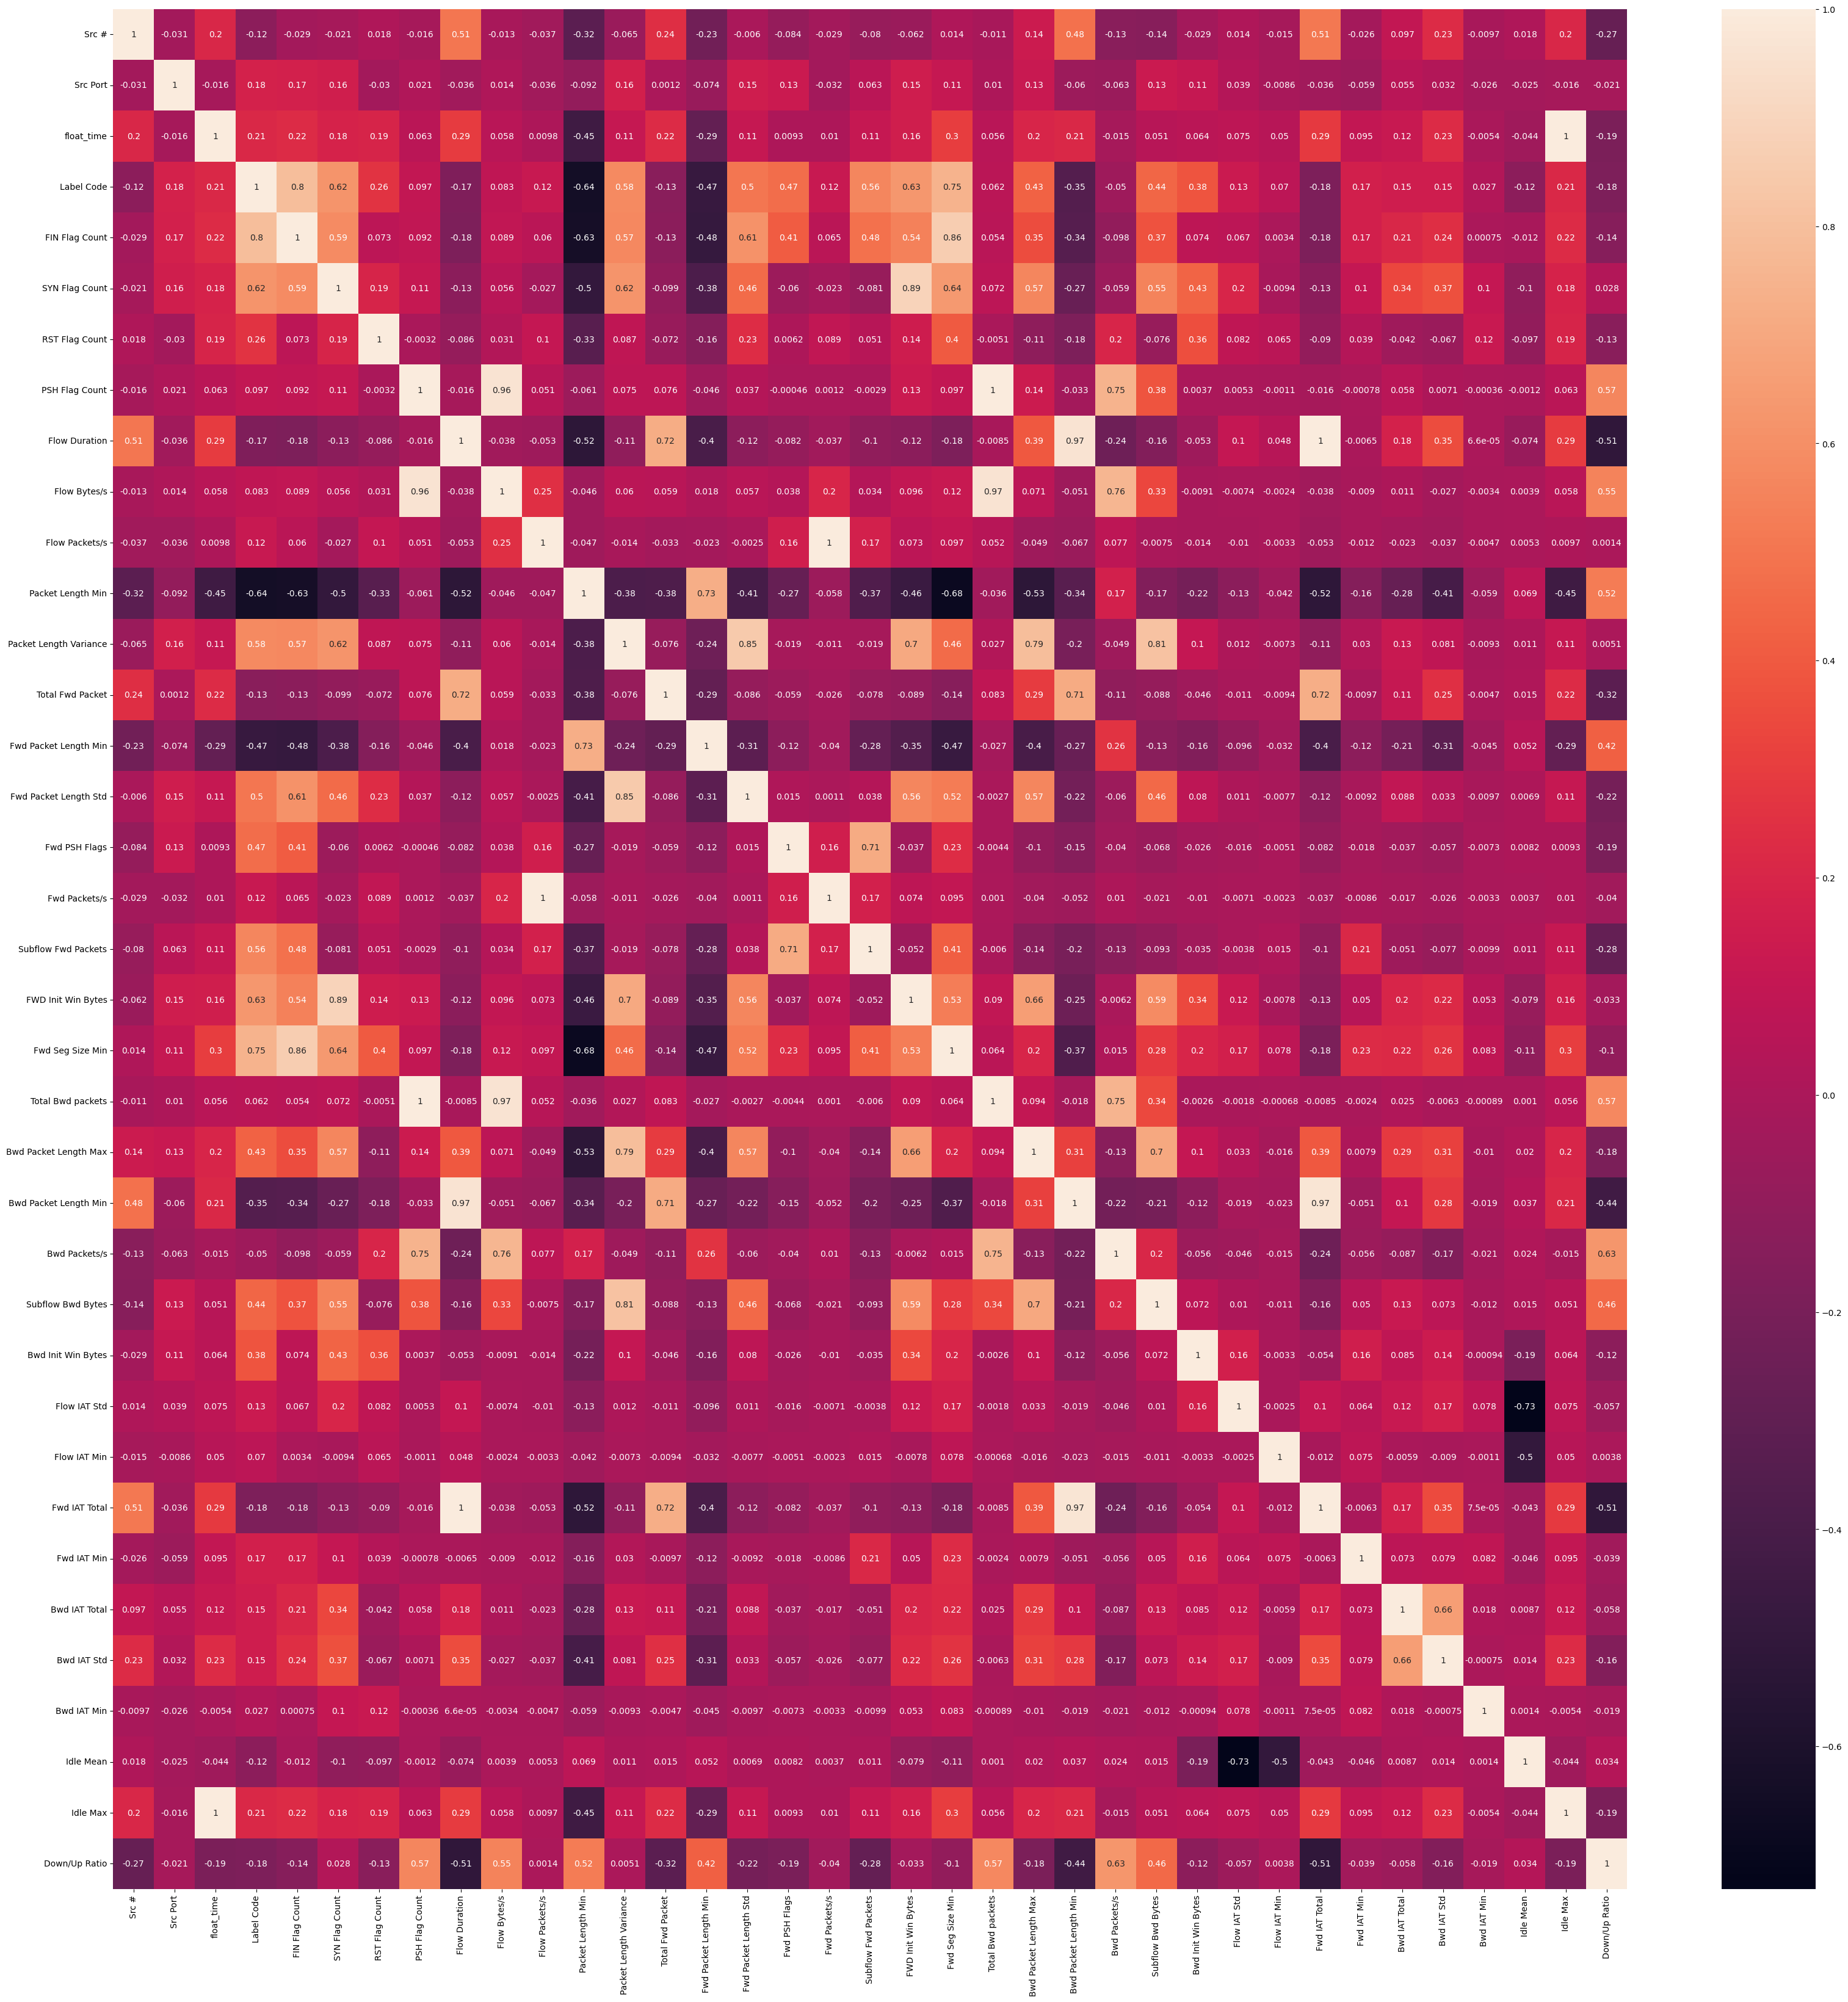

In [ ]:
kept_cols = ['Src #', 'Src Port', 'float_time', 'Label Code']
for lst in [flag_cols, flow_cols, Fwd_Cols, Bwd_cols, IAT_cols, activity_cols]:
    kept_cols.extend(lst)
Feb5_cut = Feb5[kept_cols]
plt.figure(figsize=(40,40))
sns.heatmap(Feb5_cut.corr(),annot=True)

Column to Keep: 'Flow Duration' - Reason: Easy to understand column that captures 2 others at 97%+
Resulting dropped columns: 'Fwd IAT Total', 'Bwd Packet Length Min'

<Axes: >

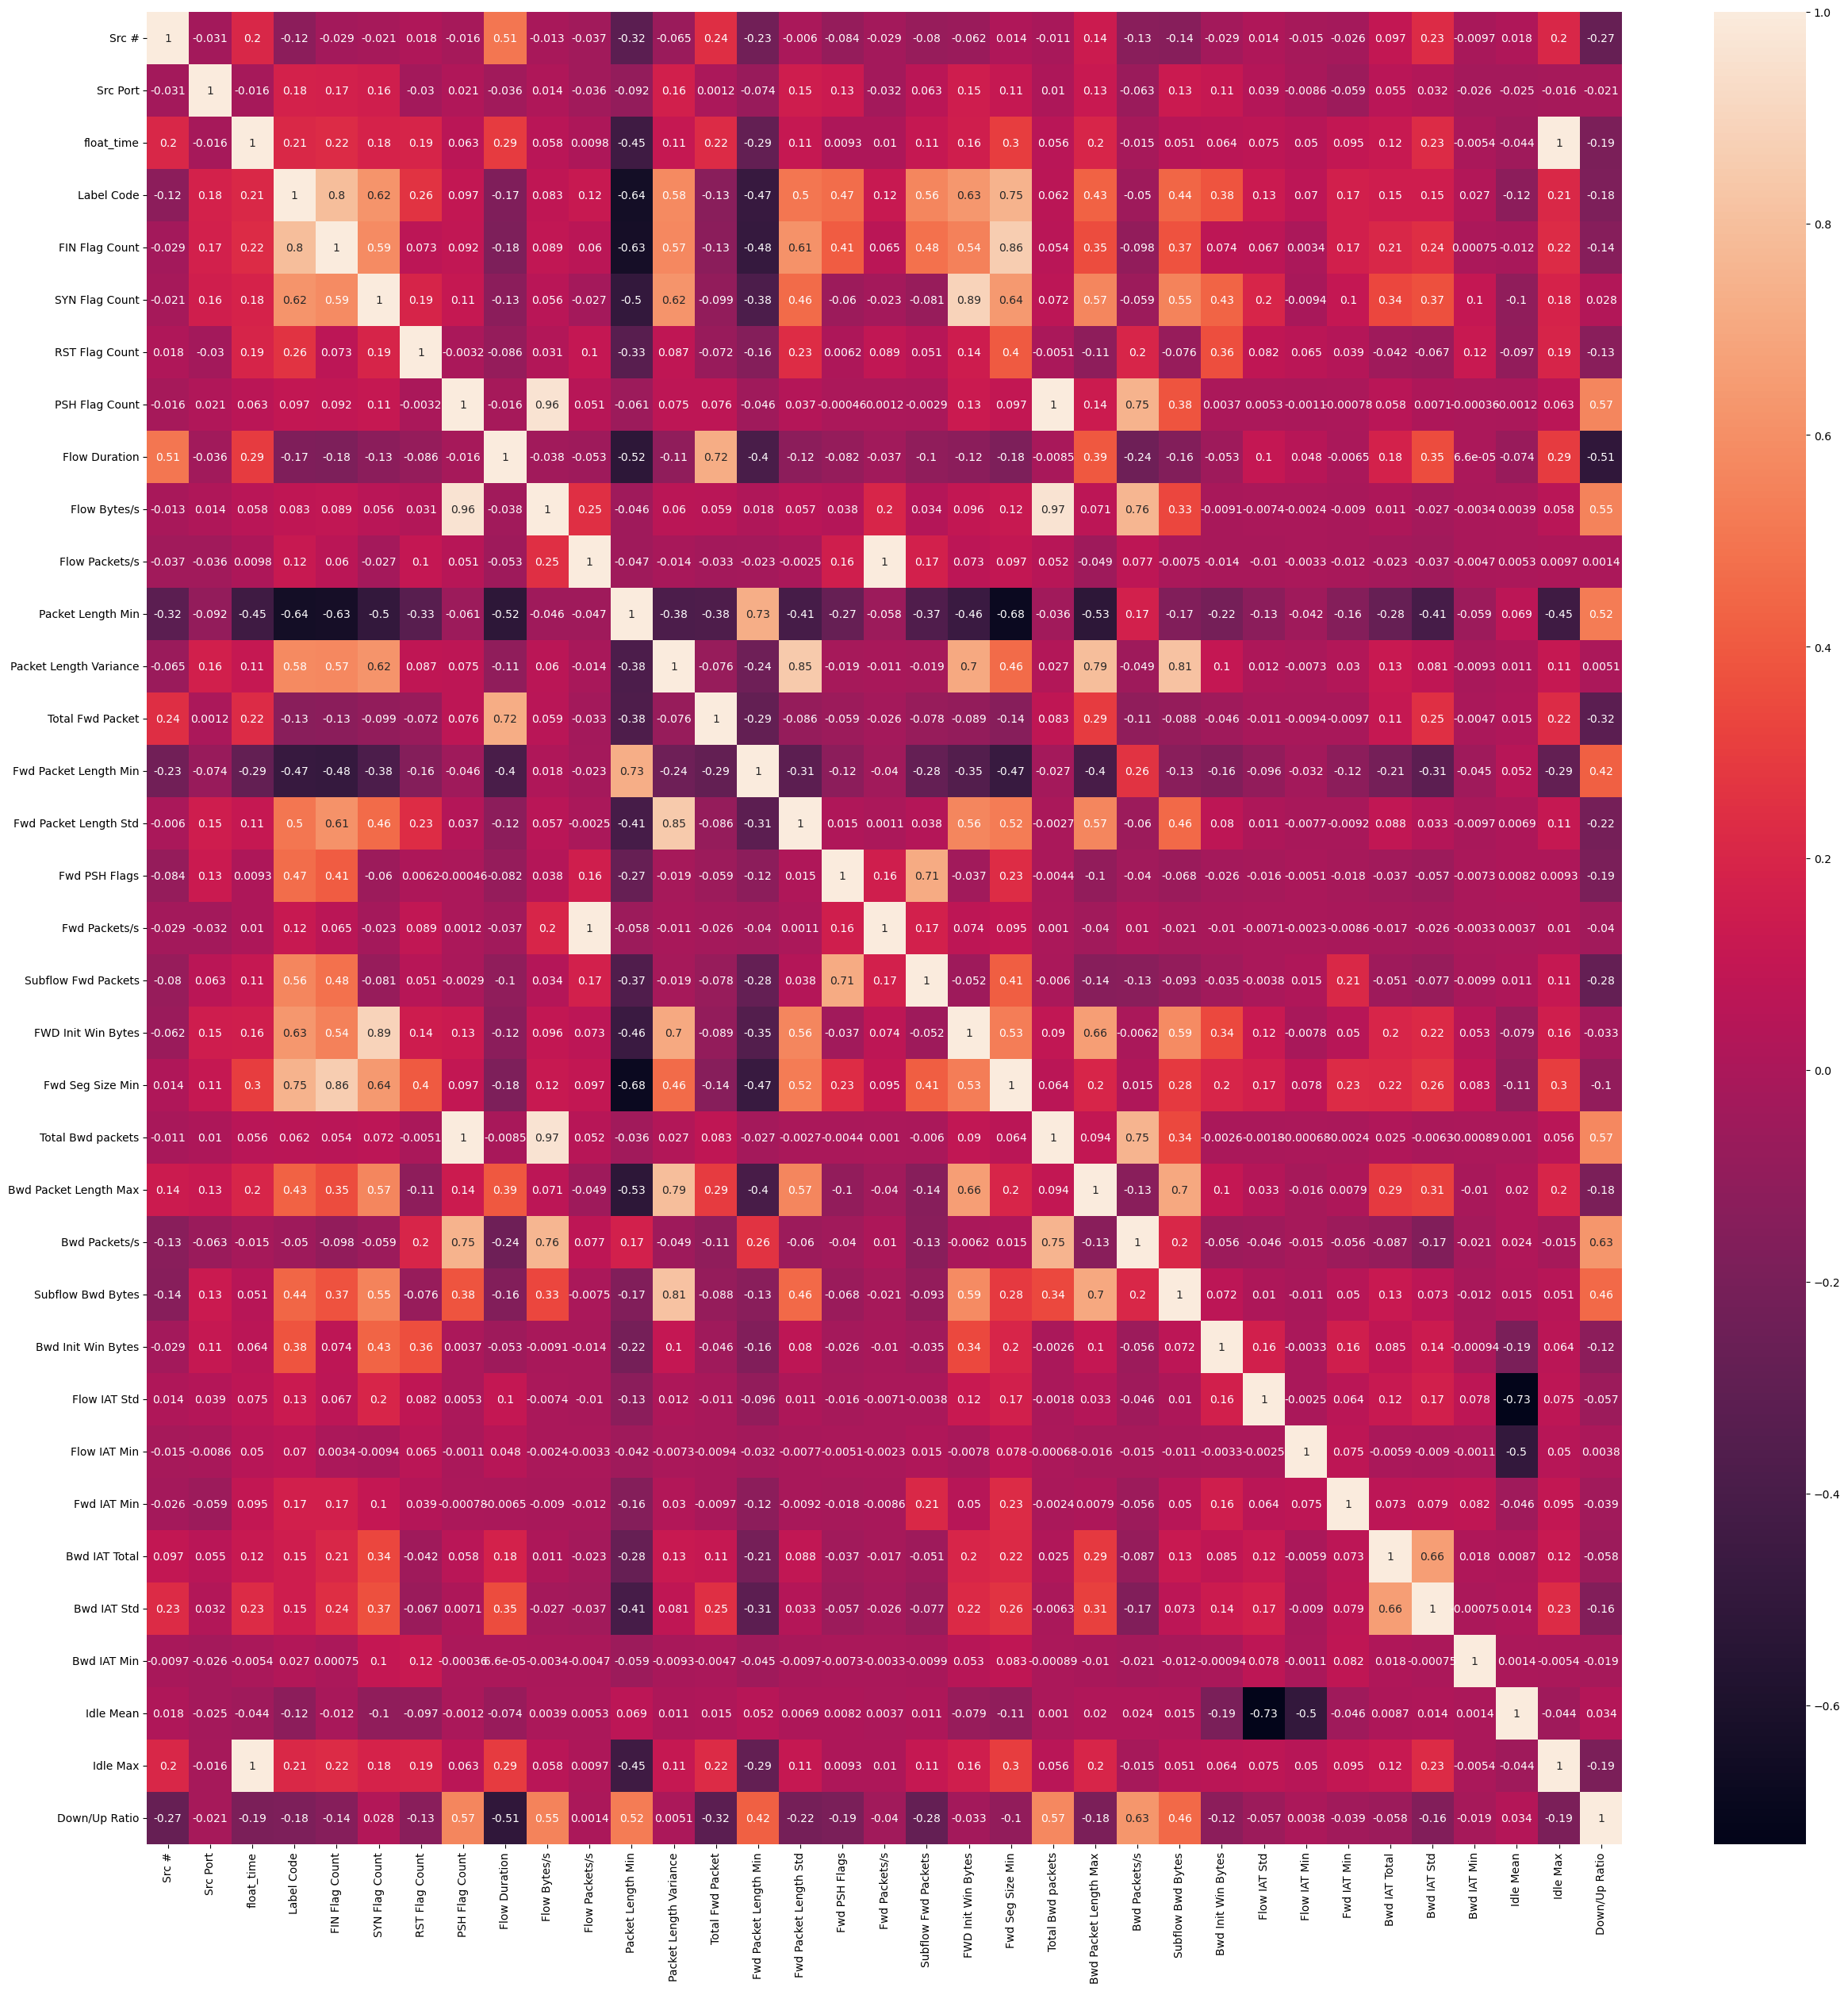

In [ ]:
Feb5_cut= Feb5_cut.drop(columns=['Fwd IAT Total', 'Bwd Packet Length Min'])
plt.figure(figsize=(30,30))
sns.heatmap(Feb5_cut.corr(), annot=True)

Column to keep: 'Total Bwd Packets' - Reason: This was a very tough decision that came down to Total Bwd Packet perfectly representing a column
Resulting columns dropped: 'PSH Flag Count', 'Flow Bytes'

<Axes: >

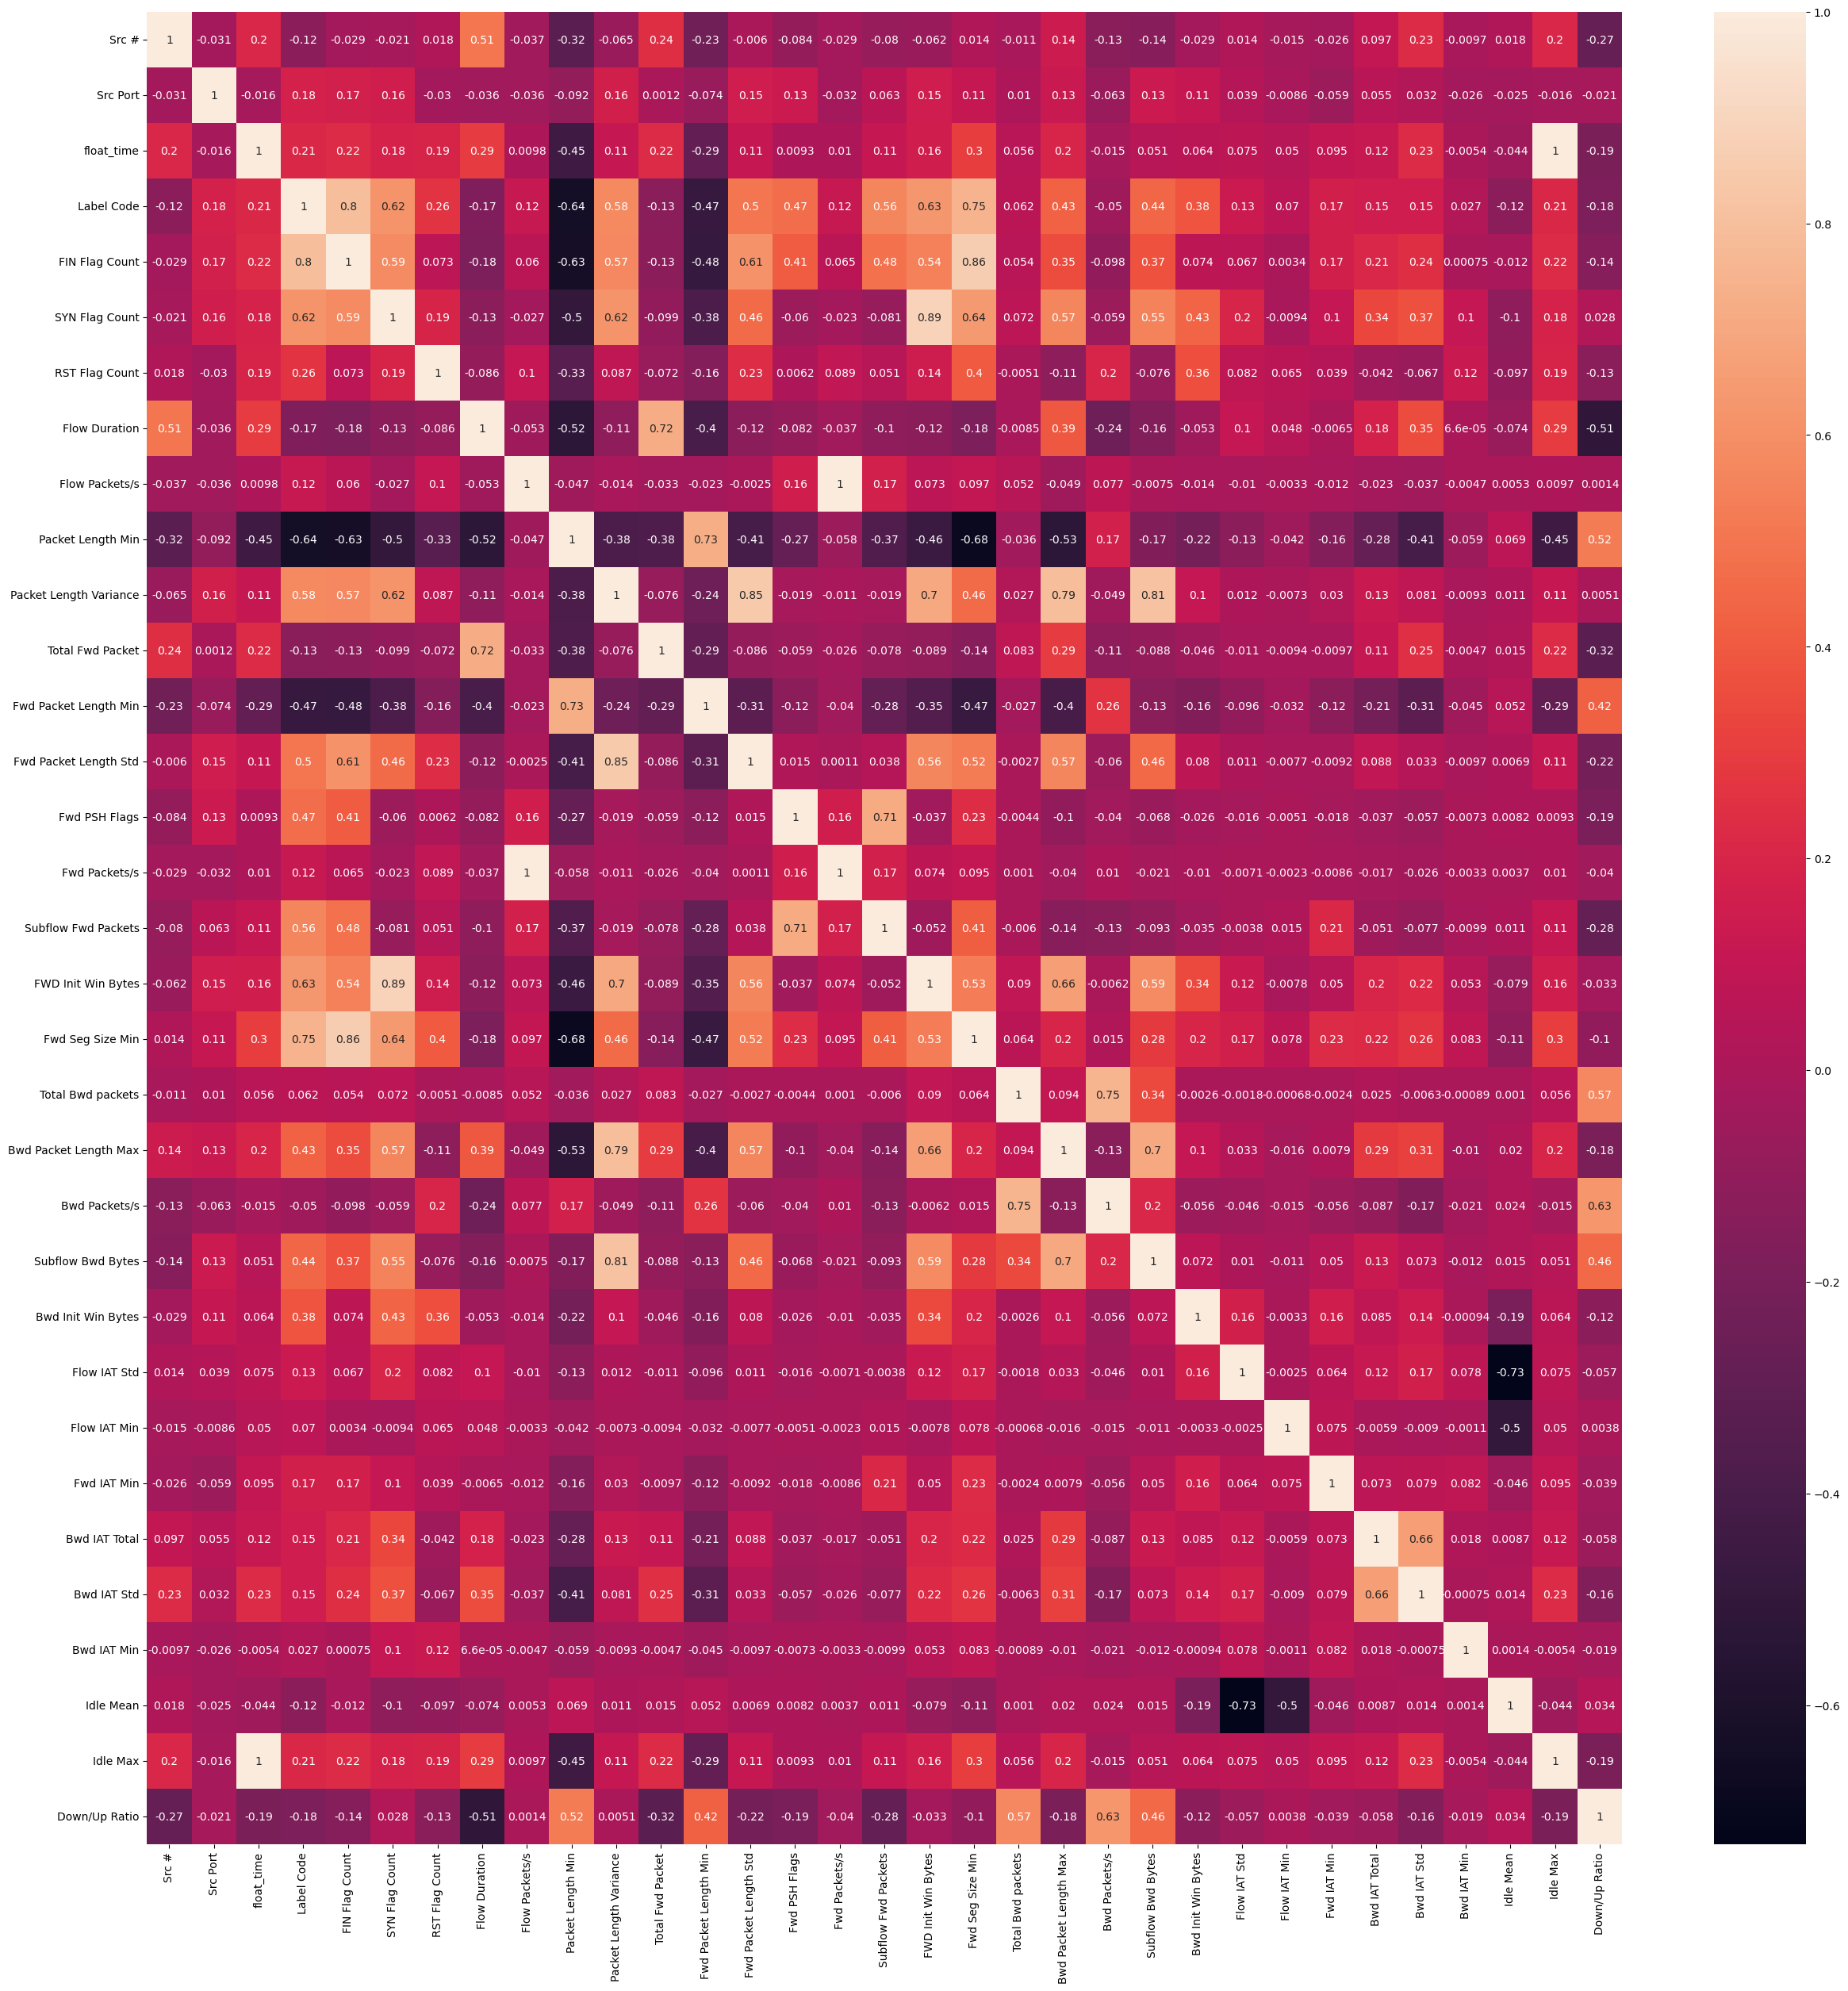

In [ ]:
Feb5_cut= Feb5_cut.drop(columns=['PSH Flag Count', 'Flow Bytes/s'])
plt.figure(figsize=(30,30))
sns.heatmap(Feb5_cut.corr(), annot=True)

<Axes: >

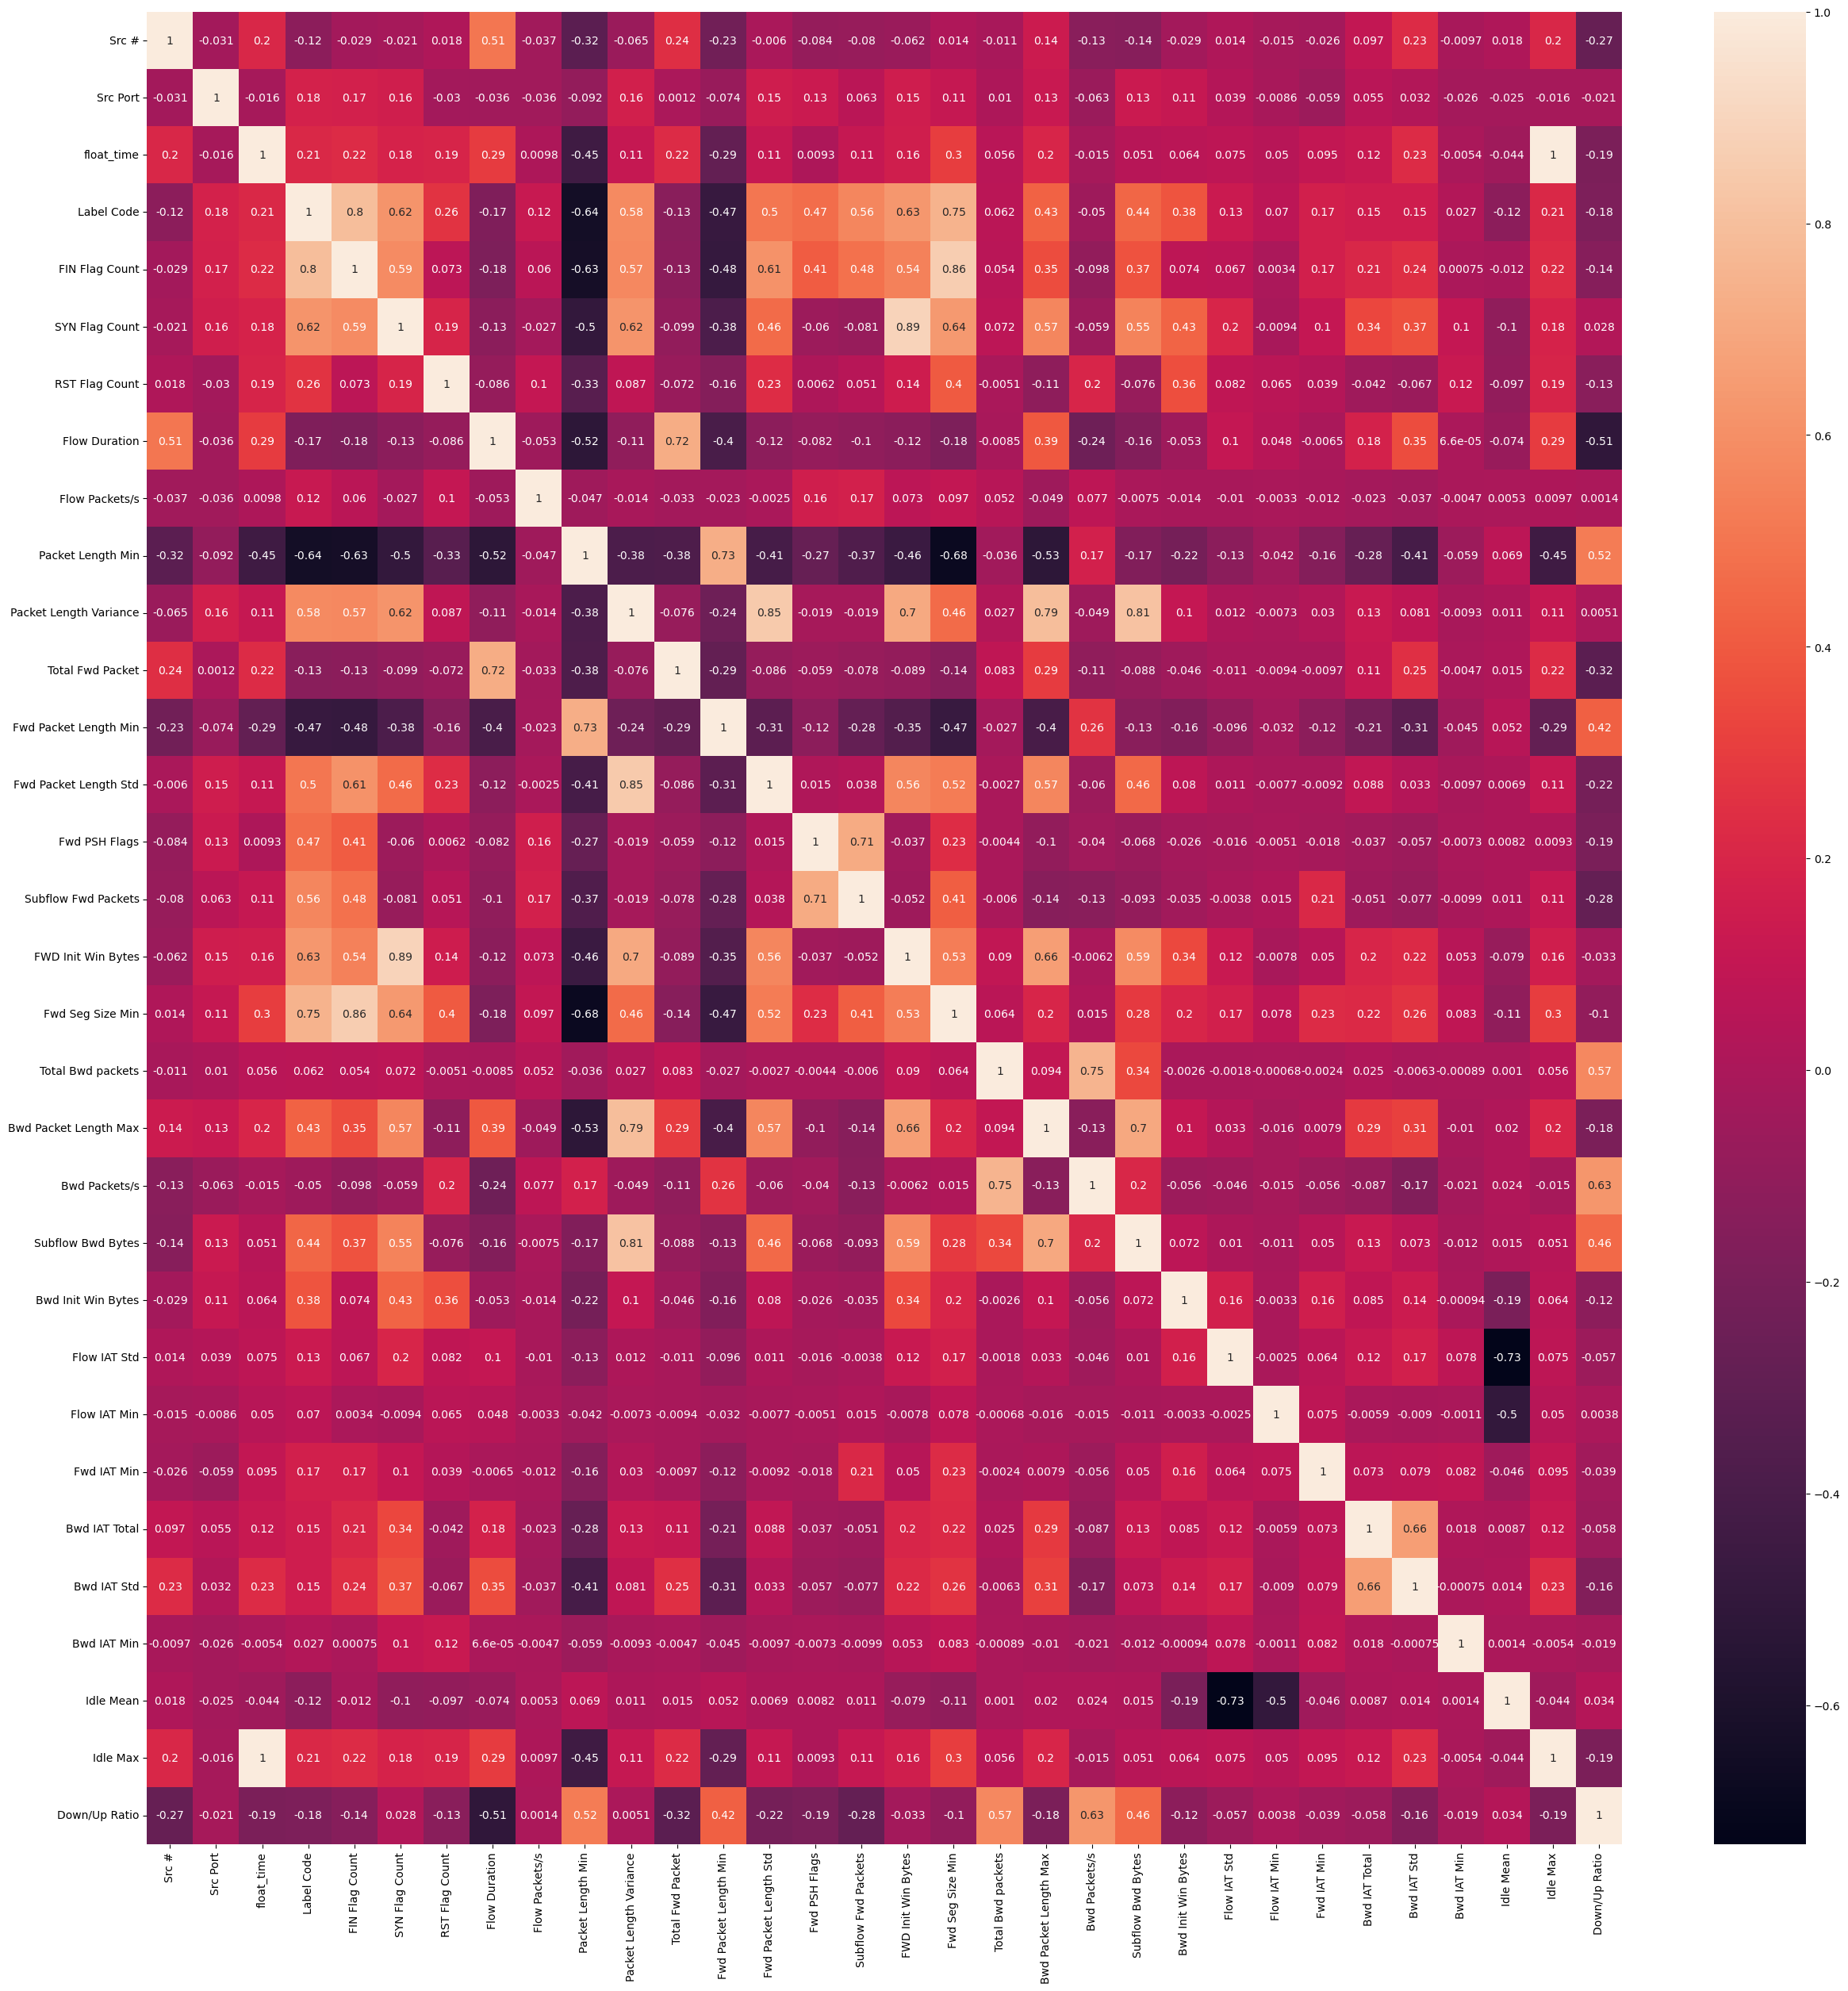

In [ ]:
Feb5_cut= Feb5_cut.drop(columns=['Fwd Packets/s'])
plt.figure(figsize=(30,30))
sns.heatmap(Feb5_cut.corr(), annot=True)

<Axes: xlabel='Idle Max', ylabel='float_time'>

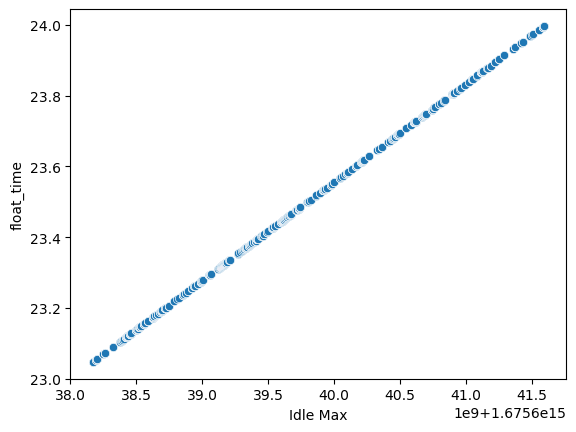

In [ ]:
sns.scatterplot(Feb5_cut, x='Idle Max', y='float_time')

In [ ]:
Feb5_cut['Bwd IAT Min'].value_counts()

Bwd IAT Min
0.0      1537
32.0       15
33.0       14
34.0       13
29.0        9
         ... 
128.0       1
439.0       1
18.0        1
5.0         1
153.0       1
Name: count, Length: 227, dtype: int64

In [ ]:
kept_cols

['Src #',
 'Src Port',
 'float_time',
 'Label Code',
 'FIN Flag Count',
 'SYN Flag Count',
 'RST Flag Count',
 'PSH Flag Count',
 'Flow Duration',
 'Flow Bytes/s',
 'Flow Packets/s',
 'Packet Length Min',
 'Packet Length Variance',
 'Total Fwd Packet',
 'Fwd Packet Length Min',
 'Fwd Packet Length Std',
 'Fwd PSH Flags',
 'Fwd Packets/s',
 'Subflow Fwd Packets',
 'FWD Init Win Bytes',
 'Fwd Seg Size Min',
 'Total Bwd packets',
 'Bwd Packet Length Max',
 'Bwd Packet Length Min',
 'Bwd Packets/s',
 'Subflow Bwd Bytes',
 'Bwd Init Win Bytes',
 'Flow IAT Std',
 'Flow IAT Min',
 'Fwd IAT Total',
 'Fwd IAT Min',
 'Bwd IAT Total',
 'Bwd IAT Std',
 'Bwd IAT Min',
 'Idle Mean',
 'Idle Max',
 'Down/Up Ratio']

# Transfroming IP into location

In [ ]:
reader = geoip2.database.Reader('/Users/sa12/Documents/Repositories/The-CyberChase/CybercrimeData/GeoLite2-City.mmdb')
# Build location info
locations = []

for ip in Feb5['Src IP']:
    try:
        response = reader.city(ip)
        country = response.country.name or "Unknown Country"
        city = response.city.name or "Unknown City"

        location_str = f"{country}"
    except Exception as e:
        location_str = f"Error: {e}"

    locations.append(location_str)

# Add to DataFrame
Feb5['Location'] = locations
Feb5

Flow ID           Src IP  Src Port  \
0      129.226.189.21-10.1.0.4-36211-123-17   129.226.189.21     36211   
1      129.226.189.21-10.1.0.4-40528-123-17   129.226.189.21     40528   
2      129.226.189.21-10.1.0.4-33823-123-17   129.226.189.21     33823   
3      129.226.189.21-10.1.0.4-34706-123-17   129.226.189.21     34706   
4      129.226.189.21-10.1.0.4-33563-123-17   129.226.189.21     33563   
...                                     ...              ...       ...   
1945   149.104.157.109-10.1.0.4-6749-123-17  149.104.157.109      6749   
1946  149.104.157.109-10.1.0.4-62335-123-17  149.104.157.109     62335   
1947    149.104.157.109-10.1.0.4-254-123-17  149.104.157.109       254   
1948  149.104.157.109-10.1.0.4-40468-123-17  149.104.157.109     40468   
1949  149.104.157.109-10.1.0.4-12285-123-17  149.104.157.109     12285   

        Dst IP  Dst Port  Protocol            Timestamp  Flow Duration  \
0     10.1.0.4       123        17  2023-02-05 23:02:50       30009444   
1     10.1.0.4       123        17  2023-02-05 23:02:50       30018257   
2     10.1.0.4       123        17  2023-02-05 23:02:50       30010489   
3     10.1.0.4       123        17  2023-02-05 23:02:50       30013069   
4     10.1.0.4       123        17  2023-02-05 23:02:50       30016745   
...        ...       ...       ...                  ...            ...   
1945  10.1.0.4       123        17  2023-02-05 23:59:51       30002935   
1946  10.1.0.4       123        17  2023-02-05 23:59:51       29910526   
1947  10.1.0.4       123        17  2023-02-05 23:59:51       29958012   
1948  10.1.0.4       123        17  2023-02-05 23:59:51       30002320   
1949  10.1.0.4       123        17  2023-02-05 23:59:51       30008272   

      Total Fwd Packet  Total Bwd packets  ...     Idle Mean  Idle Std  \
0                 3056                  4  ...  1.675638e+15       0.0   
1                 3045                  4  ...  1.675638e+15       0.0   
2                 3163                  4  ...  1.675638e+15       0.0   
3                 3025                  4  ...  1.675638e+15       0.0   
4                 3039                  4  ...  1.675638e+15       0.0   
...                ...                ...  ...           ...       ...   
1945               630                  4  ...  1.675642e+15       0.0   
1946               580                  4  ...  1.675642e+15       0.0   
1947               609                  4  ...  1.675642e+15       0.0   
1948               635                  4  ...  1.675642e+15       0.0   
1949               604                  4  ...  1.675642e+15       0.0   

          Idle Max      Idle Min    Label  Label Code  float_time  \
0     1.675638e+15  1.675638e+15  ddospot           1   23.047222   
1     1.675638e+15  1.675638e+15  ddospot           1   23.047222   
2     1.675638e+15  1.675638e+15  ddospot           1   23.047222   
3     1.675638e+15  1.675638e+15  ddospot           1   23.047222   
4     1.675638e+15  1.675638e+15  ddospot           1   23.047222   
...            ...           ...      ...         ...         ...   
1945  1.675642e+15  1.675642e+15  ddospot           1   23.997500   
1946  1.675642e+15  1.675642e+15  ddospot           1   23.997500   
1947  1.675642e+15  1.675642e+15  ddospot           1   23.997500   
1948  1.675642e+15  1.675642e+15  ddospot           1   23.997500   
1949  1.675642e+15  1.675642e+15  ddospot           1   23.997500   

             Src #  Dst #   Location  
0      12922618921  10104  Hong Kong  
1      12922618921  10104  Hong Kong  
2      12922618921  10104  Hong Kong  
3      12922618921  10104  Hong Kong  
4      12922618921  10104  Hong Kong  
...            ...    ...        ...  
1945  149104157109  10104  Hong Kong  
1946  149104157109  10104  Hong Kong  
1947  149104157109  10104  Hong Kong  
1948  149104157109  10104  Hong Kong  
1949  149104157109  10104  Hong Kong  

[1950 rows x 89 columns]

<Axes: ylabel='Location'>

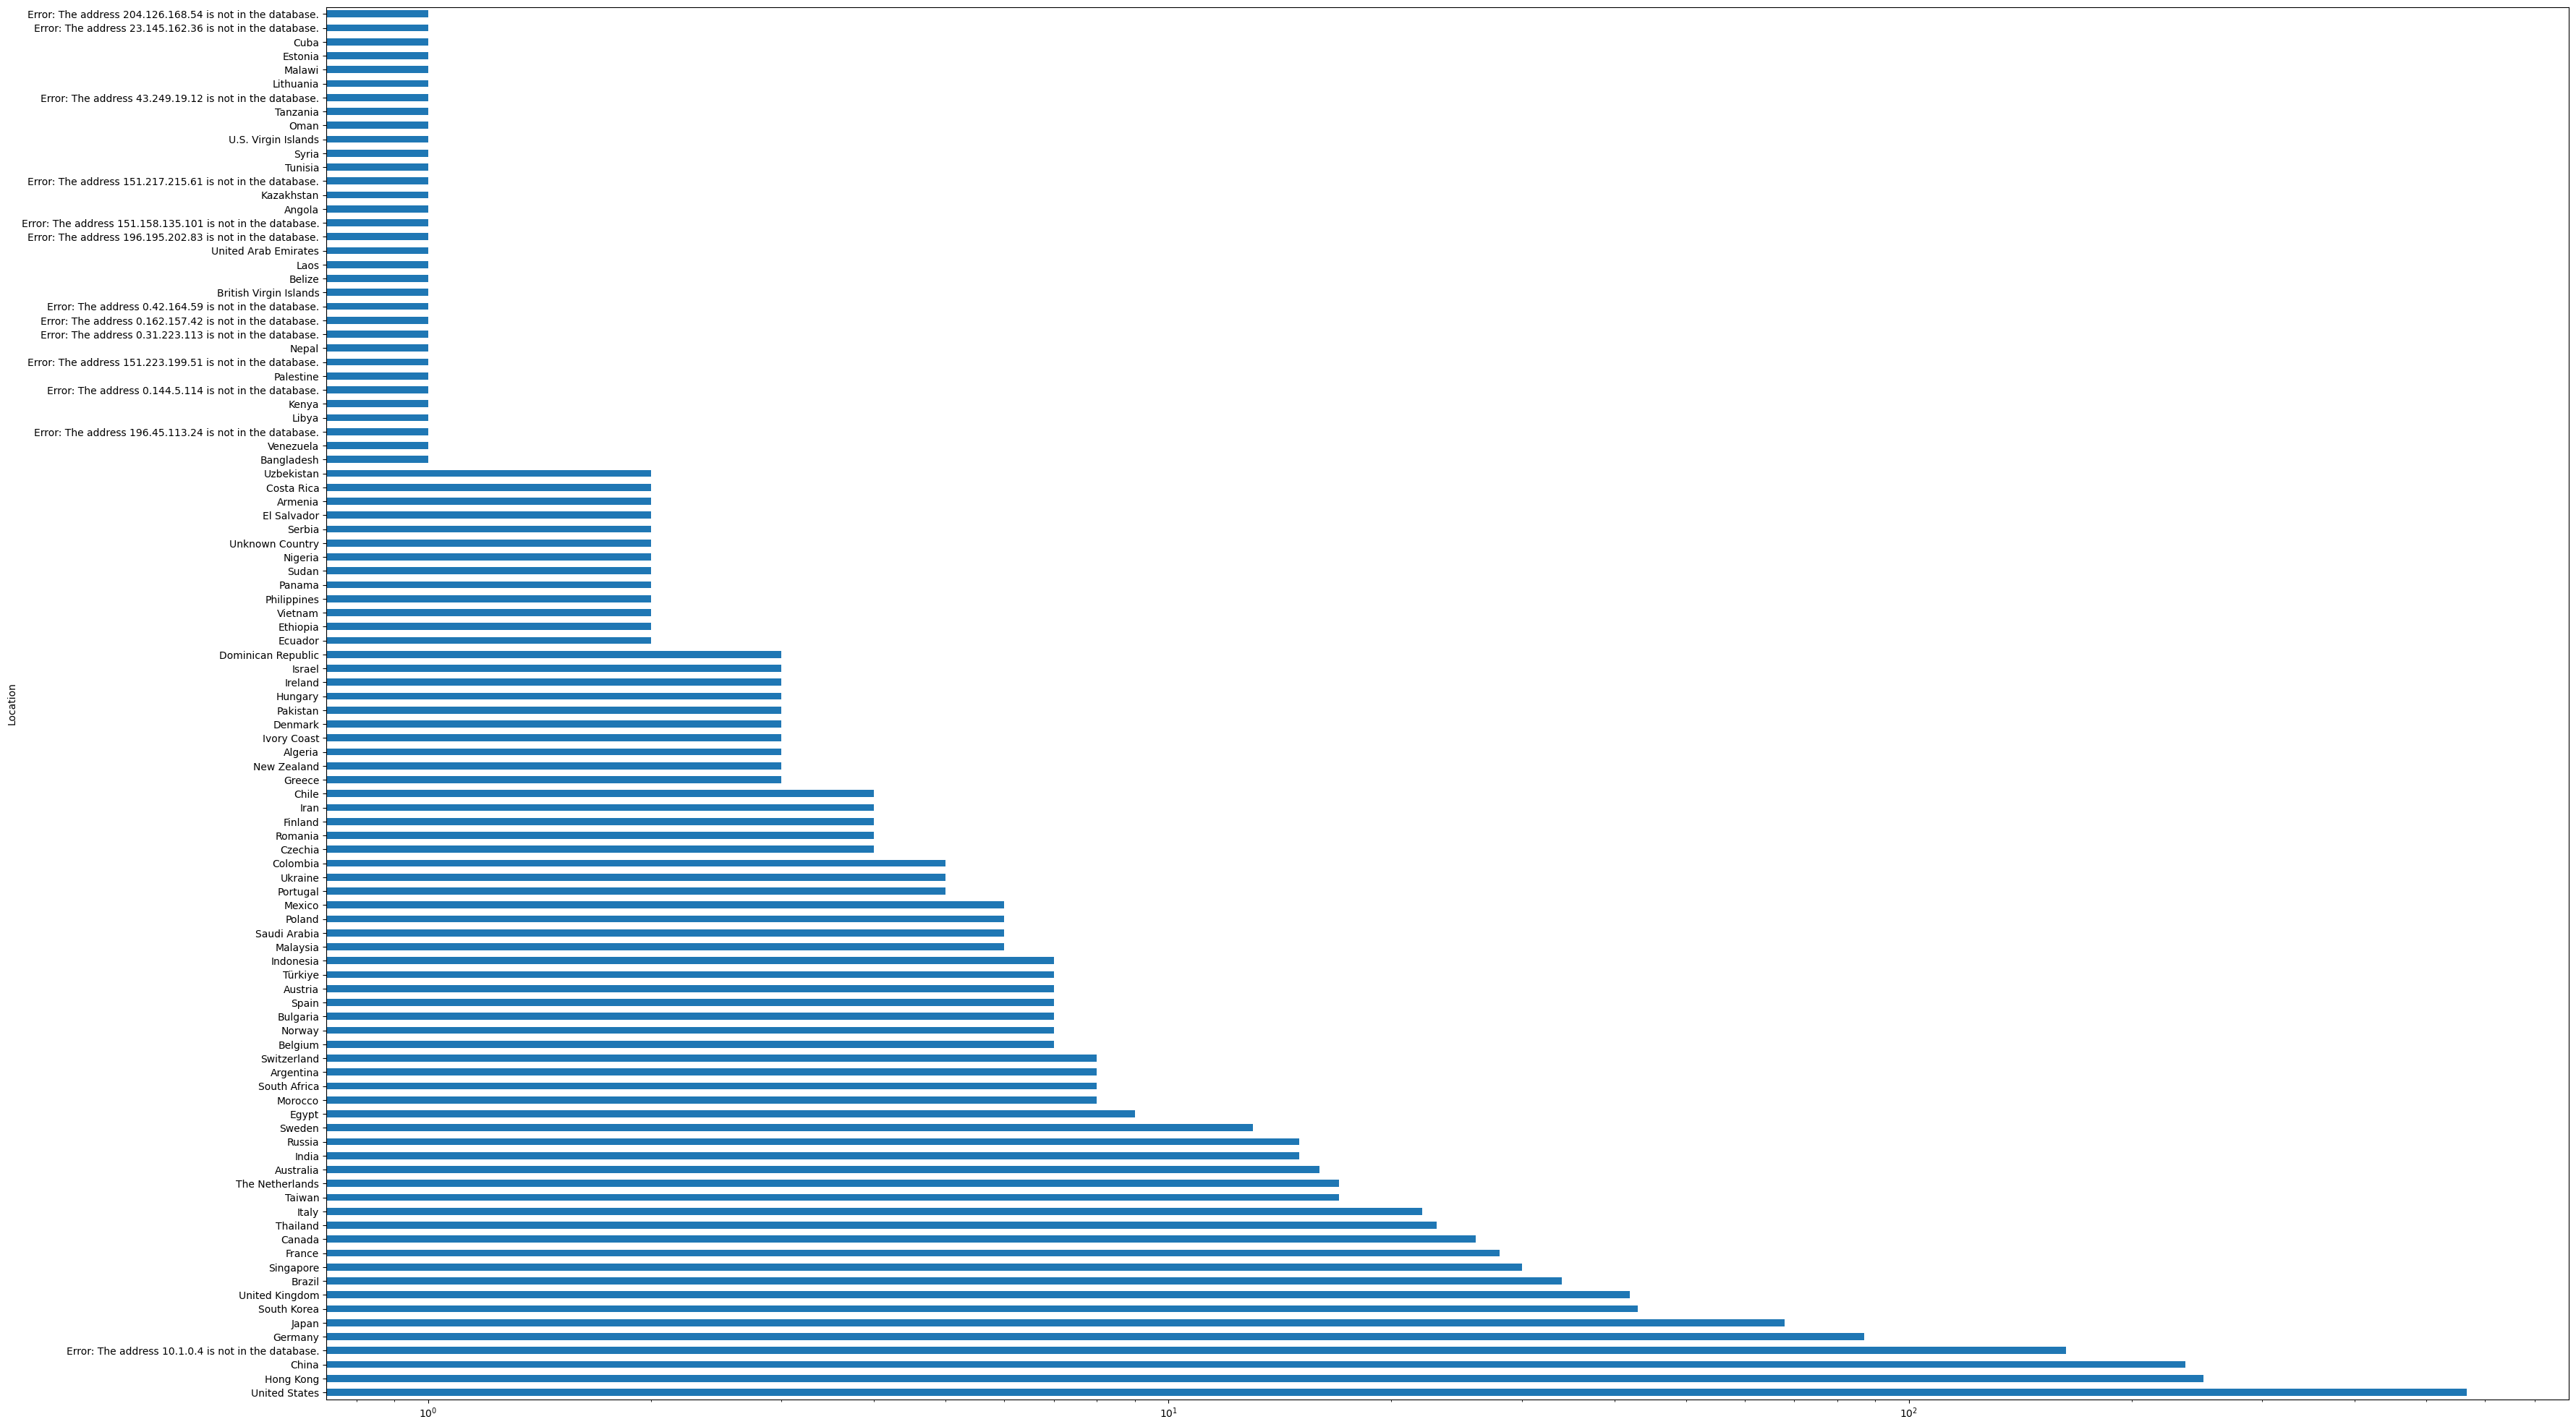

In [ ]:
Feb5['Location'].value_counts().plot(kind='barh', figsize=(40,25), logx=True)


In [ ]:
# Build location info
locations_2 = []

for ip in Feb6['Src IP']:
    try:
        response = reader.city(ip)
        country = response.country.name or "Unknown Country"
        city = response.city.name or "Unknown City"

        location_str = f"{country}"
    except Exception as e:
        location_str = f"Error: {e}"

    locations_2.append(location_str)

# Add to DataFrame
Feb6['Location'] = locations_2
Feb6

Flow ID          Src IP  Src Port  \
0         61.177.172.145-10.1.0.4-37881-22-6  61.177.172.145     37881   
1         61.177.172.145-10.1.0.4-37881-22-6  61.177.172.145     37881   
2         91.195.240.12-10.1.0.4-5960-123-17   91.195.240.12      5960   
3         91.195.240.12-10.1.0.4-4689-123-17   91.195.240.12      4689   
4         91.195.240.12-10.1.0.4-3683-123-17   91.195.240.12      3683   
...                                      ...             ...       ...   
162273   95.162.223.26-10.1.0.4-50900-123-17   95.162.223.26     50900   
162274   95.162.223.26-10.1.0.4-59861-123-17   95.162.223.26     59861   
162275   95.162.210.103-10.1.0.4-1492-123-17  95.162.210.103      1492   
162276  95.162.215.209-10.1.0.4-64689-123-17  95.162.215.209     64689   
162277  95.162.215.209-10.1.0.4-63337-123-17  95.162.215.209     63337   

          Dst IP  Dst Port  Protocol            Timestamp  Flow Duration  \
0       10.1.0.4        22         6  2023-02-06 00:00:15         582135   
1       10.1.0.4        22         6  2023-02-06 00:00:17            395   
2       10.1.0.4       123        17  2023-02-06 00:00:48       30007782   
3       10.1.0.4       123        17  2023-02-06 00:00:48       29992657   
4       10.1.0.4       123        17  2023-02-06 00:00:48       30013940   
...          ...       ...       ...                  ...            ...   
162273  10.1.0.4       123        17  2023-02-06 23:59:59       28213032   
162274  10.1.0.4       123        17  2023-02-06 23:59:59       80298510   
162275  10.1.0.4       123        17  2023-02-06 23:59:59       62600014   
162276  10.1.0.4       123        17  2023-02-06 23:59:59      114660707   
162277  10.1.0.4       123        17  2023-02-06 23:59:59      119260278   

        Total Fwd Packet  Total Bwd packets  ...  Active Mean  Active Std  \
0                      3                  4  ...          0.0         0.0   
1                      3                  0  ...          0.0         0.0   
2                    557                  4  ...          0.0         0.0   
3                    591                  4  ...          0.0         0.0   
4                    615                  4  ...          0.0         0.0   
...                  ...                ...  ...          ...         ...   
162273                 2                  0  ...          0.0         0.0   
162274                 2                  0  ...          0.0         0.0   
162275                 2                  0  ...          0.0         0.0   
162276                 2                  0  ...          0.0         0.0   
162277                 3                  0  ...          0.0         0.0   

        Active Max  Active Min     Idle Mean      Idle Std      Idle Max  \
0              0.0         0.0  1.675642e+15  0.000000e+00  1.675642e+15   
1              0.0         0.0  1.675642e+15  0.000000e+00  1.675642e+15   
2              0.0         0.0  1.675642e+15  0.000000e+00  1.675642e+15   
3              0.0         0.0  1.675642e+15  0.000000e+00  1.675642e+15   
4              0.0         0.0  1.675642e+15  0.000000e+00  1.675642e+15   
...            ...         ...           ...           ...           ...   
162273         0.0         0.0  8.378640e+14  1.184919e+15  1.675728e+15   
162274         0.0         0.0  8.378640e+14  1.184919e+15  1.675728e+15   
162275         0.0         0.0  8.378640e+14  1.184919e+15  1.675728e+15   
162276         0.0         0.0  8.378641e+14  1.184919e+15  1.675728e+15   
162277         0.0         0.0  5.585760e+14  9.674820e+14  1.675728e+15   

            Idle Min    Label  Location  
0       1.675642e+15   cowrie     China  
1       1.675642e+15   cowrie     China  
2       1.675642e+15  ddospot   Germany  
3       1.675642e+15  ddospot   Germany  
4       1.675642e+15  ddospot   Germany  
...              ...      ...       ...  
162273  2.821303e+07  ddospot      Iran  
162274  8.029851e+07  ddospot      Iran  
162275  6.260001e+0

<Axes: ylabel='Location'>

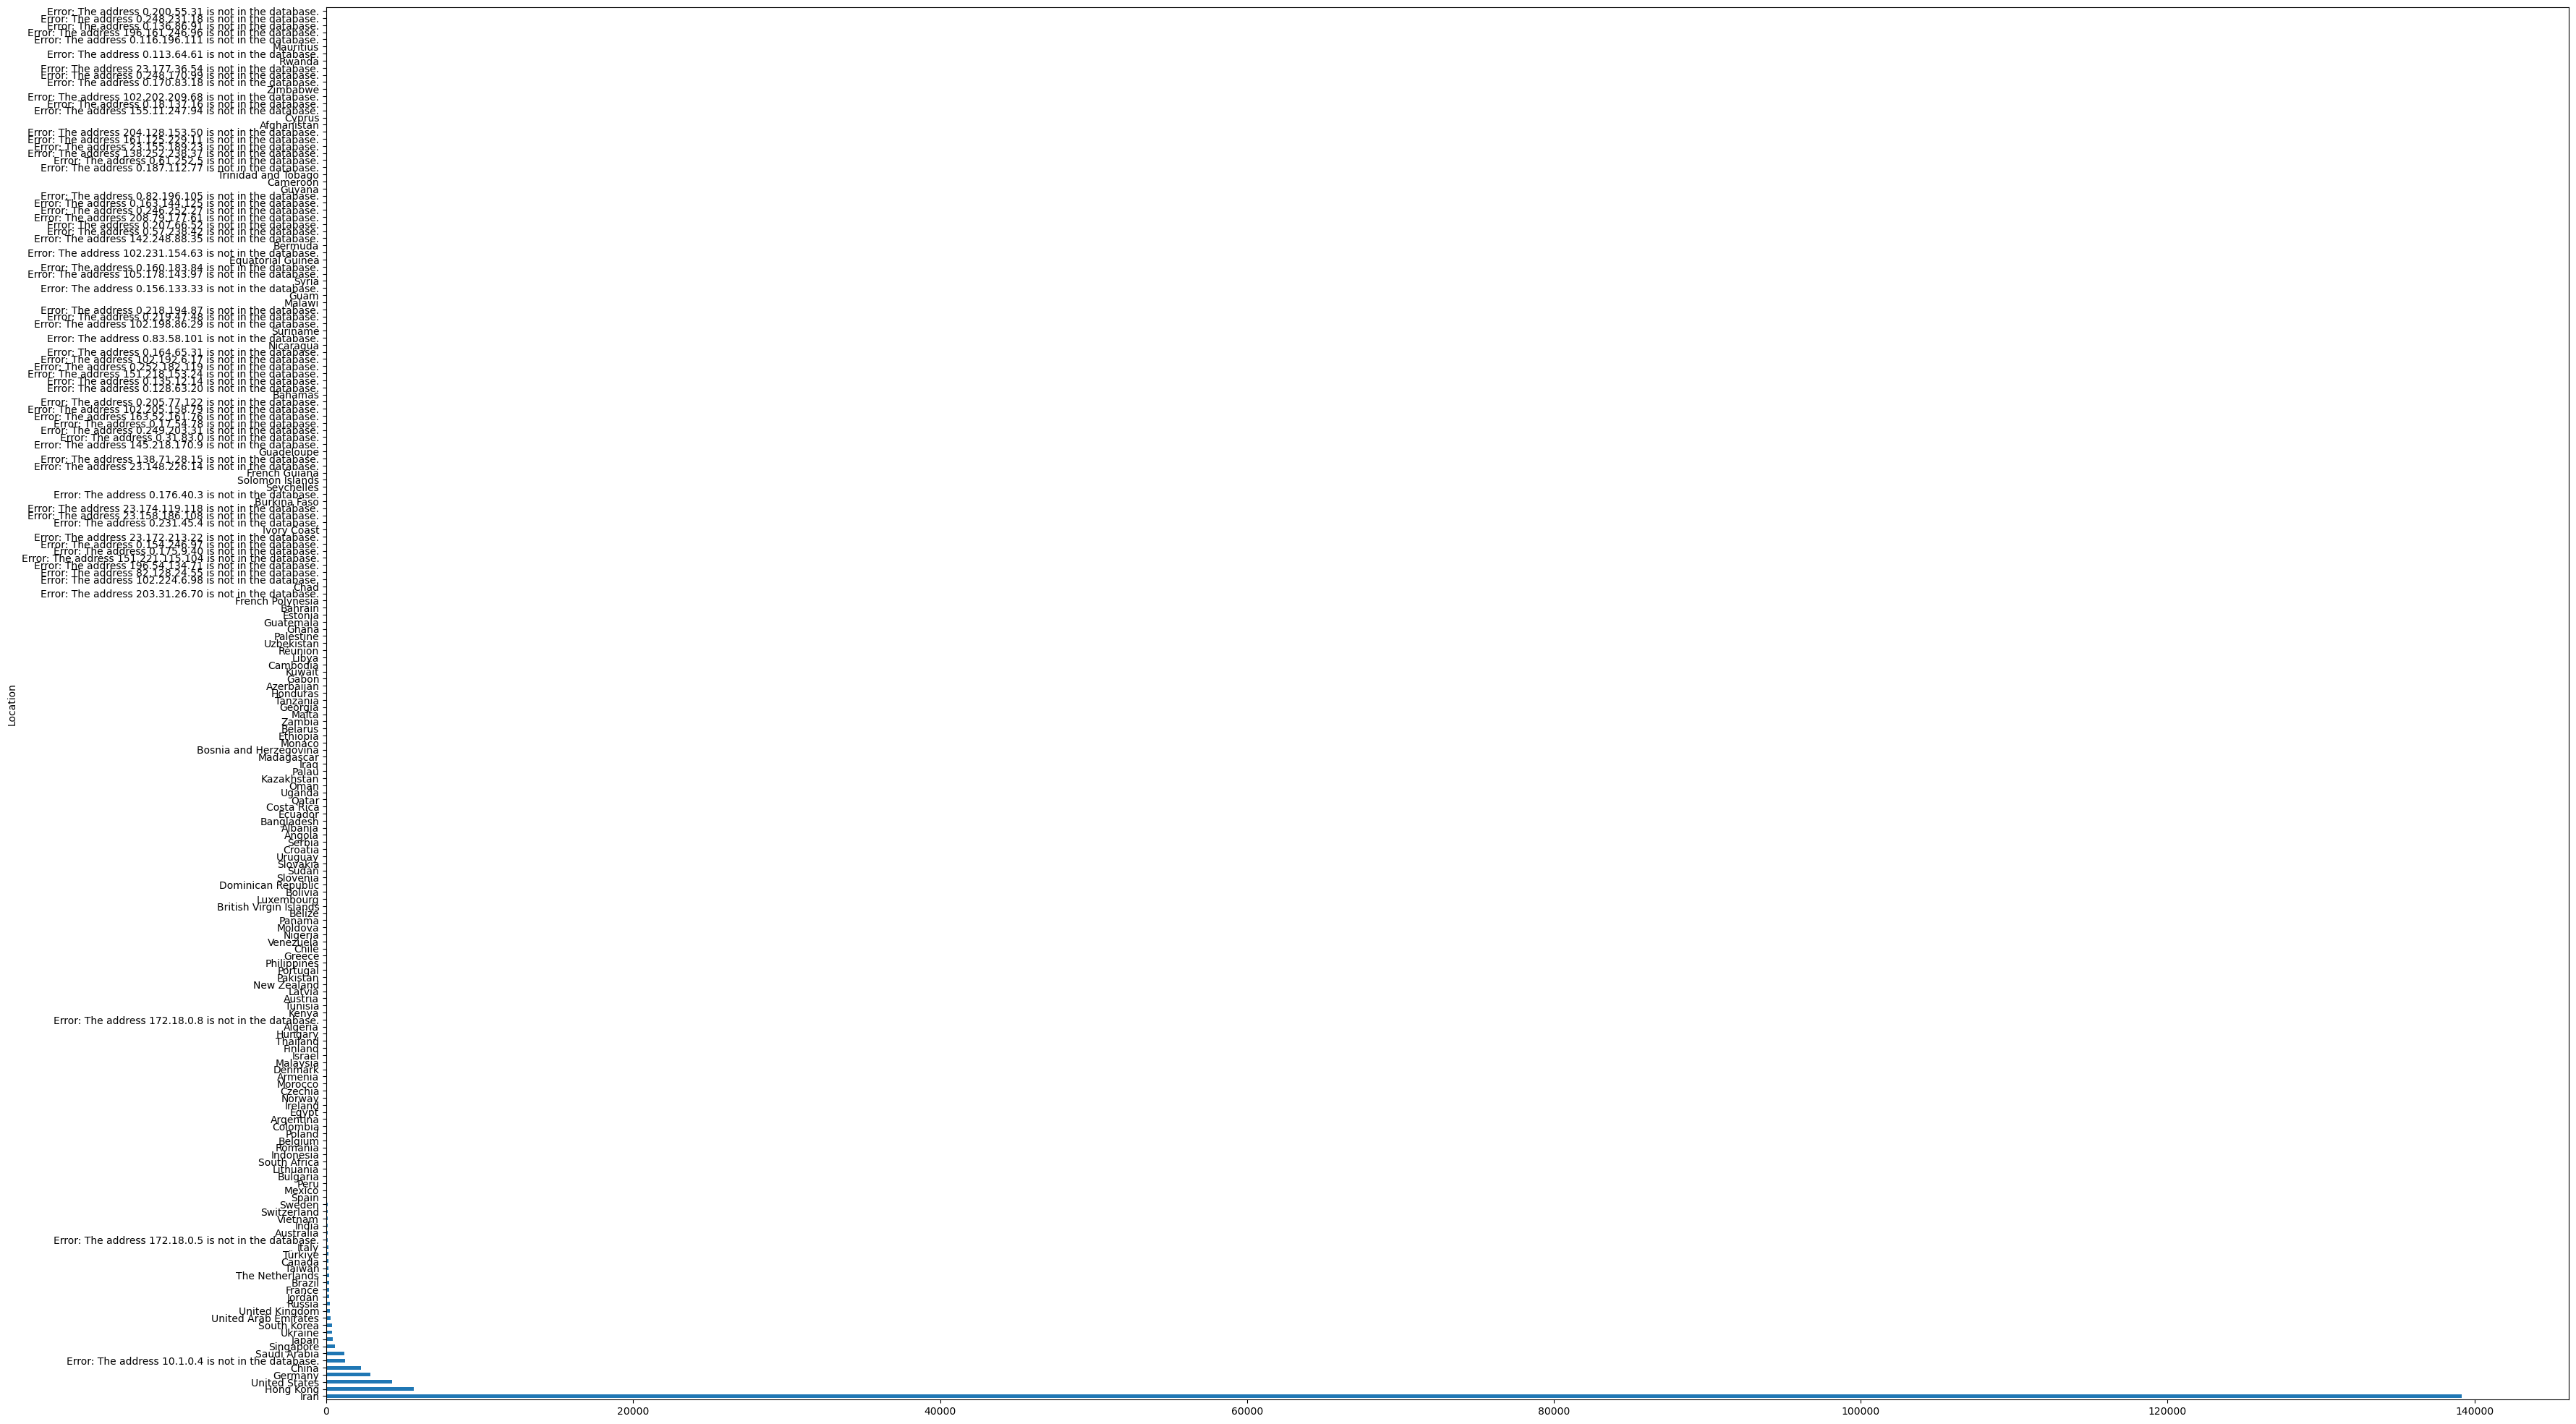

In [ ]:
Feb6['Location'].value_counts().plot(kind='barh', figsize=(40,25))

In [ ]:
zeros = ['Fwd Packet Length Std',
'Bwd IAT Std',
'Fwd PSH Flags',
'Bwd PSH Flags',
'Fwd URG Flags',
'Bwd URG Flags',
'FIN Flag Count',
'SYN Flag Count',
'RST Flag Count',
'PSH Flag Count',
'ACK Flag Count',
'URG Flag Count',
'CWR Flag Count',
'ECE Flag Count',
'Fwd Bytes/Bulk Avg',
'Fwd Packet/Bulk Avg',
'Fwd Bulk Rate Avg',
'Subflow Bwd Packets',
'FWD Init Win Bytes',
'Bwd Init Win Bytes',
'Active Std',
'Fwd Packet Length Std',
 'Fwd PSH Flags',
 'Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'FIN Flag Count',
 'SYN Flag Count',
 'RST Flag Count',
 'PSH Flag Count',
 'URG Flag Count',
 'CWR Flag Count',
 'ECE Flag Count',
 'Fwd Bytes/Bulk Avg',
 'Fwd Packet/Bulk Avg',
 'Fwd Bulk Rate Avg',
 'Subflow Bwd Packets',
 'Bwd Init Win Bytes',
 'Active Std',
 'Fwd PSH Flags',
 'Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'URG Flag Count',
 'CWR Flag Count',
 'ECE Flag Count',
 'Fwd Bytes/Bulk Avg',
 'Fwd Packet/Bulk Avg',
 'Fwd Bulk Rate Avg',
 'Subflow Bwd Packets',
 'Fwd PSH Flags',
 'Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'URG Flag Count',
 'CWR Flag Count',
 'ECE Flag Count',
 'Fwd Bytes/Bulk Avg',
 'Fwd Packet/Bulk Avg',
 'Fwd Bulk Rate Avg',
 'Subflow Bwd Packets',
 'Active Mean',
 'Active Std',
 'Active Max',
 'Active Min']

In [ ]:
def duplicates(input_list):
    counts = {}
    for item in input_list:
        if item in counts:
            counts[item] += 1
        else:
            counts[item] = 1
    return {item: count for item, count in counts.items()}
duplicates(zeros)


{'Fwd Packet Length Std': 2,
 'Bwd IAT Std': 1,
 'Fwd PSH Flags': 4,
 'Bwd PSH Flags': 4,
 'Fwd URG Flags': 4,
 'Bwd URG Flags': 4,
 'FIN Flag Count': 2,
 'SYN Flag Count': 2,
 'RST Flag Count': 2,
 'PSH Flag Count': 2,
 'ACK Flag Count': 1,
 'URG Flag Count': 4,
 'CWR Flag Count': 4,
 'ECE Flag Count': 4,
 'Fwd Bytes/Bulk Avg': 4,
 'Fwd Packet/Bulk Avg': 4,
 'Fwd Bulk Rate Avg': 4,
 'Subflow Bwd Packets': 4,
 'FWD Init Win Bytes': 1,
 'Bwd Init Win Bytes': 2,
 'Active Std': 3,
 'Active Mean': 1,
 'Active Max': 1,
 'Active Min': 1}

In [ ]:
keep = Feb5_cut.columns
keep

Index(['Src #', 'Src Port', 'float_time', 'Label Code', 'FIN Flag Count',
       'SYN Flag Count', 'RST Flag Count', 'Flow Duration', 'Flow Packets/s',
       'Packet Length Min', 'Packet Length Variance', 'Total Fwd Packet',
       'Fwd Packet Length Min', 'Fwd Packet Length Std', 'Fwd PSH Flags',
       'Subflow Fwd Packets', 'FWD Init Win Bytes', 'Fwd Seg Size Min',
       'Total Bwd packets', 'Bwd Packet Length Max', 'Bwd Packets/s',
       'Subflow Bwd Bytes', 'Bwd Init Win Bytes', 'Flow IAT Std',
       'Flow IAT Min', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Std',
       'Bwd IAT Min', 'Idle Mean', 'Idle Max', 'Down/Up Ratio'],
      dtype='object')